<a href="https://colab.research.google.com/github/DavidReveloLuna/MaskRCNN_Video/blob/master/Casco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw
import random


In [2]:
!git clone https://github.com/DavidReveloLuna/MaskRCNN_Video.git

Cloning into 'MaskRCNN_Video'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 111 (delta 39), reused 59 (delta 8), pack-reused 0
Receiving objects: 100% (111/111), 46.52 MiB | 29.12 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
cd C:/Users/fa_bi/OneDrive/Documentos/PASANTIAS/MaskRCNN_Video-master/


C:\Users\fa_bi\OneDrive\Documentos\PASANTIAS\MaskRCNN_Video-master


In [4]:
!python setup.py install

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\setuptools\dist.py:773: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt)
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\setuptools\dist.py:773: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt)
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\setuptools\dist.py:773: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt)
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\setuptools\config\setupcfg.py:508: SetuptoolsDeprecationWarning: The license_file parameter is deprecated, use license_files instead.
  warnings.warn(msg, warning_class)
INFO:r

In [4]:
ROOT_DIR = 'C:/Users/fa_bi/OneDrive/Documentos/PASANTIAS/MaskRCNN_Video-master/'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist'

sys.path.append(ROOT_DIR) 

from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [5]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [6]:
class CascoConfig(Config):
    """Configuration for training on the helmet  dataset.
    """
    # Give the configuration a recognizable name
    NAME = "casco"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (casco)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 200

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CascoConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [7]:

class CascoDataset(utils.Dataset):

    def load_cascos(self, dataset_dir, subset):
        """Load a subset of the Casco dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("casco", 1, "casco")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "casco",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a casco dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "casco":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "casco":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [8]:
dataset_train = CascoDataset()
dataset_train.load_cascos("C:/Users/fa_bi/OneDrive/Documentos/PASANTIAS/MaskRCNN_Video-master/dataset/casco", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CascoDataset()
dataset_val.load_cascos("C:/Users/fa_bi/OneDrive/Documentos/PASANTIAS/MaskRCNN_Video-master/dataset/casco", "val")
dataset_val.prepare()

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


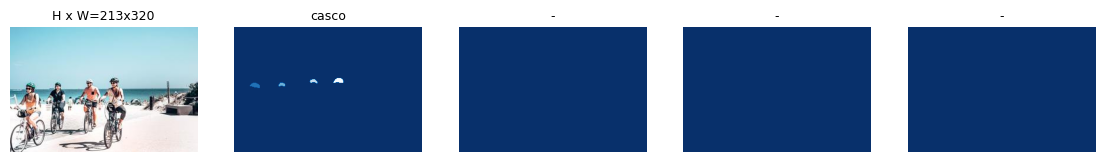

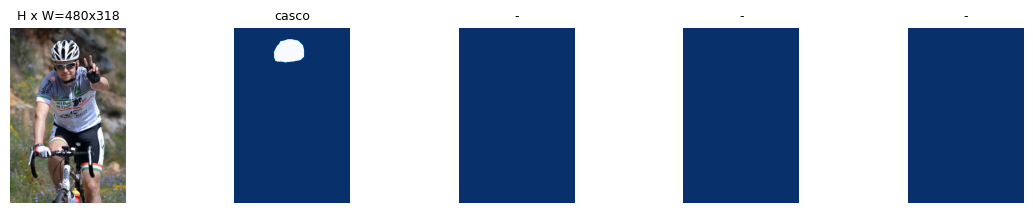

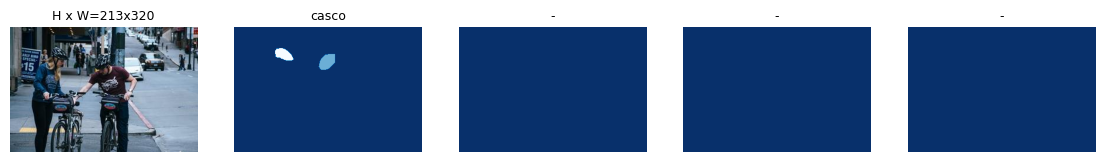

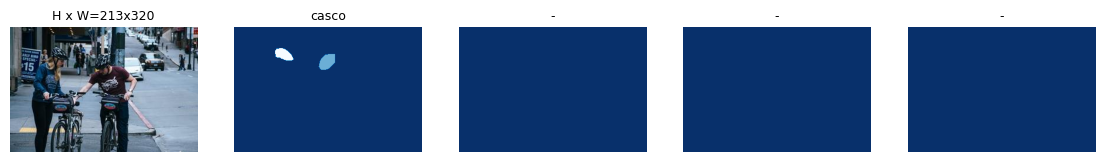

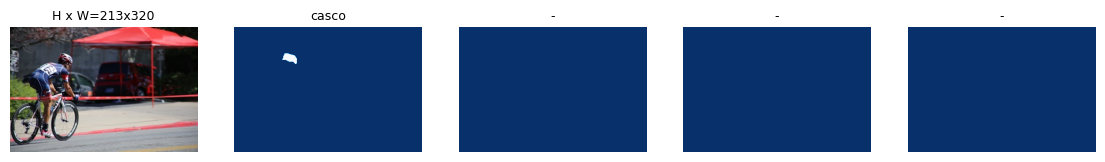

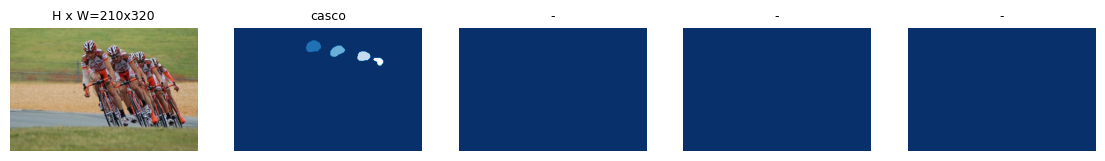

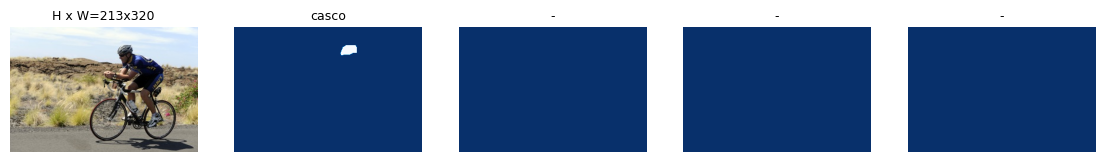

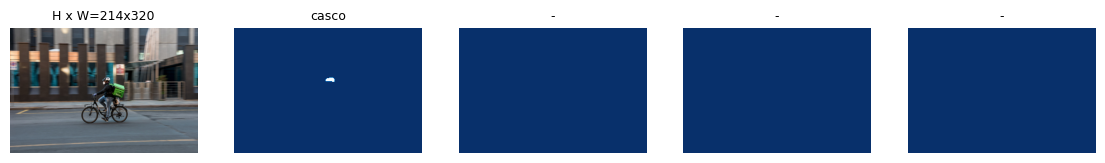

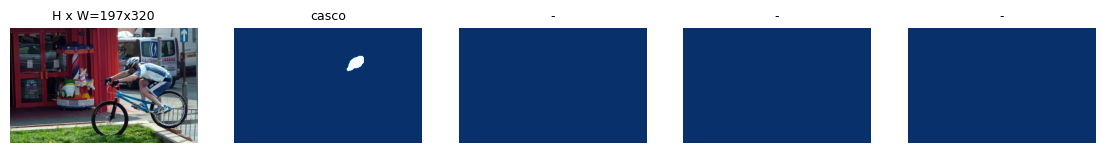

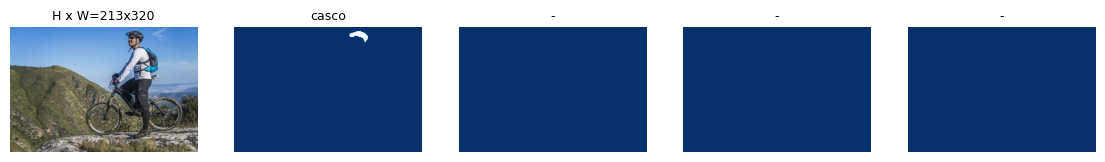

In [11]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 10)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  21 C:/Users/fa_bi/OneDrive/Documentos/PASANTIAS/MaskRCNN_Video-master/dataset/casco\train\man-nature-outdoor-mountain-trail-sport-840955-pxhere.com.jpg
image                    shape: (197, 320, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (197, 320, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   49.00000  max:  221.00000  int32


C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


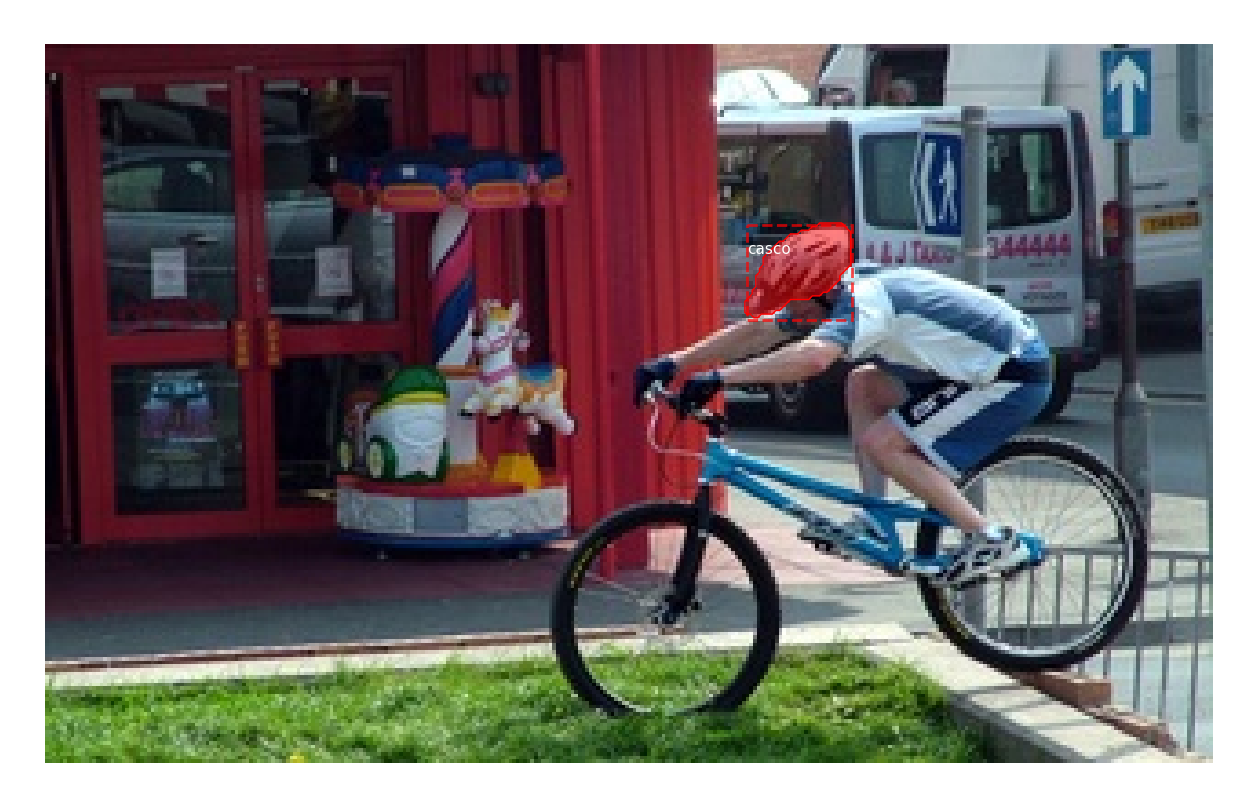

In [12]:
from mrcnn.model import log
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:/Users/fa_bi/OneDrive/Documentos/PASANTIAS/MaskRCNN_Video-master/logs\casco20230415T1200\mask_rcnn_casco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_ma

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


  1/200 [..............................] - ETA: 0s - loss: 4.1040 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 3.3970 - mrcnn_class_loss: 0.6699 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/200 [..............................] - ETA: 9:35 - loss: 3.1281 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 2.7214 - mrcnn_class_loss: 0.3758 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/200 [..............................] - ETA: 12:12 - loss: 2.8963 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 2.6098 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/200 [..............................] - ETA: 13:37 - loss: 2.7393 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 2.1844 - mrcnn_class_loss: 0.1945 - mrcnn_bbox_loss: 0.1712 - mrcnn_mask_loss: 0.1485        

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/200 [..............................] - ETA: 14:21 - loss: 2.4226 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.9500 - mrcnn_class_loss: 0.1557 - mrcnn_bbox_loss: 0.1369 - mrcnn_mask_loss: 0.1188

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/200 [..............................] - ETA: 15:00 - loss: 2.1682 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 1.7697 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.0990

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/200 [>.............................] - ETA: 15:25 - loss: 1.9369 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.5926 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.0849

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/200 [>.............................] - ETA: 15:43 - loss: 1.8392 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 1.5352 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.0743

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/200 [>.............................] - ETA: 15:58 - loss: 1.9061 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.4241 - mrcnn_class_loss: 0.1647 - mrcnn_bbox_loss: 0.1575 - mrcnn_mask_loss: 0.1174

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/200 [>.............................] - ETA: 16:16 - loss: 1.7872 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 1.3517 - mrcnn_class_loss: 0.1482 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1056

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/200 [>.............................] - ETA: 16:20 - loss: 1.9807 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 1.5746 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.0960

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/200 [>.............................] - ETA: 16:25 - loss: 2.0232 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.4984 - mrcnn_class_loss: 0.1756 - mrcnn_bbox_loss: 0.1967 - mrcnn_mask_loss: 0.1093

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/200 [>.............................] - ETA: 16:26 - loss: 1.9944 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.5045 - mrcnn_class_loss: 0.1621 - mrcnn_bbox_loss: 0.1815 - mrcnn_mask_loss: 0.1009

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/200 [=>............................] - ETA: 16:26 - loss: 1.9379 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.4819 - mrcnn_class_loss: 0.1505 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.0937

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/200 [=>............................] - ETA: 16:26 - loss: 1.8894 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.4625 - mrcnn_class_loss: 0.1405 - mrcnn_bbox_loss: 0.1573 - mrcnn_mask_loss: 0.0874

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/200 [=>............................] - ETA: 16:36 - loss: 1.9678 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.4671 - mrcnn_class_loss: 0.1435 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.1002

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/200 [=>............................] - ETA: 16:44 - loss: 1.9848 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 1.4332 - mrcnn_class_loss: 0.1420 - mrcnn_bbox_loss: 0.2632 - mrcnn_mask_loss: 0.1063

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/200 [=>............................] - ETA: 16:45 - loss: 1.9319 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 1.4015 - mrcnn_class_loss: 0.1341 - mrcnn_bbox_loss: 0.2486 - mrcnn_mask_loss: 0.1004

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/200 [=>............................] - ETA: 16:45 - loss: 1.9394 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 1.3566 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.2991 - mrcnn_mask_loss: 0.1091

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/200 [==>...........................] - ETA: 16:50 - loss: 1.9679 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 1.2986 - mrcnn_class_loss: 0.1232 - mrcnn_bbox_loss: 0.3741 - mrcnn_mask_loss: 0.1278

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/200 [==>...........................] - ETA: 16:52 - loss: 1.9971 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 1.2895 - mrcnn_class_loss: 0.1198 - mrcnn_bbox_loss: 0.4142 - mrcnn_mask_loss: 0.1297

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/200 [==>...........................] - ETA: 16:48 - loss: 1.9355 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.2597 - mrcnn_class_loss: 0.1143 - mrcnn_bbox_loss: 0.3954 - mrcnn_mask_loss: 0.1238

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/200 [==>...........................] - ETA: 16:42 - loss: 1.9367 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 1.2169 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.4349 - mrcnn_mask_loss: 0.1309

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/200 [==>...........................] - ETA: 16:36 - loss: 1.9056 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.2122 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.4168 - mrcnn_mask_loss: 0.1254

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/200 [==>...........................] - ETA: 16:33 - loss: 1.8809 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 1.1814 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.4165 - mrcnn_mask_loss: 0.1356

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/200 [==>...........................] - ETA: 16:30 - loss: 1.8343 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.1612 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.4005 - mrcnn_mask_loss: 0.1304

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/200 [===>..........................] - ETA: 16:26 - loss: 1.8337 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.1414 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.4123 - mrcnn_mask_loss: 0.1394

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/200 [===>..........................] - ETA: 16:21 - loss: 1.8411 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.1120 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.4419 - mrcnn_mask_loss: 0.1472

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/200 [===>..........................] - ETA: 16:16 - loss: 1.8039 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.0987 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.4266 - mrcnn_mask_loss: 0.1421

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/200 [===>..........................] - ETA: 16:09 - loss: 1.7839 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 1.1018 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.4124 - mrcnn_mask_loss: 0.1374

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/200 [===>..........................] - ETA: 16:01 - loss: 1.7652 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 1.0709 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.4294 - mrcnn_mask_loss: 0.1359

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/200 [===>..........................] - ETA: 15:57 - loss: 1.7689 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 1.0584 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.4315 - mrcnn_mask_loss: 0.1511

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/200 [===>..........................] - ETA: 15:53 - loss: 1.7571 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.0434 - mrcnn_class_loss: 0.0878 - mrcnn_bbox_loss: 0.4359 - mrcnn_mask_loss: 0.1505

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/200 [====>.........................] - ETA: 15:53 - loss: 1.7526 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 1.0385 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.4323 - mrcnn_mask_loss: 0.1543

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/200 [====>.........................] - ETA: 15:49 - loss: 1.7281 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.0321 - mrcnn_class_loss: 0.0851 - mrcnn_bbox_loss: 0.4199 - mrcnn_mask_loss: 0.1499

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/200 [====>.........................] - ETA: 15:44 - loss: 1.7218 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.0436 - mrcnn_class_loss: 0.0828 - mrcnn_bbox_loss: 0.4083 - mrcnn_mask_loss: 0.1457

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/200 [====>.........................] - ETA: 15:42 - loss: 1.7287 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 1.0396 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.4143 - mrcnn_mask_loss: 0.1497

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/200 [====>.........................] - ETA: 15:40 - loss: 1.7416 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 1.0486 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.4201 - mrcnn_mask_loss: 0.1495

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/200 [====>.........................] - ETA: 15:38 - loss: 1.7571 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 1.0445 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.4380 - mrcnn_mask_loss: 0.1515

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/200 [=====>........................] - ETA: 15:34 - loss: 1.7409 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 1.0455 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.4270 - mrcnn_mask_loss: 0.1477

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/200 [=====>........................] - ETA: 15:30 - loss: 1.7533 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 1.0404 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.4334 - mrcnn_mask_loss: 0.1554

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/200 [=====>........................] - ETA: 15:26 - loss: 1.7408 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 1.0271 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.4349 - mrcnn_mask_loss: 0.1565

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/200 [=====>........................] - ETA: 15:23 - loss: 1.7244 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 1.0063 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.4367 - mrcnn_mask_loss: 0.1611

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/200 [=====>........................] - ETA: 15:21 - loss: 1.7909 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 1.0881 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.4267 - mrcnn_mask_loss: 0.1574

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/200 [=====>........................] - ETA: 15:16 - loss: 1.8184 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 1.0758 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.4604 - mrcnn_mask_loss: 0.1654

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/200 [=====>........................] - ETA: 15:11 - loss: 1.8304 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 1.0650 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.4713 - mrcnn_mask_loss: 0.1753

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/200 [======>.......................] - ETA: 15:07 - loss: 1.8100 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 1.0457 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.4723 - mrcnn_mask_loss: 0.1754

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/200 [======>.......................] - ETA: 15:02 - loss: 1.8123 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 1.0366 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.4844 - mrcnn_mask_loss: 0.1751

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/200 [======>.......................] - ETA: 14:57 - loss: 1.8073 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 1.0274 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.4895 - mrcnn_mask_loss: 0.1752

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/200 [======>.......................] - ETA: 14:51 - loss: 1.8154 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 1.0276 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.4962 - mrcnn_mask_loss: 0.1761

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/200 [======>.......................] - ETA: 14:44 - loss: 1.8256 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.0530 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.4865 - mrcnn_mask_loss: 0.1726

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/200 [======>.......................] - ETA: 14:37 - loss: 1.8194 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.0609 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.4771 - mrcnn_mask_loss: 0.1693

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/200 [======>.......................] - ETA: 14:30 - loss: 1.8221 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 1.0514 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.4847 - mrcnn_mask_loss: 0.1746

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/200 [=======>......................] - ETA: 14:24 - loss: 1.8397 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 1.0817 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.4757 - mrcnn_mask_loss: 0.1714

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/200 [=======>......................] - ETA: 14:17 - loss: 1.8400 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 1.0779 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.4762 - mrcnn_mask_loss: 0.1762

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/200 [=======>......................] - ETA: 14:10 - loss: 1.8478 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 1.0716 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.4869 - mrcnn_mask_loss: 0.1785

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/200 [=======>......................] - ETA: 14:03 - loss: 1.8464 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 1.0635 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.4934 - mrcnn_mask_loss: 0.1799

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/200 [=======>......................] - ETA: 13:57 - loss: 1.8456 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 1.0670 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.4889 - mrcnn_mask_loss: 0.1818

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/200 [=======>......................] - ETA: 13:50 - loss: 1.8428 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 1.0635 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.4875 - mrcnn_mask_loss: 0.1835

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/200 [========>.....................] - ETA: 13:43 - loss: 1.8397 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 1.0631 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.4823 - mrcnn_mask_loss: 0.1863

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/200 [========>.....................] - ETA: 13:36 - loss: 1.8381 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 1.0740 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.4744 - mrcnn_mask_loss: 0.1832

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/200 [========>.....................] - ETA: 13:29 - loss: 1.8276 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 1.0629 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.4715 - mrcnn_mask_loss: 0.1864

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/200 [========>.....................] - ETA: 13:22 - loss: 1.8273 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 1.0637 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.4714 - mrcnn_mask_loss: 0.1859

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/200 [========>.....................] - ETA: 13:16 - loss: 1.8155 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 1.0540 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.4708 - mrcnn_mask_loss: 0.1857

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/200 [========>.....................] - ETA: 13:09 - loss: 1.7994 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 1.0414 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.4680 - mrcnn_mask_loss: 0.1858

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/200 [========>.....................] - ETA: 13:02 - loss: 1.8229 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 1.0710 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.4637 - mrcnn_mask_loss: 0.1851

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/200 [=========>....................] - ETA: 12:56 - loss: 1.8337 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 1.0916 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.4568 - mrcnn_mask_loss: 0.1823

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/200 [=========>....................] - ETA: 12:49 - loss: 1.8280 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 1.0829 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.4571 - mrcnn_mask_loss: 0.1860

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/200 [=========>....................] - ETA: 12:43 - loss: 1.8260 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 1.0750 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.4619 - mrcnn_mask_loss: 0.1862

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/200 [=========>....................] - ETA: 12:37 - loss: 1.8239 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 1.0660 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.4686 - mrcnn_mask_loss: 0.1872

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/200 [=========>....................] - ETA: 12:30 - loss: 1.8228 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 1.0593 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.4756 - mrcnn_mask_loss: 0.1863

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/200 [=========>....................] - ETA: 12:24 - loss: 1.8083 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 1.0455 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.4755 - mrcnn_mask_loss: 0.1865

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/200 [=========>....................] - ETA: 12:17 - loss: 1.8106 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 1.0479 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.4763 - mrcnn_mask_loss: 0.1855

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/200 [==========>...................] - ETA: 12:12 - loss: 1.8164 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 1.0469 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.4825 - mrcnn_mask_loss: 0.1862

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/200 [==========>...................] - ETA: 12:05 - loss: 1.8143 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 1.0448 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.4839 - mrcnn_mask_loss: 0.1854

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/200 [==========>...................] - ETA: 11:59 - loss: 1.8251 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 1.0656 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.4775 - mrcnn_mask_loss: 0.1830

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/200 [==========>...................] - ETA: 11:53 - loss: 1.8302 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 1.0722 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.4760 - mrcnn_mask_loss: 0.1829

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/200 [==========>...................] - ETA: 11:47 - loss: 1.8192 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 1.0609 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.4784 - mrcnn_mask_loss: 0.1820

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/200 [==========>...................] - ETA: 11:41 - loss: 1.8064 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 1.0493 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.4777 - mrcnn_mask_loss: 0.1815

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/200 [===========>..................] - ETA: 11:35 - loss: 1.8036 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 1.0501 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.4754 - mrcnn_mask_loss: 0.1807

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/200 [===========>..................] - ETA: 11:28 - loss: 1.7966 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 1.0456 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.4731 - mrcnn_mask_loss: 0.1804

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/200 [===========>..................] - ETA: 11:22 - loss: 1.7850 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 1.0385 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.4700 - mrcnn_mask_loss: 0.1796

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/200 [===========>..................] - ETA: 11:16 - loss: 1.7807 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 1.0291 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.4692 - mrcnn_mask_loss: 0.1827

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/200 [===========>..................] - ETA: 11:10 - loss: 1.7797 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 1.0239 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.4697 - mrcnn_mask_loss: 0.1868

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/200 [===========>..................] - ETA: 11:04 - loss: 1.7707 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 1.0187 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.4672 - mrcnn_mask_loss: 0.1859

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/200 [===========>..................] - ETA: 11:00 - loss: 1.7743 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 1.0167 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.4699 - mrcnn_mask_loss: 0.1873

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/200 [============>.................] - ETA: 10:54 - loss: 1.7680 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 1.0092 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.4715 - mrcnn_mask_loss: 0.1879

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/200 [============>.................] - ETA: 10:49 - loss: 1.7667 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 1.0069 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.4727 - mrcnn_mask_loss: 0.1880

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/200 [============>.................] - ETA: 10:43 - loss: 1.7710 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 1.0086 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.4758 - mrcnn_mask_loss: 0.1878

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/200 [============>.................] - ETA: 10:37 - loss: 1.7698 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 1.0056 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.1891

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/200 [============>.................] - ETA: 10:31 - loss: 1.7633 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 1.0007 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.4770 - mrcnn_mask_loss: 0.1884

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/200 [============>.................] - ETA: 10:25 - loss: 1.7592 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.9971 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.4747 - mrcnn_mask_loss: 0.1893

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/200 [============>.................] - ETA: 10:18 - loss: 1.7594 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.9953 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.4770 - mrcnn_mask_loss: 0.1889

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/200 [=============>................] - ETA: 10:12 - loss: 1.7595 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.9906 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.4825 - mrcnn_mask_loss: 0.1889

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/200 [=============>................] - ETA: 10:06 - loss: 1.7520 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.9836 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.4839 - mrcnn_mask_loss: 0.1879

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/200 [=============>................] - ETA: 10:00 - loss: 1.7425 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.9819 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.1860

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/200 [=============>................] - ETA: 9:54 - loss: 1.7399 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.9769 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.4813 - mrcnn_mask_loss: 0.1864 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/200 [=============>................] - ETA: 9:48 - loss: 1.7436 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.9760 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.4852 - mrcnn_mask_loss: 0.1865

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/200 [=============>................] - ETA: 9:41 - loss: 1.7393 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.9741 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.4833 - mrcnn_mask_loss: 0.1869

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/200 [==============>...............] - ETA: 9:37 - loss: 1.7395 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.9712 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.4812 - mrcnn_mask_loss: 0.1894

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/200 [==============>...............] - ETA: 9:31 - loss: 1.7302 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.9629 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.4792 - mrcnn_mask_loss: 0.1903

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/200 [==============>...............] - ETA: 9:26 - loss: 1.7341 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.9630 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.4818 - mrcnn_mask_loss: 0.1920

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/200 [==============>...............] - ETA: 9:21 - loss: 1.7266 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.9550 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.4829 - mrcnn_mask_loss: 0.1916

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/200 [==============>...............] - ETA: 9:16 - loss: 1.7225 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.9494 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.4851 - mrcnn_mask_loss: 0.1914

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/200 [==============>...............] - ETA: 9:10 - loss: 1.7198 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.9473 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.4842 - mrcnn_mask_loss: 0.1909

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/200 [==============>...............] - ETA: 9:04 - loss: 1.7273 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.9523 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.4846 - mrcnn_mask_loss: 0.1930

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/200 [===============>..............] - ETA: 8:58 - loss: 1.7223 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.9484 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.4832 - mrcnn_mask_loss: 0.1930

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/200 [===============>..............] - ETA: 8:52 - loss: 1.7135 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.9428 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.4808 - mrcnn_mask_loss: 0.1931

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/200 [===============>..............] - ETA: 8:46 - loss: 1.7123 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.9428 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.4800 - mrcnn_mask_loss: 0.1929

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/200 [===============>..............] - ETA: 8:40 - loss: 1.7036 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.9350 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.4801 - mrcnn_mask_loss: 0.1921

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/200 [===============>..............] - ETA: 8:34 - loss: 1.7029 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.9328 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.4804 - mrcnn_mask_loss: 0.1933

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/200 [===============>..............] - ETA: 8:28 - loss: 1.7072 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.9440 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.4761 - mrcnn_mask_loss: 0.1916

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/200 [===============>..............] - ETA: 8:22 - loss: 1.7032 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.9429 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.4740 - mrcnn_mask_loss: 0.1914

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/200 [================>.............] - ETA: 8:16 - loss: 1.7019 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.9426 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.4738 - mrcnn_mask_loss: 0.1912

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/200 [================>.............] - ETA: 8:10 - loss: 1.6946 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.9364 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.4730 - mrcnn_mask_loss: 0.1914

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/200 [================>.............] - ETA: 8:04 - loss: 1.6896 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.9346 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.4702 - mrcnn_mask_loss: 0.1915

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/200 [================>.............] - ETA: 7:58 - loss: 1.6828 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.9288 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.4697 - mrcnn_mask_loss: 0.1912

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/200 [================>.............] - ETA: 7:52 - loss: 1.6808 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.9331 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.4657 - mrcnn_mask_loss: 0.1896

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/200 [================>.............] - ETA: 7:46 - loss: 1.6825 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.9325 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.4650 - mrcnn_mask_loss: 0.1911

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/200 [=================>............] - ETA: 7:40 - loss: 1.6714 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.9255 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.4622 - mrcnn_mask_loss: 0.1905

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/200 [=================>............] - ETA: 7:34 - loss: 1.6677 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.9217 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.4605 - mrcnn_mask_loss: 0.1904

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/200 [=================>............] - ETA: 7:29 - loss: 1.6669 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.9191 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.4593 - mrcnn_mask_loss: 0.1907

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/200 [=================>............] - ETA: 7:23 - loss: 1.6696 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.9194 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.4610 - mrcnn_mask_loss: 0.1911

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/200 [=================>............] - ETA: 7:18 - loss: 1.6646 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.9145 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.4614 - mrcnn_mask_loss: 0.1911

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/200 [=================>............] - ETA: 7:12 - loss: 1.6613 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.9117 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.4607 - mrcnn_mask_loss: 0.1917

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/200 [=================>............] - ETA: 7:07 - loss: 1.6561 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.9073 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.4593 - mrcnn_mask_loss: 0.1924

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/200 [==================>...........] - ETA: 7:01 - loss: 1.6547 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.9052 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.4587 - mrcnn_mask_loss: 0.1926

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/200 [==================>...........] - ETA: 6:56 - loss: 1.6461 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.9001 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.4560 - mrcnn_mask_loss: 0.1925

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/200 [==================>...........] - ETA: 6:51 - loss: 1.6429 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.8976 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.4552 - mrcnn_mask_loss: 0.1925

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/200 [==================>...........] - ETA: 6:45 - loss: 1.6367 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.8938 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.4538 - mrcnn_mask_loss: 0.1921

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/200 [==================>...........] - ETA: 6:39 - loss: 1.6307 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.8890 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.4516 - mrcnn_mask_loss: 0.1936

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/200 [==================>...........] - ETA: 6:34 - loss: 1.6223 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.8861 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.4481 - mrcnn_mask_loss: 0.1921

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/200 [==================>...........] - ETA: 6:28 - loss: 1.6169 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.8813 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.4470 - mrcnn_mask_loss: 0.1929

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/200 [===================>..........] - ETA: 6:22 - loss: 1.6205 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.8832 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.4470 - mrcnn_mask_loss: 0.1947

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/200 [===================>..........] - ETA: 6:16 - loss: 1.6229 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.8833 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.4476 - mrcnn_mask_loss: 0.1954

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/200 [===================>..........] - ETA: 6:10 - loss: 1.6175 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.8796 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.4461 - mrcnn_mask_loss: 0.1958

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/200 [===================>..........] - ETA: 6:04 - loss: 1.6139 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.8777 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.4459 - mrcnn_mask_loss: 0.1949

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/200 [===================>..........] - ETA: 5:58 - loss: 1.6105 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.8745 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.4451 - mrcnn_mask_loss: 0.1953

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/200 [===================>..........] - ETA: 5:53 - loss: 1.6034 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.8715 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.4423 - mrcnn_mask_loss: 0.1946

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/200 [====================>.........] - ETA: 5:47 - loss: 1.5990 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.8685 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.4412 - mrcnn_mask_loss: 0.1948

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/200 [====================>.........] - ETA: 5:41 - loss: 1.5947 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.8653 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.4394 - mrcnn_mask_loss: 0.1960

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/200 [====================>.........] - ETA: 5:35 - loss: 1.5885 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.8604 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.4391 - mrcnn_mask_loss: 0.1956

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/200 [====================>.........] - ETA: 5:29 - loss: 1.5934 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.8578 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.4422 - mrcnn_mask_loss: 0.1982

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/200 [====================>.........] - ETA: 5:24 - loss: 1.5930 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.8561 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.4426 - mrcnn_mask_loss: 0.1989

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/200 [====================>.........] - ETA: 5:18 - loss: 1.5890 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.8523 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.4429 - mrcnn_mask_loss: 0.1988

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/200 [====================>.........] - ETA: 5:12 - loss: 1.5879 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.8510 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.4425 - mrcnn_mask_loss: 0.1992

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/200 [=====================>........] - ETA: 5:06 - loss: 1.5945 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.8503 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.4468 - mrcnn_mask_loss: 0.2013

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/200 [=====================>........] - ETA: 5:00 - loss: 1.5979 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.8481 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.4509 - mrcnn_mask_loss: 0.2026

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/200 [=====================>........] - ETA: 4:55 - loss: 1.5951 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.8453 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.4508 - mrcnn_mask_loss: 0.2023

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/200 [=====================>........] - ETA: 4:49 - loss: 1.5881 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.8411 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.4489 - mrcnn_mask_loss: 0.2019

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/200 [=====================>........] - ETA: 4:43 - loss: 1.5846 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.8394 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.4479 - mrcnn_mask_loss: 0.2014

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/200 [=====================>........] - ETA: 4:37 - loss: 1.5805 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.8364 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.4471 - mrcnn_mask_loss: 0.2014

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/200 [=====================>........] - ETA: 4:31 - loss: 1.5744 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.8326 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.4450 - mrcnn_mask_loss: 0.2018

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/200 [======================>.......] - ETA: 4:26 - loss: 1.5716 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.8316 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.4441 - mrcnn_mask_loss: 0.2013

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/200 [======================>.......] - ETA: 4:20 - loss: 1.5642 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.8264 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.4430 - mrcnn_mask_loss: 0.2007

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/200 [======================>.......] - ETA: 4:14 - loss: 1.5596 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.8233 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.4423 - mrcnn_mask_loss: 0.2004

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/200 [======================>.......] - ETA: 4:09 - loss: 1.5544 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.8211 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.4405 - mrcnn_mask_loss: 0.1997

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/200 [======================>.......] - ETA: 4:03 - loss: 1.5513 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.8182 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.4412 - mrcnn_mask_loss: 0.1992

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/200 [======================>.......] - ETA: 3:57 - loss: 1.5493 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.8183 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.4397 - mrcnn_mask_loss: 0.1989

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/200 [=======================>......] - ETA: 3:52 - loss: 1.5475 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.8171 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.4385 - mrcnn_mask_loss: 0.1991

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/200 [=======================>......] - ETA: 3:46 - loss: 1.5485 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.8140 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.4423 - mrcnn_mask_loss: 0.1997

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/200 [=======================>......] - ETA: 3:40 - loss: 1.5469 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.8168 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.4395 - mrcnn_mask_loss: 0.1985

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/200 [=======================>......] - ETA: 3:34 - loss: 1.5481 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.8170 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.4404 - mrcnn_mask_loss: 0.1986

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/200 [=======================>......] - ETA: 3:29 - loss: 1.5460 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.8153 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.4398 - mrcnn_mask_loss: 0.1986

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/200 [=======================>......] - ETA: 3:23 - loss: 1.5441 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.8147 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.4391 - mrcnn_mask_loss: 0.1985

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/200 [=======================>......] - ETA: 3:17 - loss: 1.5419 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.8114 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.4392 - mrcnn_mask_loss: 0.1982

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/200 [========================>.....] - ETA: 3:12 - loss: 1.5375 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.8082 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.4384 - mrcnn_mask_loss: 0.1981

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/200 [========================>.....] - ETA: 3:06 - loss: 1.5364 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.8051 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.4391 - mrcnn_mask_loss: 0.1991

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/200 [========================>.....] - ETA: 3:00 - loss: 1.5438 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.8166 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.4365 - mrcnn_mask_loss: 0.1979

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/200 [========================>.....] - ETA: 2:54 - loss: 1.5439 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.8127 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.4390 - mrcnn_mask_loss: 0.1994

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/200 [========================>.....] - ETA: 2:49 - loss: 1.5409 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.8097 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.4393 - mrcnn_mask_loss: 0.1992

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/200 [========================>.....] - ETA: 2:43 - loss: 1.5404 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.8077 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.4411 - mrcnn_mask_loss: 0.1993

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/200 [========================>.....] - ETA: 2:37 - loss: 1.5411 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.8087 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.4413 - mrcnn_mask_loss: 0.1990

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/200 [=========================>....] - ETA: 2:31 - loss: 1.5395 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.8072 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.4404 - mrcnn_mask_loss: 0.1990

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/200 [=========================>....] - ETA: 2:25 - loss: 1.5482 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.8168 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.4397 - mrcnn_mask_loss: 0.1987

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/200 [=========================>....] - ETA: 2:20 - loss: 1.5465 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.8153 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.4390 - mrcnn_mask_loss: 0.1988

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/200 [=========================>....] - ETA: 2:14 - loss: 1.5427 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.8139 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.4373 - mrcnn_mask_loss: 0.1984

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/200 [=========================>....] - ETA: 2:08 - loss: 1.5393 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.8125 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.4362 - mrcnn_mask_loss: 0.1979

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/200 [=========================>....] - ETA: 2:02 - loss: 1.5372 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.8101 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.4370 - mrcnn_mask_loss: 0.1977

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/200 [==========================>...] - ETA: 1:56 - loss: 1.5334 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.8079 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.4360 - mrcnn_mask_loss: 0.1973

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/200 [==========================>...] - ETA: 1:51 - loss: 1.5330 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.8068 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.4362 - mrcnn_mask_loss: 0.1979

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/200 [==========================>...] - ETA: 1:45 - loss: 1.5287 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.8032 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.4356 - mrcnn_mask_loss: 0.1976

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/200 [==========================>...] - ETA: 1:39 - loss: 1.5271 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.8026 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.4344 - mrcnn_mask_loss: 0.1976

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/200 [==========================>...] - ETA: 1:33 - loss: 1.5218 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.7997 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.4331 - mrcnn_mask_loss: 0.1970

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/200 [==========================>...] - ETA: 1:27 - loss: 1.5195 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.7989 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.4320 - mrcnn_mask_loss: 0.1966

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/200 [==========================>...] - ETA: 1:21 - loss: 1.5179 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.7974 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.4325 - mrcnn_mask_loss: 0.1964

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/200 [===========================>..] - ETA: 1:16 - loss: 1.5142 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.7943 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.4328 - mrcnn_mask_loss: 0.1960

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/200 [===========================>..] - ETA: 1:10 - loss: 1.5098 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.7914 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.4313 - mrcnn_mask_loss: 0.1956

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/200 [===========================>..] - ETA: 1:04 - loss: 1.5087 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.7896 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.4318 - mrcnn_mask_loss: 0.1953

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/200 [===========================>..] - ETA: 58s - loss: 1.5054 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.7881 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.4308 - mrcnn_mask_loss: 0.1948 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/200 [===========================>..] - ETA: 52s - loss: 1.5029 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.7872 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.4299 - mrcnn_mask_loss: 0.1946

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/200 [===========================>..] - ETA: 46s - loss: 1.5033 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.7856 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.4302 - mrcnn_mask_loss: 0.1961

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/200 [===========================>..] - ETA: 41s - loss: 1.5005 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.7863 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.4280 - mrcnn_mask_loss: 0.1951

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/200 [============================>.] - ETA: 35s - loss: 1.4963 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.7835 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.4269 - mrcnn_mask_loss: 0.1948

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/200 [============================>.] - ETA: 29s - loss: 1.4936 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.7828 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.4256 - mrcnn_mask_loss: 0.1946

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/200 [============================>.] - ETA: 23s - loss: 1.4905 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.7811 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.4247 - mrcnn_mask_loss: 0.1944

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/200 [============================>.] - ETA: 17s - loss: 1.4883 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.7809 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.4235 - mrcnn_mask_loss: 0.1940

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/200 [============================>.] - ETA: 11s - loss: 1.4852 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.7787 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.4232 - mrcnn_mask_loss: 0.1937

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/200 [============================>.] - ETA: 5s - loss: 1.4815 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.7770 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.4220 - mrcnn_mask_loss: 0.1934 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/200 [==============================] - ETA: 0s - loss: 1.4770 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.7741 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.4208 - mrcnn_mask_loss: 0.1931

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.b

200/200 [==============================] - 1206s 6s/step - loss: 1.4770 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.7741 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.4208 - mrcnn_mask_loss: 0.1931 - val_loss: 1.1910 - val_rpn_class_loss: 0.0040 - val_rpn_bbox_loss: 0.5316 - val_mrcnn_class_loss: 0.0081 - val_mrcnn_bbox_loss: 0.4192 - val_mrcnn_mask_loss: 0.2281
Epoch 2/10


C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/200 [..............................] - ETA: 0s - loss: 0.6531 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1837 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.3116 - mrcnn_mask_loss: 0.1394

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/200 [..............................] - ETA: 9:45 - loss: 0.9562 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.6140 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.1969 - mrcnn_mask_loss: 0.1279

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/200 [..............................] - ETA: 12:41 - loss: 0.9779 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.6133 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1975 - mrcnn_mask_loss: 0.1412

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/200 [..............................] - ETA: 14:24 - loss: 0.9490 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.5695 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.2141 - mrcnn_mask_loss: 0.1406

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/200 [..............................] - ETA: 15:36 - loss: 0.8915 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4801 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.2350 - mrcnn_mask_loss: 0.1444

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/200 [..............................] - ETA: 16:04 - loss: 0.9070 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4800 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.2474 - mrcnn_mask_loss: 0.1487

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/200 [>.............................] - ETA: 16:21 - loss: 0.9450 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.5070 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.2367 - mrcnn_mask_loss: 0.1595

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/200 [>.............................] - ETA: 16:28 - loss: 1.0400 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.5788 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.2368 - mrcnn_mask_loss: 0.1777

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/200 [>.............................] - ETA: 16:28 - loss: 0.9985 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5363 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.2550 - mrcnn_mask_loss: 0.1645

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/200 [>.............................] - ETA: 16:34 - loss: 0.9381 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4948 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.2458 - mrcnn_mask_loss: 0.1571

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/200 [>.............................] - ETA: 16:36 - loss: 0.9264 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4845 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.2371 - mrcnn_mask_loss: 0.1653

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/200 [>.............................] - ETA: 16:41 - loss: 0.9298 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4849 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.2395 - mrcnn_mask_loss: 0.1636

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/200 [>.............................] - ETA: 16:47 - loss: 0.8991 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4604 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.2337 - mrcnn_mask_loss: 0.1655

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/200 [=>............................] - ETA: 16:52 - loss: 0.9410 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4631 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2451 - mrcnn_mask_loss: 0.1767

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/200 [=>............................] - ETA: 16:49 - loss: 0.9446 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.4588 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.2524 - mrcnn_mask_loss: 0.1782

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/200 [=>............................] - ETA: 16:44 - loss: 0.9421 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4459 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2595 - mrcnn_mask_loss: 0.1820

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/200 [=>............................] - ETA: 16:39 - loss: 0.9851 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4460 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.2850 - mrcnn_mask_loss: 0.1972

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/200 [=>............................] - ETA: 16:39 - loss: 0.9759 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4483 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.2793 - mrcnn_mask_loss: 0.1922

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/200 [=>............................] - ETA: 16:37 - loss: 1.0033 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4491 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.2850 - mrcnn_mask_loss: 0.2041

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/200 [==>...........................] - ETA: 16:36 - loss: 0.9893 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4447 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.2781 - mrcnn_mask_loss: 0.1979

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/200 [==>...........................] - ETA: 16:35 - loss: 0.9596 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4272 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.2698 - mrcnn_mask_loss: 0.1962

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/200 [==>...........................] - ETA: 16:31 - loss: 0.9608 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4312 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.2681 - mrcnn_mask_loss: 0.1958

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/200 [==>...........................] - ETA: 16:30 - loss: 0.9539 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4316 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.2602 - mrcnn_mask_loss: 0.1983

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/200 [==>...........................] - ETA: 16:28 - loss: 0.9349 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4152 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.2562 - mrcnn_mask_loss: 0.1989

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/200 [==>...........................] - ETA: 16:23 - loss: 0.9334 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4099 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.2576 - mrcnn_mask_loss: 0.2004

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/200 [==>...........................] - ETA: 16:19 - loss: 0.9376 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4101 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.2537 - mrcnn_mask_loss: 0.2002

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/200 [===>..........................] - ETA: 16:15 - loss: 0.9144 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3952 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.2503 - mrcnn_mask_loss: 0.1973

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/200 [===>..........................] - ETA: 16:12 - loss: 0.9058 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3942 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.2447 - mrcnn_mask_loss: 0.1956

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/200 [===>..........................] - ETA: 16:08 - loss: 0.8957 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3925 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.2402 - mrcnn_mask_loss: 0.1920

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/200 [===>..........................] - ETA: 16:02 - loss: 0.8910 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3885 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.2366 - mrcnn_mask_loss: 0.1935

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/200 [===>..........................] - ETA: 15:58 - loss: 0.9279 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4007 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.2468 - mrcnn_mask_loss: 0.2000

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/200 [===>..........................] - ETA: 15:53 - loss: 0.9245 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3992 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.2449 - mrcnn_mask_loss: 0.1987

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/200 [===>..........................] - ETA: 15:49 - loss: 0.9162 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3909 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.1971

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/200 [====>.........................] - ETA: 15:44 - loss: 0.9272 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4041 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.1963

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/200 [====>.........................] - ETA: 15:40 - loss: 0.9358 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4083 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.2517 - mrcnn_mask_loss: 0.1955

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/200 [====>.........................] - ETA: 15:34 - loss: 0.9300 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3992 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.2552 - mrcnn_mask_loss: 0.1966

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/200 [====>.........................] - ETA: 15:29 - loss: 0.9315 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4082 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.2524 - mrcnn_mask_loss: 0.1937

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/200 [====>.........................] - ETA: 15:24 - loss: 0.9382 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4069 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.2530 - mrcnn_mask_loss: 0.1975

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/200 [====>.........................] - ETA: 15:22 - loss: 0.9376 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4066 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.2532 - mrcnn_mask_loss: 0.1973

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/200 [=====>........................] - ETA: 15:19 - loss: 0.9529 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4165 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.2565 - mrcnn_mask_loss: 0.2011

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/200 [=====>........................] - ETA: 15:14 - loss: 0.9601 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4160 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.2574 - mrcnn_mask_loss: 0.2004

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/200 [=====>........................] - ETA: 15:11 - loss: 0.9605 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4222 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.2550 - mrcnn_mask_loss: 0.1978

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/200 [=====>........................] - ETA: 15:07 - loss: 0.9542 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4173 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.2549 - mrcnn_mask_loss: 0.1971

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/200 [=====>........................] - ETA: 15:02 - loss: 0.9442 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4092 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.2545 - mrcnn_mask_loss: 0.1968

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/200 [=====>........................] - ETA: 14:56 - loss: 0.9455 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.2556 - mrcnn_mask_loss: 0.1986

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/200 [=====>........................] - ETA: 14:50 - loss: 0.9510 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4169 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.2526 - mrcnn_mask_loss: 0.1958

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/200 [======>.......................] - ETA: 14:47 - loss: 0.9499 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4230 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.2489 - mrcnn_mask_loss: 0.1931

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/200 [======>.......................] - ETA: 14:41 - loss: 0.9501 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4265 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.2471 - mrcnn_mask_loss: 0.1926

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/200 [======>.......................] - ETA: 14:35 - loss: 0.9515 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4309 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.2460 - mrcnn_mask_loss: 0.1916

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/200 [======>.......................] - ETA: 14:30 - loss: 0.9476 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4285 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.2454 - mrcnn_mask_loss: 0.1919

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/200 [======>.......................] - ETA: 14:24 - loss: 0.9441 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4284 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.2425 - mrcnn_mask_loss: 0.1929

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/200 [======>.......................] - ETA: 14:18 - loss: 0.9332 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4212 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.2389 - mrcnn_mask_loss: 0.1909

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/200 [======>.......................] - ETA: 14:13 - loss: 0.9256 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4156 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.2380 - mrcnn_mask_loss: 0.1904

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/200 [=======>......................] - ETA: 14:07 - loss: 0.9161 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4090 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.2358 - mrcnn_mask_loss: 0.1901

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/200 [=======>......................] - ETA: 14:02 - loss: 0.9048 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4035 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.2333 - mrcnn_mask_loss: 0.1880

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/200 [=======>......................] - ETA: 13:57 - loss: 0.9087 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4054 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.2351 - mrcnn_mask_loss: 0.1888

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/200 [=======>......................] - ETA: 13:51 - loss: 0.9131 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4092 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.2332 - mrcnn_mask_loss: 0.1879

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/200 [=======>......................] - ETA: 13:46 - loss: 0.9129 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4141 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.2306 - mrcnn_mask_loss: 0.1862

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/200 [=======>......................] - ETA: 13:41 - loss: 0.9328 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4237 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.2357 - mrcnn_mask_loss: 0.1873

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/200 [========>.....................] - ETA: 13:35 - loss: 0.9431 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4299 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.2369 - mrcnn_mask_loss: 0.1890

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/200 [========>.....................] - ETA: 13:30 - loss: 0.9417 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4314 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.2361 - mrcnn_mask_loss: 0.1880

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/200 [========>.....................] - ETA: 13:24 - loss: 0.9381 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4317 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.2337 - mrcnn_mask_loss: 0.1871

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/200 [========>.....................] - ETA: 13:18 - loss: 0.9367 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4277 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.2346 - mrcnn_mask_loss: 0.1881

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/200 [========>.....................] - ETA: 13:13 - loss: 0.9297 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4242 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.2322 - mrcnn_mask_loss: 0.1864

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/200 [========>.....................] - ETA: 13:07 - loss: 0.9283 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4272 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.1853

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/200 [========>.....................] - ETA: 13:02 - loss: 0.9226 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4250 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.2285 - mrcnn_mask_loss: 0.1842

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/200 [=========>....................] - ETA: 12:57 - loss: 0.9250 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4282 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.1828

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/200 [=========>....................] - ETA: 12:51 - loss: 0.9150 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4233 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.2275 - mrcnn_mask_loss: 0.1812

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/200 [=========>....................] - ETA: 12:45 - loss: 0.9198 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4291 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.2286 - mrcnn_mask_loss: 0.1796

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/200 [=========>....................] - ETA: 12:40 - loss: 0.9161 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4269 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.2291 - mrcnn_mask_loss: 0.1786

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/200 [=========>....................] - ETA: 12:34 - loss: 0.9133 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4259 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.2280 - mrcnn_mask_loss: 0.1789

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/200 [=========>....................] - ETA: 12:29 - loss: 0.9054 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4207 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.2272 - mrcnn_mask_loss: 0.1780

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/200 [=========>....................] - ETA: 12:23 - loss: 0.9085 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4166 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.2311 - mrcnn_mask_loss: 0.1821

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/200 [==========>...................] - ETA: 12:18 - loss: 0.9062 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4143 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_loss: 0.1829

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/200 [==========>...................] - ETA: 12:12 - loss: 0.9087 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4132 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.2307 - mrcnn_mask_loss: 0.1839

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/200 [==========>...................] - ETA: 12:07 - loss: 0.9049 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4103 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.2310 - mrcnn_mask_loss: 0.1833

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/200 [==========>...................] - ETA: 12:01 - loss: 0.9054 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4123 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.2316 - mrcnn_mask_loss: 0.1822

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/200 [==========>...................] - ETA: 11:55 - loss: 0.9025 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4108 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.2309 - mrcnn_mask_loss: 0.1821

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/200 [==========>...................] - ETA: 11:49 - loss: 0.9166 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4142 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.2366 - mrcnn_mask_loss: 0.1848

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/200 [===========>..................] - ETA: 11:44 - loss: 0.9234 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4166 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.2386 - mrcnn_mask_loss: 0.1865

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/200 [===========>..................] - ETA: 11:38 - loss: 0.9199 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4144 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.2400 - mrcnn_mask_loss: 0.1848

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/200 [===========>..................] - ETA: 11:32 - loss: 0.9229 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4185 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.1832

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/200 [===========>..................] - ETA: 11:26 - loss: 0.9252 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4219 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.1830

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/200 [===========>..................] - ETA: 11:20 - loss: 0.9260 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4244 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.2399 - mrcnn_mask_loss: 0.1833

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/200 [===========>..................] - ETA: 11:14 - loss: 0.9313 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4259 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.2414 - mrcnn_mask_loss: 0.1834

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/200 [===========>..................] - ETA: 11:08 - loss: 0.9309 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4224 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.2430 - mrcnn_mask_loss: 0.1845

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/200 [============>.................] - ETA: 11:02 - loss: 0.9269 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4209 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.2419 - mrcnn_mask_loss: 0.1835

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/200 [============>.................] - ETA: 10:56 - loss: 0.9240 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4213 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.2400 - mrcnn_mask_loss: 0.1827

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/200 [============>.................] - ETA: 10:50 - loss: 0.9332 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4352 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.2373 - mrcnn_mask_loss: 0.1806

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/200 [============>.................] - ETA: 10:44 - loss: 0.9357 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4381 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.1809

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/200 [============>.................] - ETA: 10:38 - loss: 0.9387 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4385 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.2394 - mrcnn_mask_loss: 0.1808

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/200 [============>.................] - ETA: 10:32 - loss: 0.9439 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4390 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.1811

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/200 [============>.................] - ETA: 10:26 - loss: 0.9460 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4406 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.1811

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/200 [=============>................] - ETA: 10:20 - loss: 0.9422 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4367 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.2420 - mrcnn_mask_loss: 0.1809

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/200 [=============>................] - ETA: 10:14 - loss: 0.9374 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4342 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.2401 - mrcnn_mask_loss: 0.1812

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/200 [=============>................] - ETA: 10:09 - loss: 0.9310 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4301 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.2390 - mrcnn_mask_loss: 0.1806

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/200 [=============>................] - ETA: 10:03 - loss: 0.9282 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4301 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.2374 - mrcnn_mask_loss: 0.1799

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/200 [=============>................] - ETA: 9:56 - loss: 0.9380 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4330 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.2387 - mrcnn_mask_loss: 0.1861 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/200 [=============>................] - ETA: 9:50 - loss: 0.9417 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4352 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.1858

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/200 [==============>...............] - ETA: 9:44 - loss: 0.9397 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4334 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.2410 - mrcnn_mask_loss: 0.1853

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/200 [==============>...............] - ETA: 9:38 - loss: 0.9345 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4299 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.2408 - mrcnn_mask_loss: 0.1844

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/200 [==============>...............] - ETA: 9:33 - loss: 0.9435 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4314 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.1864

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/200 [==============>...............] - ETA: 9:27 - loss: 0.9443 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4325 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.2466 - mrcnn_mask_loss: 0.1853

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/200 [==============>...............] - ETA: 9:21 - loss: 0.9469 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4339 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.2483 - mrcnn_mask_loss: 0.1852

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/200 [==============>...............] - ETA: 9:15 - loss: 0.9415 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4298 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.2481 - mrcnn_mask_loss: 0.1847

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/200 [==============>...............] - ETA: 9:09 - loss: 0.9395 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4273 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.2481 - mrcnn_mask_loss: 0.1853

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/200 [===============>..............] - ETA: 9:03 - loss: 0.9351 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4236 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.2485 - mrcnn_mask_loss: 0.1848

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/200 [===============>..............] - ETA: 8:57 - loss: 0.9347 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4203 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.2507 - mrcnn_mask_loss: 0.1859

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/200 [===============>..............] - ETA: 8:51 - loss: 0.9387 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4228 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.2520 - mrcnn_mask_loss: 0.1866

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/200 [===============>..............] - ETA: 8:45 - loss: 0.9355 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4213 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.2512 - mrcnn_mask_loss: 0.1860

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/200 [===============>..............] - ETA: 8:39 - loss: 0.9400 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4239 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.2521 - mrcnn_mask_loss: 0.1869

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/200 [===============>..............] - ETA: 8:34 - loss: 0.9422 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4233 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.2537 - mrcnn_mask_loss: 0.1868

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/200 [===============>..............] - ETA: 8:27 - loss: 0.9390 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4213 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.2535 - mrcnn_mask_loss: 0.1857

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/200 [================>.............] - ETA: 8:22 - loss: 0.9413 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4223 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.2531 - mrcnn_mask_loss: 0.1862

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/200 [================>.............] - ETA: 8:15 - loss: 0.9438 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4215 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.2551 - mrcnn_mask_loss: 0.1874

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/200 [================>.............] - ETA: 8:09 - loss: 0.9427 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4191 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.2557 - mrcnn_mask_loss: 0.1874

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/200 [================>.............] - ETA: 8:03 - loss: 0.9395 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4173 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.2547 - mrcnn_mask_loss: 0.1872

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/200 [================>.............] - ETA: 7:57 - loss: 0.9354 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4142 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.2532 - mrcnn_mask_loss: 0.1875

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/200 [================>.............] - ETA: 7:52 - loss: 0.9319 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4119 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.2521 - mrcnn_mask_loss: 0.1872

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/200 [=================>............] - ETA: 7:46 - loss: 0.9258 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4088 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.2505 - mrcnn_mask_loss: 0.1864

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/200 [=================>............] - ETA: 7:40 - loss: 0.9216 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.2490 - mrcnn_mask_loss: 0.1865

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/200 [=================>............] - ETA: 7:35 - loss: 0.9194 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4039 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.2494 - mrcnn_mask_loss: 0.1863

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/200 [=================>............] - ETA: 7:29 - loss: 0.9150 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4016 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.2484 - mrcnn_mask_loss: 0.1858

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/200 [=================>............] - ETA: 7:23 - loss: 0.9147 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.2477 - mrcnn_mask_loss: 0.1856

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/200 [=================>............] - ETA: 7:17 - loss: 0.9132 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4006 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.2479 - mrcnn_mask_loss: 0.1849

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/200 [=================>............] - ETA: 7:11 - loss: 0.9156 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4023 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.2473 - mrcnn_mask_loss: 0.1856

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/200 [==================>...........] - ETA: 7:05 - loss: 0.9145 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4021 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.1856

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/200 [==================>...........] - ETA: 6:59 - loss: 0.9103 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3999 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.2451 - mrcnn_mask_loss: 0.1852

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/200 [==================>...........] - ETA: 6:54 - loss: 0.9069 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3980 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.2441 - mrcnn_mask_loss: 0.1849

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/200 [==================>...........] - ETA: 6:48 - loss: 0.9036 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3961 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.1842

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/200 [==================>...........] - ETA: 6:42 - loss: 0.9013 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3952 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.2431 - mrcnn_mask_loss: 0.1841

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/200 [==================>...........] - ETA: 6:36 - loss: 0.9038 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3948 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 0.1840

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/200 [==================>...........] - ETA: 6:30 - loss: 0.8987 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3922 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.2431 - mrcnn_mask_loss: 0.1833

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/200 [===================>..........] - ETA: 6:24 - loss: 0.9025 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3930 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.2441 - mrcnn_mask_loss: 0.1848

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/200 [===================>..........] - ETA: 6:19 - loss: 0.9033 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3928 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.2441 - mrcnn_mask_loss: 0.1859

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/200 [===================>..........] - ETA: 6:13 - loss: 0.9010 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3904 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.2433 - mrcnn_mask_loss: 0.1872

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/200 [===================>..........] - ETA: 6:07 - loss: 0.8985 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3888 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.2422 - mrcnn_mask_loss: 0.1870

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/200 [===================>..........] - ETA: 6:01 - loss: 0.8941 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3864 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.2408 - mrcnn_mask_loss: 0.1869

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/200 [===================>..........] - ETA: 5:55 - loss: 0.8991 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3871 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.2421 - mrcnn_mask_loss: 0.1881

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/200 [====================>.........] - ETA: 5:49 - loss: 0.8940 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3844 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.2410 - mrcnn_mask_loss: 0.1872

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/200 [====================>.........] - ETA: 5:43 - loss: 0.8895 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3818 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.2399 - mrcnn_mask_loss: 0.1869

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/200 [====================>.........] - ETA: 5:37 - loss: 0.8899 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3822 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.2390 - mrcnn_mask_loss: 0.1866

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/200 [====================>.........] - ETA: 5:32 - loss: 0.8907 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3827 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.2404 - mrcnn_mask_loss: 0.1861

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/200 [====================>.........] - ETA: 5:26 - loss: 0.8882 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3825 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.2392 - mrcnn_mask_loss: 0.1854

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/200 [====================>.........] - ETA: 5:20 - loss: 0.8884 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3845 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.2382 - mrcnn_mask_loss: 0.1851

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/200 [====================>.........] - ETA: 5:14 - loss: 0.8907 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3842 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.2389 - mrcnn_mask_loss: 0.1875

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/200 [=====================>........] - ETA: 5:08 - loss: 0.8867 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3820 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.2378 - mrcnn_mask_loss: 0.1868

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/200 [=====================>........] - ETA: 5:03 - loss: 0.8832 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3802 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.2367 - mrcnn_mask_loss: 0.1864

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/200 [=====================>........] - ETA: 4:57 - loss: 0.8818 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3780 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.2375 - mrcnn_mask_loss: 0.1864

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/200 [=====================>........] - ETA: 4:52 - loss: 0.8787 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3769 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.2365 - mrcnn_mask_loss: 0.1860

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/200 [=====================>........] - ETA: 4:46 - loss: 0.8768 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3762 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.2356 - mrcnn_mask_loss: 0.1854

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/200 [=====================>........] - ETA: 4:40 - loss: 0.8726 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3739 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.2347 - mrcnn_mask_loss: 0.1849

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/200 [=====================>........] - ETA: 4:35 - loss: 0.8708 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3731 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.2342 - mrcnn_mask_loss: 0.1848

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/200 [======================>.......] - ETA: 4:29 - loss: 0.8718 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3742 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.2343 - mrcnn_mask_loss: 0.1849

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/200 [======================>.......] - ETA: 4:24 - loss: 0.8687 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3723 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.2341 - mrcnn_mask_loss: 0.1841

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/200 [======================>.......] - ETA: 4:18 - loss: 0.8694 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3714 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.2350 - mrcnn_mask_loss: 0.1846

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/200 [======================>.......] - ETA: 4:12 - loss: 0.8700 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3711 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.2349 - mrcnn_mask_loss: 0.1845

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/200 [======================>.......] - ETA: 4:06 - loss: 0.8691 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3697 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.1841

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/200 [======================>.......] - ETA: 4:00 - loss: 0.8676 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3682 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.2365 - mrcnn_mask_loss: 0.1837

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/200 [=======================>......] - ETA: 3:54 - loss: 0.8673 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3688 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.2360 - mrcnn_mask_loss: 0.1832

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/200 [=======================>......] - ETA: 3:48 - loss: 0.8673 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3688 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.2358 - mrcnn_mask_loss: 0.1834

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/200 [=======================>......] - ETA: 3:42 - loss: 0.8668 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3682 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.2351 - mrcnn_mask_loss: 0.1836

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/200 [=======================>......] - ETA: 3:37 - loss: 0.8655 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3674 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.2345 - mrcnn_mask_loss: 0.1840

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/200 [=======================>......] - ETA: 3:31 - loss: 0.8669 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3682 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.2345 - mrcnn_mask_loss: 0.1842

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/200 [=======================>......] - ETA: 3:25 - loss: 0.8633 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3662 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.2339 - mrcnn_mask_loss: 0.1836

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/200 [=======================>......] - ETA: 3:19 - loss: 0.8668 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3674 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.2350 - mrcnn_mask_loss: 0.1851

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/200 [========================>.....] - ETA: 3:13 - loss: 0.8662 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3672 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.2354 - mrcnn_mask_loss: 0.1845

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/200 [========================>.....] - ETA: 3:07 - loss: 0.8646 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3662 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.2351 - mrcnn_mask_loss: 0.1844

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/200 [========================>.....] - ETA: 3:02 - loss: 0.8605 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3642 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.2341 - mrcnn_mask_loss: 0.1837

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/200 [========================>.....] - ETA: 2:56 - loss: 0.8577 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3622 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.2334 - mrcnn_mask_loss: 0.1838

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/200 [========================>.....] - ETA: 2:50 - loss: 0.8553 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3613 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.2328 - mrcnn_mask_loss: 0.1832

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/200 [========================>.....] - ETA: 2:44 - loss: 0.8523 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3594 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.2320 - mrcnn_mask_loss: 0.1826

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/200 [========================>.....] - ETA: 2:38 - loss: 0.8508 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3587 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.2313 - mrcnn_mask_loss: 0.1828

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/200 [=========================>....] - ETA: 2:32 - loss: 0.8473 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3567 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.2303 - mrcnn_mask_loss: 0.1827

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/200 [=========================>....] - ETA: 2:26 - loss: 0.8466 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3565 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_loss: 0.1829

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/200 [=========================>....] - ETA: 2:20 - loss: 0.8452 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3562 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.1828

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/200 [=========================>....] - ETA: 2:15 - loss: 0.8444 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3554 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.2280 - mrcnn_mask_loss: 0.1830

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/200 [=========================>....] - ETA: 2:09 - loss: 0.8434 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3550 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.2281 - mrcnn_mask_loss: 0.1825

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/200 [=========================>....] - ETA: 2:03 - loss: 0.8422 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3542 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.2275 - mrcnn_mask_loss: 0.1822

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/200 [==========================>...] - ETA: 1:57 - loss: 0.8394 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3528 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.2267 - mrcnn_mask_loss: 0.1818

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/200 [==========================>...] - ETA: 1:51 - loss: 0.8391 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3527 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.1818

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/200 [==========================>...] - ETA: 1:45 - loss: 0.8373 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3522 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.2254 - mrcnn_mask_loss: 0.1815

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/200 [==========================>...] - ETA: 1:39 - loss: 0.8346 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3512 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.1809

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/200 [==========================>...] - ETA: 1:33 - loss: 0.8324 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3495 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.1810

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/200 [==========================>...] - ETA: 1:28 - loss: 0.8316 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3499 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.1810

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/200 [==========================>...] - ETA: 1:22 - loss: 0.8295 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3486 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.1807

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/200 [===========================>..] - ETA: 1:16 - loss: 0.8282 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3480 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.1808

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/200 [===========================>..] - ETA: 1:10 - loss: 0.8374 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3580 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.1807

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/200 [===========================>..] - ETA: 1:04 - loss: 0.8348 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3565 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.1806

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/200 [===========================>..] - ETA: 58s - loss: 0.8387 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3595 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.2206 - mrcnn_mask_loss: 0.1807 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/200 [===========================>..] - ETA: 52s - loss: 0.8362 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3585 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.2198 - mrcnn_mask_loss: 0.1804

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/200 [===========================>..] - ETA: 46s - loss: 0.8365 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3602 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.2191 - mrcnn_mask_loss: 0.1799

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/200 [===========================>..] - ETA: 41s - loss: 0.8349 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3595 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.1798

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/200 [============================>.] - ETA: 35s - loss: 0.8345 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3594 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.1797

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/200 [============================>.] - ETA: 29s - loss: 0.8331 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3589 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.1794

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/200 [============================>.] - ETA: 23s - loss: 0.8317 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3575 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.1796

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/200 [============================>.] - ETA: 17s - loss: 0.8290 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3562 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.2167 - mrcnn_mask_loss: 0.1793

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/200 [============================>.] - ETA: 11s - loss: 0.8275 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3554 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.1796

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/200 [============================>.] - ETA: 5s - loss: 0.8260 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3550 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.1792 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/200 [==============================] - ETA: 0s - loss: 0.8249 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3538 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.1795

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.b

200/200 [==============================] - 1184s 6s/step - loss: 0.8249 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3538 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.1795 - val_loss: 0.9773 - val_rpn_class_loss: 0.0074 - val_rpn_bbox_loss: 0.5545 - val_mrcnn_class_loss: 0.0547 - val_mrcnn_bbox_loss: 0.1709 - val_mrcnn_mask_loss: 0.1898
Epoch 3/10


C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/200 [..............................] - ETA: 0s - loss: 0.5637 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.1263 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.2193 - mrcnn_mask_loss: 0.1828

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/200 [..............................] - ETA: 10:05 - loss: 0.5274 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.1475 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.1378

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/200 [..............................] - ETA: 12:52 - loss: 0.4529 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.1831 - mrcnn_mask_loss: 0.1270

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/200 [..............................] - ETA: 14:32 - loss: 0.5593 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2029 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.1691 - mrcnn_mask_loss: 0.1496

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/200 [..............................] - ETA: 15:38 - loss: 0.5383 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2041 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.1558

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/200 [..............................] - ETA: 16:16 - loss: 0.6065 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2565 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.1348 - mrcnn_mask_loss: 0.1609

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/200 [>.............................] - ETA: 16:40 - loss: 0.6168 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2859 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1539

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/200 [>.............................] - ETA: 17:03 - loss: 0.5727 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2581 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.1180 - mrcnn_mask_loss: 0.1457

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/200 [>.............................] - ETA: 17:19 - loss: 0.5421 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2324 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.1398

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/200 [>.............................] - ETA: 17:17 - loss: 0.5515 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2196 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.1397

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/200 [>.............................] - ETA: 17:19 - loss: 0.6033 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.1519

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/200 [>.............................] - ETA: 17:21 - loss: 0.6444 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2549 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.1531

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/200 [>.............................] - ETA: 17:19 - loss: 0.6123 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2429 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.1472

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/200 [=>............................] - ETA: 17:17 - loss: 0.6047 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2379 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1483

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/200 [=>............................] - ETA: 17:20 - loss: 0.6599 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2904 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.1529

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/200 [=>............................] - ETA: 17:19 - loss: 0.6459 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2847 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.1483

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/200 [=>............................] - ETA: 17:14 - loss: 0.6483 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2774 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1546

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/200 [=>............................] - ETA: 17:14 - loss: 0.6527 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2768 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.1551

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/200 [=>............................] - ETA: 17:08 - loss: 0.6723 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2842 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.1591

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/200 [==>...........................] - ETA: 17:02 - loss: 0.6636 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2817 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.1540

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/200 [==>...........................] - ETA: 16:58 - loss: 0.6736 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2932 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.1379 - mrcnn_mask_loss: 0.1548

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/200 [==>...........................] - ETA: 16:57 - loss: 0.6861 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3007 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.1389 - mrcnn_mask_loss: 0.1536

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/200 [==>...........................] - ETA: 16:56 - loss: 0.6707 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2961 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1498

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/200 [==>...........................] - ETA: 16:55 - loss: 0.6680 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2952 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.1337 - mrcnn_mask_loss: 0.1489

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/200 [==>...........................] - ETA: 16:53 - loss: 0.6561 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2905 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.1466

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/200 [==>...........................] - ETA: 16:52 - loss: 0.6397 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2816 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.1447

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/200 [===>..........................] - ETA: 16:48 - loss: 0.6307 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2740 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.1444

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/200 [===>..........................] - ETA: 16:46 - loss: 0.6215 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2679 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.1457

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/200 [===>..........................] - ETA: 16:44 - loss: 0.6155 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2643 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.1465

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/200 [===>..........................] - ETA: 16:41 - loss: 0.6161 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2657 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.1463

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/200 [===>..........................] - ETA: 16:35 - loss: 0.6166 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2691 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1434

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/200 [===>..........................] - ETA: 16:30 - loss: 0.6487 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2762 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.1356 - mrcnn_mask_loss: 0.1557

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/200 [===>..........................] - ETA: 16:26 - loss: 0.6443 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2735 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.1333 - mrcnn_mask_loss: 0.1552

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/200 [====>.........................] - ETA: 16:20 - loss: 0.6384 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2692 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1560

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/200 [====>.........................] - ETA: 16:12 - loss: 0.6321 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2675 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1561

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/200 [====>.........................] - ETA: 16:05 - loss: 0.6598 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2920 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.1318 - mrcnn_mask_loss: 0.1559

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/200 [====>.........................] - ETA: 15:57 - loss: 0.6507 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2890 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.1300 - mrcnn_mask_loss: 0.1536

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/200 [====>.........................] - ETA: 15:51 - loss: 0.6506 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2914 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.1523

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/200 [====>.........................] - ETA: 15:44 - loss: 0.6431 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2870 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.1525

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/200 [=====>........................] - ETA: 15:38 - loss: 0.6324 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2810 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.1507

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/200 [=====>........................] - ETA: 15:32 - loss: 0.6547 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2954 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.1552

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/200 [=====>........................] - ETA: 15:25 - loss: 0.6513 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2903 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.1572

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/200 [=====>........................] - ETA: 15:18 - loss: 0.6575 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2920 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.1590

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/200 [=====>........................] - ETA: 15:11 - loss: 0.6602 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2994 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.1571

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/200 [=====>........................] - ETA: 15:05 - loss: 0.6541 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2967 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.1551

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/200 [=====>........................] - ETA: 14:58 - loss: 0.6602 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2967 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.1583

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/200 [======>.......................] - ETA: 14:51 - loss: 0.6520 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2922 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.1574

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/200 [======>.......................] - ETA: 14:45 - loss: 0.6456 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2890 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.1569

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/200 [======>.......................] - ETA: 14:39 - loss: 0.6539 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2875 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1597

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/200 [======>.......................] - ETA: 14:34 - loss: 0.6509 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2864 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.1582

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/200 [======>.......................] - ETA: 14:28 - loss: 0.6684 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.3036 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.1587

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/200 [======>.......................] - ETA: 14:23 - loss: 0.6673 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.3046 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1574

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/200 [======>.......................] - ETA: 14:17 - loss: 0.6636 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.3008 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.1584

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/200 [=======>......................] - ETA: 14:12 - loss: 0.6614 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.3009 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.1582

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/200 [=======>......................] - ETA: 14:06 - loss: 0.6589 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.3007 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.1577

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/200 [=======>......................] - ETA: 14:00 - loss: 0.6549 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2984 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.1572

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/200 [=======>......................] - ETA: 13:54 - loss: 0.6462 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2937 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.1555

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/200 [=======>......................] - ETA: 13:47 - loss: 0.6384 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2893 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.1545

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/200 [=======>......................] - ETA: 13:40 - loss: 0.6319 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2851 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.1536

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/200 [========>.....................] - ETA: 13:34 - loss: 0.6326 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2814 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.1551

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/200 [========>.....................] - ETA: 13:27 - loss: 0.6288 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2793 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.1548

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/200 [========>.....................] - ETA: 13:20 - loss: 0.6249 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2796 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.1532

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/200 [========>.....................] - ETA: 13:15 - loss: 0.6269 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2800 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.1226 - mrcnn_mask_loss: 0.1530

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/200 [========>.....................] - ETA: 13:09 - loss: 0.6200 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2766 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.1520

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/200 [========>.....................] - ETA: 13:02 - loss: 0.6181 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2767 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.1211 - mrcnn_mask_loss: 0.1507

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/200 [========>.....................] - ETA: 12:55 - loss: 0.6151 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2739 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1506

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/200 [=========>....................] - ETA: 12:49 - loss: 0.6104 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.1494

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/200 [=========>....................] - ETA: 12:43 - loss: 0.6068 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2682 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.1490

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/200 [=========>....................] - ETA: 12:36 - loss: 0.6046 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2678 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.1486

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/200 [=========>....................] - ETA: 12:30 - loss: 0.6041 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2670 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.1180 - mrcnn_mask_loss: 0.1490

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/200 [=========>....................] - ETA: 12:24 - loss: 0.6093 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2741 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.1181 - mrcnn_mask_loss: 0.1478

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/200 [=========>....................] - ETA: 12:18 - loss: 0.6095 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2724 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.1475

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/200 [=========>....................] - ETA: 12:12 - loss: 0.6025 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.1462

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/200 [==========>...................] - ETA: 12:07 - loss: 0.6049 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2707 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.1474

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/200 [==========>...................] - ETA: 12:01 - loss: 0.6094 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2725 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.1488

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/200 [==========>...................] - ETA: 11:55 - loss: 0.6061 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2700 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.1485

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/200 [==========>...................] - ETA: 11:49 - loss: 0.6067 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2693 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.1483

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/200 [==========>...................] - ETA: 11:44 - loss: 0.6063 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2685 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.1483

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/200 [==========>...................] - ETA: 11:38 - loss: 0.6037 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2670 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.1483

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/200 [===========>..................] - ETA: 11:32 - loss: 0.6109 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.1497

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/200 [===========>..................] - ETA: 11:26 - loss: 0.6112 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2708 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.1495

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/200 [===========>..................] - ETA: 11:20 - loss: 0.6141 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2732 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.1489

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/200 [===========>..................] - ETA: 11:14 - loss: 0.6094 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2703 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.1483

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/200 [===========>..................] - ETA: 11:08 - loss: 0.6060 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2684 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.1475

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/200 [===========>..................] - ETA: 11:01 - loss: 0.6141 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2676 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.1494

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/200 [===========>..................] - ETA: 10:55 - loss: 0.6173 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2665 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.1519

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/200 [============>.................] - ETA: 10:49 - loss: 0.6186 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2672 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.1515

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/200 [============>.................] - ETA: 10:44 - loss: 0.6209 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2652 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.1534

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/200 [============>.................] - ETA: 10:38 - loss: 0.6196 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2629 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.1547

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/200 [============>.................] - ETA: 10:33 - loss: 0.6177 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2604 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.1554

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/200 [============>.................] - ETA: 10:27 - loss: 0.6140 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2580 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.1547

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/200 [============>.................] - ETA: 10:21 - loss: 0.6129 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2566 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.1546

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/200 [============>.................] - ETA: 10:15 - loss: 0.6127 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2557 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.1549

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/200 [=============>................] - ETA: 10:10 - loss: 0.6110 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2542 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.1548

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/200 [=============>................] - ETA: 10:05 - loss: 0.6202 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2584 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1350 - mrcnn_mask_loss: 0.1546

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/200 [=============>................] - ETA: 10:00 - loss: 0.6160 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2561 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.1537

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/200 [=============>................] - ETA: 9:55 - loss: 0.6216 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2569 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1553 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/200 [=============>................] - ETA: 9:49 - loss: 0.6189 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2553 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.1376 - mrcnn_mask_loss: 0.1545

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/200 [=============>................] - ETA: 9:43 - loss: 0.6162 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2537 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.1369 - mrcnn_mask_loss: 0.1539

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/200 [==============>...............] - ETA: 9:37 - loss: 0.6145 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2538 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.1363 - mrcnn_mask_loss: 0.1531

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/200 [==============>...............] - ETA: 9:31 - loss: 0.6112 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2521 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.1356 - mrcnn_mask_loss: 0.1527

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/200 [==============>...............] - ETA: 9:26 - loss: 0.6077 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2500 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.1350 - mrcnn_mask_loss: 0.1523

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/200 [==============>...............] - ETA: 9:20 - loss: 0.6287 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2709 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.1360 - mrcnn_mask_loss: 0.1517

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/200 [==============>...............] - ETA: 9:15 - loss: 0.6265 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2708 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.1507

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/200 [==============>...............] - ETA: 9:09 - loss: 0.6244 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2703 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.1503

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/200 [==============>...............] - ETA: 9:03 - loss: 0.6270 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2724 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.1351 - mrcnn_mask_loss: 0.1500

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/200 [===============>..............] - ETA: 8:57 - loss: 0.6284 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2747 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.1344 - mrcnn_mask_loss: 0.1502

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/200 [===============>..............] - ETA: 8:52 - loss: 0.6264 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2738 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.1342 - mrcnn_mask_loss: 0.1498

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/200 [===============>..............] - ETA: 8:46 - loss: 0.6298 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2734 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1508

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/200 [===============>..............] - ETA: 8:41 - loss: 0.6270 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2718 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.1508

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/200 [===============>..............] - ETA: 8:35 - loss: 0.6247 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2698 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.1344 - mrcnn_mask_loss: 0.1513

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/200 [===============>..............] - ETA: 8:29 - loss: 0.6234 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2688 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.1351 - mrcnn_mask_loss: 0.1508

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/200 [===============>..............] - ETA: 8:23 - loss: 0.6223 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2678 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.1353 - mrcnn_mask_loss: 0.1508

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/200 [================>.............] - ETA: 8:18 - loss: 0.6202 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2661 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.1352 - mrcnn_mask_loss: 0.1508

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/200 [================>.............] - ETA: 8:13 - loss: 0.6191 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2643 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1505

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/200 [================>.............] - ETA: 8:07 - loss: 0.6201 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2636 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.1364 - mrcnn_mask_loss: 0.1514

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/200 [================>.............] - ETA: 8:02 - loss: 0.6205 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2628 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1517

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/200 [================>.............] - ETA: 7:57 - loss: 0.6203 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2622 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.1367 - mrcnn_mask_loss: 0.1521

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/200 [================>.............] - ETA: 7:51 - loss: 0.6175 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2602 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.1363 - mrcnn_mask_loss: 0.1522

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/200 [=================>............] - ETA: 7:45 - loss: 0.6153 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2589 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.1358 - mrcnn_mask_loss: 0.1521

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/200 [=================>............] - ETA: 7:40 - loss: 0.6129 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2578 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1517

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/200 [=================>............] - ETA: 7:34 - loss: 0.6125 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2564 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.1352 - mrcnn_mask_loss: 0.1512

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/200 [=================>............] - ETA: 7:28 - loss: 0.6104 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2556 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.1352 - mrcnn_mask_loss: 0.1504

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/200 [=================>............] - ETA: 7:22 - loss: 0.6088 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2540 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.1504

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/200 [=================>............] - ETA: 7:16 - loss: 0.6076 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2544 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.1348 - mrcnn_mask_loss: 0.1499

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/200 [=================>............] - ETA: 7:11 - loss: 0.6061 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2541 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.1494

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/200 [==================>...........] - ETA: 7:05 - loss: 0.6043 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2540 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.1340 - mrcnn_mask_loss: 0.1488

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/200 [==================>...........] - ETA: 6:59 - loss: 0.6019 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2532 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.1334 - mrcnn_mask_loss: 0.1483

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/200 [==================>...........] - ETA: 6:53 - loss: 0.6046 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2540 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.1333 - mrcnn_mask_loss: 0.1492

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/200 [==================>...........] - ETA: 6:47 - loss: 0.6044 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2541 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.1491

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/200 [==================>...........] - ETA: 6:41 - loss: 0.6025 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2528 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.1329 - mrcnn_mask_loss: 0.1488

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/200 [==================>...........] - ETA: 6:35 - loss: 0.6015 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2521 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.1331 - mrcnn_mask_loss: 0.1484

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/200 [==================>...........] - ETA: 6:30 - loss: 0.5988 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2510 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.1327 - mrcnn_mask_loss: 0.1477

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/200 [===================>..........] - ETA: 6:24 - loss: 0.5959 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2497 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.1321 - mrcnn_mask_loss: 0.1471

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/200 [===================>..........] - ETA: 6:18 - loss: 0.5925 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2480 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.1314 - mrcnn_mask_loss: 0.1465

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/200 [===================>..........] - ETA: 6:12 - loss: 0.5911 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2473 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.1463

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/200 [===================>..........] - ETA: 6:06 - loss: 0.5879 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2456 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.1459

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/200 [===================>..........] - ETA: 6:01 - loss: 0.5857 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2444 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.1455

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/200 [===================>..........] - ETA: 5:55 - loss: 0.5853 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2433 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1458

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/200 [====================>.........] - ETA: 5:49 - loss: 0.5820 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2417 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.1451

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/200 [====================>.........] - ETA: 5:43 - loss: 0.5798 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2401 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.1445

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/200 [====================>.........] - ETA: 5:37 - loss: 0.5774 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2388 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.1443

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/200 [====================>.........] - ETA: 5:31 - loss: 0.5767 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2381 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.1445

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/200 [====================>.........] - ETA: 5:26 - loss: 0.5767 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2383 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.1443

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/200 [====================>.........] - ETA: 5:20 - loss: 0.5739 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2367 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.1441

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/200 [====================>.........] - ETA: 5:14 - loss: 0.5756 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2395 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.1436

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/200 [=====================>........] - ETA: 5:08 - loss: 0.5753 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2383 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.1439

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/200 [=====================>........] - ETA: 5:02 - loss: 0.5728 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2373 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.1433

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/200 [=====================>........] - ETA: 4:56 - loss: 0.5744 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2380 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.1435

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/200 [=====================>........] - ETA: 4:51 - loss: 0.5751 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2378 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.1440

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/200 [=====================>........] - ETA: 4:45 - loss: 0.5767 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2392 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1446

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/200 [=====================>........] - ETA: 4:39 - loss: 0.5751 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2378 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.1448

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/200 [=====================>........] - ETA: 4:33 - loss: 0.5744 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2374 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.1444

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/200 [======================>.......] - ETA: 4:27 - loss: 0.5738 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2364 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.1445

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/200 [======================>.......] - ETA: 4:21 - loss: 0.5726 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2360 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.1444

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/200 [======================>.......] - ETA: 4:15 - loss: 0.5703 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2345 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.1440

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/200 [======================>.......] - ETA: 4:09 - loss: 0.5730 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2348 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1448

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/200 [======================>.......] - ETA: 4:03 - loss: 0.5706 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2335 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.1448

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/200 [======================>.......] - ETA: 3:58 - loss: 0.5686 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2327 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1443

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/200 [=======================>......] - ETA: 3:52 - loss: 0.5688 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2321 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1446

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/200 [=======================>......] - ETA: 3:46 - loss: 0.5701 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2322 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.1452

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/200 [=======================>......] - ETA: 3:40 - loss: 0.5690 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2312 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.1451

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/200 [=======================>......] - ETA: 3:34 - loss: 0.5662 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2299 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.1445

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/200 [=======================>......] - ETA: 3:28 - loss: 0.5646 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2291 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.1440

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/200 [=======================>......] - ETA: 3:22 - loss: 0.5620 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2279 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.1434

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/200 [=======================>......] - ETA: 3:17 - loss: 0.5605 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2274 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1434

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/200 [========================>.....] - ETA: 3:11 - loss: 0.5583 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.1429

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/200 [========================>.....] - ETA: 3:05 - loss: 0.5568 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.1424

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/200 [========================>.....] - ETA: 2:59 - loss: 0.5582 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1430

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/200 [========================>.....] - ETA: 2:53 - loss: 0.5567 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2247 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1433

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/200 [========================>.....] - ETA: 2:47 - loss: 0.5556 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.1431

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/200 [========================>.....] - ETA: 2:42 - loss: 0.5547 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2244 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.1429

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/200 [========================>.....] - ETA: 2:36 - loss: 0.5528 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2234 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.1428

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/200 [=========================>....] - ETA: 2:30 - loss: 0.5510 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.1423

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/200 [=========================>....] - ETA: 2:24 - loss: 0.5511 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.1425

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/200 [=========================>....] - ETA: 2:18 - loss: 0.5489 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2224 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.1420

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/200 [=========================>....] - ETA: 2:12 - loss: 0.5483 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2224 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.1418

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/200 [=========================>....] - ETA: 2:07 - loss: 0.5485 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2226 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.1420

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/200 [=========================>....] - ETA: 2:01 - loss: 0.5495 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2223 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.1427

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/200 [==========================>...] - ETA: 1:55 - loss: 0.5477 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2211 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.1423

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/200 [==========================>...] - ETA: 1:49 - loss: 0.5539 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2277 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.1211 - mrcnn_mask_loss: 0.1420

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/200 [==========================>...] - ETA: 1:43 - loss: 0.5529 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2271 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1421

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/200 [==========================>...] - ETA: 1:38 - loss: 0.5520 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.1423

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/200 [==========================>...] - ETA: 1:32 - loss: 0.5534 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2277 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.1421

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/200 [==========================>...] - ETA: 1:26 - loss: 0.5513 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2268 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1417

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/200 [==========================>...] - ETA: 1:20 - loss: 0.5498 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2262 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.1416

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/200 [===========================>..] - ETA: 1:14 - loss: 0.5492 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.1413

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/200 [===========================>..] - ETA: 1:09 - loss: 0.5476 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2254 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.1411

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/200 [===========================>..] - ETA: 1:03 - loss: 0.5489 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2264 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1413

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/200 [===========================>..] - ETA: 57s - loss: 0.5487 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.1417 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/200 [===========================>..] - ETA: 51s - loss: 0.5476 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.1418

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/200 [===========================>..] - ETA: 46s - loss: 0.5464 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2240 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.1418

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/200 [===========================>..] - ETA: 40s - loss: 0.5477 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.1415

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/200 [============================>.] - ETA: 34s - loss: 0.5468 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.1413

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/200 [============================>.] - ETA: 28s - loss: 0.5462 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2249 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.1189 - mrcnn_mask_loss: 0.1413

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/200 [============================>.] - ETA: 23s - loss: 0.5477 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.1416

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/200 [============================>.] - ETA: 17s - loss: 0.5472 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.1412

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/200 [============================>.] - ETA: 11s - loss: 0.5459 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2256 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.1181 - mrcnn_mask_loss: 0.1410

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/200 [============================>.] - ETA: 5s - loss: 0.5444 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.1176 - mrcnn_mask_loss: 0.1408 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/200 [==============================] - ETA: 0s - loss: 0.5427 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.1406

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.b

200/200 [==============================] - 1160s 6s/step - loss: 0.5427 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.1406 - val_loss: 0.8135 - val_rpn_class_loss: 0.0029 - val_rpn_bbox_loss: 0.2495 - val_mrcnn_class_loss: 0.0965 - val_mrcnn_bbox_loss: 0.2223 - val_mrcnn_mask_loss: 0.2423
Epoch 4/10


C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/200 [..............................] - ETA: 0s - loss: 0.3071 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1138

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/200 [..............................] - ETA: 9:19 - loss: 0.2651 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1125

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/200 [..............................] - ETA: 12:06 - loss: 0.3577 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1222

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/200 [..............................] - ETA: 13:39 - loss: 0.4669 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1635 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1460

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/200 [..............................] - ETA: 14:27 - loss: 0.4241 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1398

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/200 [..............................] - ETA: 14:59 - loss: 0.4102 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1316 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1370

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/200 [>.............................] - ETA: 15:27 - loss: 0.4160 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1443 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1337

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/200 [>.............................] - ETA: 15:39 - loss: 0.4411 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1721 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1325

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/200 [>.............................] - ETA: 15:48 - loss: 0.4363 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1761 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1283

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/200 [>.............................] - ETA: 16:00 - loss: 0.4136 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1645 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1242

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/200 [>.............................] - ETA: 16:11 - loss: 0.5698 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3132 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0929 - mrcnn_mask_loss: 0.1211

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/200 [>.............................] - ETA: 16:21 - loss: 0.5518 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2989 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.1225

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/200 [>.............................] - ETA: 16:30 - loss: 0.5273 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2879 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1168

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/200 [=>............................] - ETA: 16:39 - loss: 0.5404 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3041 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1130

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/200 [=>............................] - ETA: 16:40 - loss: 0.5360 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2977 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1147

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/200 [=>............................] - ETA: 16:42 - loss: 0.5788 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3279 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1251

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/200 [=>............................] - ETA: 16:38 - loss: 0.5567 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3101 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1234

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/200 [=>............................] - ETA: 16:36 - loss: 0.5540 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2992 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.1263

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/200 [=>............................] - ETA: 16:34 - loss: 0.5471 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2861 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1254

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/200 [==>...........................] - ETA: 16:33 - loss: 0.5327 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2737 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1253

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/200 [==>...........................] - ETA: 16:33 - loss: 0.5193 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2642 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1231

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/200 [==>...........................] - ETA: 16:34 - loss: 0.5130 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2542 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1237

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/200 [==>...........................] - ETA: 16:33 - loss: 0.5224 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2469 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1289

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/200 [==>...........................] - ETA: 16:30 - loss: 0.5226 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2463 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1297

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/200 [==>...........................] - ETA: 16:30 - loss: 0.5182 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2393 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1292

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/200 [==>...........................] - ETA: 16:30 - loss: 0.5106 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2333 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1285

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/200 [===>..........................] - ETA: 16:28 - loss: 0.5040 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2299 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1262

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/200 [===>..........................] - ETA: 16:27 - loss: 0.4987 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2271 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1263

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/200 [===>..........................] - ETA: 16:25 - loss: 0.5013 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1288

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/200 [===>..........................] - ETA: 16:26 - loss: 0.4981 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2201 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1285

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/200 [===>..........................] - ETA: 16:23 - loss: 0.4877 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1266

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/200 [===>..........................] - ETA: 16:20 - loss: 0.4772 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2075 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1255

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/200 [===>..........................] - ETA: 16:15 - loss: 0.4789 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2127 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1238

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/200 [====>.........................] - ETA: 16:09 - loss: 0.4753 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1241

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/200 [====>.........................] - ETA: 16:03 - loss: 0.4664 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2029 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1226

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/200 [====>.........................] - ETA: 16:02 - loss: 0.4634 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1988 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1221

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/200 [====>.........................] - ETA: 15:58 - loss: 0.4643 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2017 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1209

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/200 [====>.........................] - ETA: 15:54 - loss: 0.4592 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1993 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1202

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/200 [====>.........................] - ETA: 15:47 - loss: 0.4548 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1967 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.1195

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/200 [=====>........................] - ETA: 15:41 - loss: 0.4491 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1924 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1190

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/200 [=====>........................] - ETA: 15:35 - loss: 0.4466 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1903 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1188

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/200 [=====>........................] - ETA: 15:31 - loss: 0.4410 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1868 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1186

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/200 [=====>........................] - ETA: 15:26 - loss: 0.4413 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1858 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1180

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/200 [=====>........................] - ETA: 15:22 - loss: 0.4400 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1858 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1175

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/200 [=====>........................] - ETA: 15:17 - loss: 0.4366 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1824 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1166

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/200 [=====>........................] - ETA: 15:13 - loss: 0.4371 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1810 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1172

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/200 [======>.......................] - ETA: 15:08 - loss: 0.4363 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1817 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1169

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/200 [======>.......................] - ETA: 15:01 - loss: 0.4411 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1812 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1187

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/200 [======>.......................] - ETA: 14:55 - loss: 0.4357 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1777 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1180

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/200 [======>.......................] - ETA: 14:53 - loss: 0.4404 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1808 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1207

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/200 [======>.......................] - ETA: 14:49 - loss: 0.4392 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1794 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1199

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/200 [======>.......................] - ETA: 14:45 - loss: 0.4398 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1776 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1203

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/200 [======>.......................] - ETA: 14:40 - loss: 0.4435 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1815 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1206

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/200 [=======>......................] - ETA: 14:34 - loss: 0.4566 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1869 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1255

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/200 [=======>......................] - ETA: 14:27 - loss: 0.4577 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1854 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.1260

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/200 [=======>......................] - ETA: 14:21 - loss: 0.4575 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1844 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.1261

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/200 [=======>......................] - ETA: 14:15 - loss: 0.4559 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1822 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1261

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/200 [=======>......................] - ETA: 14:08 - loss: 0.4605 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1853 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1263

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/200 [=======>......................] - ETA: 14:02 - loss: 0.4634 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1862 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0928 - mrcnn_mask_loss: 0.1273

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/200 [========>.....................] - ETA: 13:56 - loss: 0.4608 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1842 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1272

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/200 [========>.....................] - ETA: 13:51 - loss: 0.4640 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1830 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1298

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/200 [========>.....................] - ETA: 13:45 - loss: 0.4644 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1807 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1316

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/200 [========>.....................] - ETA: 13:38 - loss: 0.4617 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1794 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1313

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/200 [========>.....................] - ETA: 13:32 - loss: 0.4588 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1780 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.0923 - mrcnn_mask_loss: 0.1301

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/200 [========>.....................] - ETA: 13:25 - loss: 0.4575 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1772 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1304

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/200 [========>.....................] - ETA: 13:19 - loss: 0.4546 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1765 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1297

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/200 [=========>....................] - ETA: 13:13 - loss: 0.4526 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1767 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1288

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/200 [=========>....................] - ETA: 13:08 - loss: 0.4526 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1749 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1294

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/200 [=========>....................] - ETA: 13:02 - loss: 0.4497 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1733 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.1290

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/200 [=========>....................] - ETA: 12:56 - loss: 0.4448 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1710 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1279

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/200 [=========>....................] - ETA: 12:50 - loss: 0.4442 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1715 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1281

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/200 [=========>....................] - ETA: 12:45 - loss: 0.4404 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1698 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1271

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/200 [=========>....................] - ETA: 12:38 - loss: 0.4436 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1708 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1280

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/200 [==========>...................] - ETA: 12:32 - loss: 0.4415 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1705 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1274

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/200 [==========>...................] - ETA: 12:25 - loss: 0.4433 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1733 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1264

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/200 [==========>...................] - ETA: 12:19 - loss: 0.4413 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1719 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1265

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/200 [==========>...................] - ETA: 12:13 - loss: 0.4497 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1767 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1264

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/200 [==========>...................] - ETA: 12:07 - loss: 0.4523 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1762 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1281

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/200 [==========>...................] - ETA: 12:01 - loss: 0.4498 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1749 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1281

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/200 [===========>..................] - ETA: 11:56 - loss: 0.4465 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1730 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1280

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/200 [===========>..................] - ETA: 11:51 - loss: 0.4426 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1712 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1272

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/200 [===========>..................] - ETA: 11:47 - loss: 0.4457 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1724 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1272

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/200 [===========>..................] - ETA: 11:41 - loss: 0.4426 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1705 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1272

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/200 [===========>..................] - ETA: 11:35 - loss: 0.4406 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1690 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1278

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/200 [===========>..................] - ETA: 11:28 - loss: 0.4457 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1737 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1277

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/200 [===========>..................] - ETA: 11:23 - loss: 0.4428 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1729 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0866 - mrcnn_mask_loss: 0.1269

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/200 [============>.................] - ETA: 11:17 - loss: 0.4409 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1717 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1271

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/200 [============>.................] - ETA: 11:11 - loss: 0.4379 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1702 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1268

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/200 [============>.................] - ETA: 11:06 - loss: 0.4347 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1686 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1263

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/200 [============>.................] - ETA: 11:00 - loss: 0.4336 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1681 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1255

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/200 [============>.................] - ETA: 10:55 - loss: 0.4450 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1737 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1273

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/200 [============>.................] - ETA: 10:49 - loss: 0.4460 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1737 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1274

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/200 [============>.................] - ETA: 10:43 - loss: 0.4451 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1729 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1270

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/200 [=============>................] - ETA: 10:36 - loss: 0.4466 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1717 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1281

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/200 [=============>................] - ETA: 10:30 - loss: 0.4526 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1763 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1283

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/200 [=============>................] - ETA: 10:24 - loss: 0.4516 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1753 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1284

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/200 [=============>................] - ETA: 10:18 - loss: 0.4488 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1738 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1277

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/200 [=============>................] - ETA: 10:13 - loss: 0.4471 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1723 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.0866 - mrcnn_mask_loss: 0.1275

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/200 [=============>................] - ETA: 10:07 - loss: 0.4469 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1728 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1270

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/200 [==============>...............] - ETA: 10:01 - loss: 0.4446 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1716 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1265

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/200 [==============>...............] - ETA: 9:55 - loss: 0.4487 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1719 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1270 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/200 [==============>...............] - ETA: 9:49 - loss: 0.4483 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1720 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1269

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/200 [==============>...............] - ETA: 9:43 - loss: 0.4452 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1707 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1261

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/200 [==============>...............] - ETA: 9:37 - loss: 0.4437 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1702 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.1261

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/200 [==============>...............] - ETA: 9:31 - loss: 0.4442 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1705 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1267

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/200 [==============>...............] - ETA: 9:24 - loss: 0.4429 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1697 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1267

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/200 [===============>..............] - ETA: 9:18 - loss: 0.4415 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1688 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1270

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/200 [===============>..............] - ETA: 9:13 - loss: 0.4403 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1678 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1267

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/200 [===============>..............] - ETA: 9:07 - loss: 0.4392 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1675 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1266

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/200 [===============>..............] - ETA: 9:01 - loss: 0.4367 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1664 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.1261

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/200 [===============>..............] - ETA: 8:55 - loss: 0.4356 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1657 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1261

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/200 [===============>..............] - ETA: 8:49 - loss: 0.4353 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1661 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1254

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/200 [===============>..............] - ETA: 8:43 - loss: 0.4334 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1648 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.1256

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/200 [================>.............] - ETA: 8:37 - loss: 0.4326 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1651 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1253

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/200 [================>.............] - ETA: 8:31 - loss: 0.4347 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1658 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1266

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/200 [================>.............] - ETA: 8:24 - loss: 0.4332 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1645 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.1268

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/200 [================>.............] - ETA: 8:18 - loss: 0.4331 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1650 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.1265

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/200 [================>.............] - ETA: 8:12 - loss: 0.4318 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1644 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1264

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/200 [================>.............] - ETA: 8:06 - loss: 0.4311 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1643 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1265

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/200 [=================>............] - ETA: 8:00 - loss: 0.4299 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1631 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1263

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/200 [=================>............] - ETA: 7:54 - loss: 0.4308 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1633 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1265

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/200 [=================>............] - ETA: 7:49 - loss: 0.4332 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1625 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.1267

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/200 [=================>............] - ETA: 7:43 - loss: 0.4325 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1620 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.1264

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/200 [=================>............] - ETA: 7:36 - loss: 0.4305 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1608 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1261

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/200 [=================>............] - ETA: 7:30 - loss: 0.4286 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1595 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.1258

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/200 [=================>............] - ETA: 7:24 - loss: 0.4285 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1603 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1255

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/200 [==================>...........] - ETA: 7:18 - loss: 0.4271 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1595 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1253

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/200 [==================>...........] - ETA: 7:12 - loss: 0.4247 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1583 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1249

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/200 [==================>...........] - ETA: 7:06 - loss: 0.4232 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1576 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1248

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/200 [==================>...........] - ETA: 7:00 - loss: 0.4218 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1572 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1245

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/200 [==================>...........] - ETA: 6:54 - loss: 0.4212 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1574 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.1242

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/200 [==================>...........] - ETA: 6:48 - loss: 0.4230 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1579 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1255

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/200 [==================>...........] - ETA: 6:42 - loss: 0.4215 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1568 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1256

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/200 [===================>..........] - ETA: 6:36 - loss: 0.4195 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1557 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1254

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/200 [===================>..........] - ETA: 6:30 - loss: 0.4175 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1547 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1252

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/200 [===================>..........] - ETA: 6:24 - loss: 0.4162 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1542 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1249

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/200 [===================>..........] - ETA: 6:18 - loss: 0.4151 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1537 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1247

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/200 [===================>..........] - ETA: 6:12 - loss: 0.4138 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1531 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1244

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/200 [===================>..........] - ETA: 6:06 - loss: 0.4167 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1535 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1254

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/200 [====================>.........] - ETA: 6:00 - loss: 0.4155 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1529 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1253

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/200 [====================>.........] - ETA: 5:55 - loss: 0.4167 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1531 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1252

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/200 [====================>.........] - ETA: 5:49 - loss: 0.4154 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1527 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.1250

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/200 [====================>.........] - ETA: 5:43 - loss: 0.4186 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1561 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1244

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/200 [====================>.........] - ETA: 5:37 - loss: 0.4173 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1554 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1240

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/200 [====================>.........] - ETA: 5:31 - loss: 0.4171 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1552 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1240

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/200 [====================>.........] - ETA: 5:25 - loss: 0.4152 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1543 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.1237

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/200 [=====================>........] - ETA: 5:19 - loss: 0.4139 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1539 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1236

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/200 [=====================>........] - ETA: 5:13 - loss: 0.4120 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1529 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1233

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/200 [=====================>........] - ETA: 5:07 - loss: 0.4100 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1519 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1229

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/200 [=====================>........] - ETA: 5:01 - loss: 0.4131 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1521 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.1238

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/200 [=====================>........] - ETA: 4:55 - loss: 0.4147 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1525 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1244

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/200 [=====================>........] - ETA: 4:49 - loss: 0.4125 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1516 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1239

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/200 [=====================>........] - ETA: 4:43 - loss: 0.4105 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1507 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1235

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/200 [======================>.......] - ETA: 4:37 - loss: 0.4091 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1501 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1233

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/200 [======================>.......] - ETA: 4:31 - loss: 0.4071 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1491 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1229

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/200 [======================>.......] - ETA: 4:25 - loss: 0.4072 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1486 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.1228

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/200 [======================>.......] - ETA: 4:18 - loss: 0.4133 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1550 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1224

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/200 [======================>.......] - ETA: 4:12 - loss: 0.4118 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1546 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1220

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/200 [======================>.......] - ETA: 4:06 - loss: 0.4118 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1541 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.1220

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/200 [=======================>......] - ETA: 4:00 - loss: 0.4106 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1533 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1216

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/200 [=======================>......] - ETA: 3:54 - loss: 0.4104 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1525 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1221

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/200 [=======================>......] - ETA: 3:48 - loss: 0.4098 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1525 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1221

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/200 [=======================>......] - ETA: 3:42 - loss: 0.4111 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1526 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1229

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/200 [=======================>......] - ETA: 3:36 - loss: 0.4132 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1530 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1234

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/200 [=======================>......] - ETA: 3:30 - loss: 0.4118 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1523 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.1233

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/200 [=======================>......] - ETA: 3:24 - loss: 0.4117 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1517 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.1231

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/200 [========================>.....] - ETA: 3:18 - loss: 0.4101 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1510 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1228

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/200 [========================>.....] - ETA: 3:12 - loss: 0.4083 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1501 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1225

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/200 [========================>.....] - ETA: 3:06 - loss: 0.4083 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1495 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1223

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/200 [========================>.....] - ETA: 3:00 - loss: 0.4092 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1492 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1227

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/200 [========================>.....] - ETA: 2:54 - loss: 0.4073 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1483 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1224

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/200 [========================>.....] - ETA: 2:48 - loss: 0.4067 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1479 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1225

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/200 [========================>.....] - ETA: 2:42 - loss: 0.4068 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1475 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.1228

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/200 [=========================>....] - ETA: 2:36 - loss: 0.4054 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1469 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1226

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/200 [=========================>....] - ETA: 2:30 - loss: 0.4064 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1484 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1222

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/200 [=========================>....] - ETA: 2:24 - loss: 0.4062 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1478 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1225

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/200 [=========================>....] - ETA: 2:18 - loss: 0.4074 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1477 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.1234

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/200 [=========================>....] - ETA: 2:12 - loss: 0.4062 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1469 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1234

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/200 [=========================>....] - ETA: 2:06 - loss: 0.4058 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1471 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1233

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/200 [==========================>...] - ETA: 2:00 - loss: 0.4049 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1466 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1232

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/200 [==========================>...] - ETA: 1:54 - loss: 0.4060 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1469 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1241

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/200 [==========================>...] - ETA: 1:48 - loss: 0.4051 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1461 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1241

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/200 [==========================>...] - ETA: 1:42 - loss: 0.4052 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1465 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1241

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/200 [==========================>...] - ETA: 1:36 - loss: 0.4055 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1464 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1242

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/200 [==========================>...] - ETA: 1:30 - loss: 0.4063 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1467 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1245

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/200 [==========================>...] - ETA: 1:24 - loss: 0.4053 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1459 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1245

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/200 [===========================>..] - ETA: 1:18 - loss: 0.4045 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1454 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1247

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/200 [===========================>..] - ETA: 1:12 - loss: 0.4051 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1449 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1250

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/200 [===========================>..] - ETA: 1:06 - loss: 0.4049 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1442 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.1253

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/200 [===========================>..] - ETA: 1:00 - loss: 0.4065 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1442 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1261

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/200 [===========================>..] - ETA: 54s - loss: 0.4100 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1476 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1259 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/200 [===========================>..] - ETA: 48s - loss: 0.4112 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1480 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1262

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/200 [===========================>..] - ETA: 42s - loss: 0.4105 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1478 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1259

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/200 [============================>.] - ETA: 36s - loss: 0.4101 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1476 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1259

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/200 [============================>.] - ETA: 30s - loss: 0.4091 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.1256

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/200 [============================>.] - ETA: 24s - loss: 0.4126 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1514 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1253

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/200 [============================>.] - ETA: 18s - loss: 0.4122 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1510 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1258

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/200 [============================>.] - ETA: 12s - loss: 0.4109 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1506 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1254

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/200 [============================>.] - ETA: 6s - loss: 0.4105 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1503 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.1254 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/200 [==============================] - ETA: 0s - loss: 0.4093 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1496 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1252

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.b

200/200 [==============================] - 1218s 6s/step - loss: 0.4093 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1496 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1252 - val_loss: 0.8145 - val_rpn_class_loss: 0.0023 - val_rpn_bbox_loss: 0.3503 - val_mrcnn_class_loss: 0.0347 - val_mrcnn_bbox_loss: 0.2028 - val_mrcnn_mask_loss: 0.2244
Epoch 5/10


C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/200 [..............................] - ETA: 0s - loss: 0.5510 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1377 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.2008

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/200 [..............................] - ETA: 10:45 - loss: 0.3722 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0997 - mrcnn_mask_loss: 0.1629

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/200 [..............................] - ETA: 13:56 - loss: 0.3178 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1419

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/200 [..............................] - ETA: 15:46 - loss: 0.4275 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1174 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.0928 - mrcnn_mask_loss: 0.1677

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/200 [..............................] - ETA: 16:46 - loss: 0.4090 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1676

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/200 [..............................] - ETA: 17:33 - loss: 0.3771 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1043 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1498

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/200 [>.............................] - ETA: 17:52 - loss: 0.3501 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1423

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/200 [>.............................] - ETA: 17:46 - loss: 0.3760 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1065 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1451

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/200 [>.............................] - ETA: 17:40 - loss: 0.3886 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1033 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1531

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/200 [>.............................] - ETA: 17:45 - loss: 0.3870 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1037 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.1577

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/200 [>.............................] - ETA: 17:58 - loss: 0.3728 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0996 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1549

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/200 [>.............................] - ETA: 18:16 - loss: 0.3522 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0915 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1491

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/200 [>.............................] - ETA: 18:19 - loss: 0.3799 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0920 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1559

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/200 [=>............................] - ETA: 18:23 - loss: 0.3625 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1492

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/200 [=>............................] - ETA: 18:25 - loss: 0.3523 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1477

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/200 [=>............................] - ETA: 18:27 - loss: 0.3632 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1492

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/200 [=>............................] - ETA: 18:27 - loss: 0.3551 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1463

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/200 [=>............................] - ETA: 18:27 - loss: 0.3503 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1430

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/200 [=>............................] - ETA: 18:24 - loss: 0.3495 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1391

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/200 [==>...........................] - ETA: 18:21 - loss: 0.3570 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.1364

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/200 [==>...........................] - ETA: 18:19 - loss: 0.3633 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1070 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1354

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/200 [==>...........................] - ETA: 18:18 - loss: 0.3599 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1049 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1354

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/200 [==>...........................] - ETA: 18:19 - loss: 0.3588 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1319

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/200 [==>...........................] - ETA: 18:14 - loss: 0.3553 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1289

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/200 [==>...........................] - ETA: 18:05 - loss: 0.3477 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1281

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/200 [==>...........................] - ETA: 17:59 - loss: 0.3501 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1297

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/200 [===>..........................] - ETA: 17:56 - loss: 0.3491 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1267

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/200 [===>..........................] - ETA: 17:52 - loss: 0.3426 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1096 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1257

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/200 [===>..........................] - ETA: 17:48 - loss: 0.3435 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1248

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/200 [===>..........................] - ETA: 17:44 - loss: 0.3509 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1138 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1253

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/200 [===>..........................] - ETA: 17:40 - loss: 0.3452 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1241

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/200 [===>..........................] - ETA: 17:33 - loss: 0.3475 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1238

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/200 [===>..........................] - ETA: 17:28 - loss: 0.3473 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1231

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/200 [====>.........................] - ETA: 17:23 - loss: 0.3418 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1100 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1226

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/200 [====>.........................] - ETA: 17:19 - loss: 0.3541 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1256

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/200 [====>.........................] - ETA: 17:14 - loss: 0.3489 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1249

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/200 [====>.........................] - ETA: 17:03 - loss: 0.3440 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.1237

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/200 [====>.........................] - ETA: 16:58 - loss: 0.3495 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1242

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/200 [====>.........................] - ETA: 16:49 - loss: 0.3451 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1234

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/200 [=====>........................] - ETA: 16:42 - loss: 0.3526 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1173 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1229

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/200 [=====>........................] - ETA: 16:36 - loss: 0.3477 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1223

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/200 [=====>........................] - ETA: 16:32 - loss: 0.3496 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1230

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/200 [=====>........................] - ETA: 16:23 - loss: 0.3474 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1219

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/200 [=====>........................] - ETA: 16:16 - loss: 0.3450 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1211

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/200 [=====>........................] - ETA: 16:08 - loss: 0.3429 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1211

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/200 [=====>........................] - ETA: 16:01 - loss: 0.3399 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1196

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/200 [======>.......................] - ETA: 15:52 - loss: 0.3356 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1184

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/200 [======>.......................] - ETA: 15:46 - loss: 0.3482 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1200 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1173

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/200 [======>.......................] - ETA: 15:41 - loss: 0.3448 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1196 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1161

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/200 [======>.......................] - ETA: 15:35 - loss: 0.3424 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1182 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1159

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/200 [======>.......................] - ETA: 15:28 - loss: 0.3415 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1156

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/200 [======>.......................] - ETA: 15:22 - loss: 0.3382 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1156 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1158

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/200 [======>.......................] - ETA: 15:17 - loss: 0.3347 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1134 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1155

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/200 [=======>......................] - ETA: 15:11 - loss: 0.3471 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1194

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/200 [=======>......................] - ETA: 15:05 - loss: 0.3581 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1196 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1204

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/200 [=======>......................] - ETA: 14:59 - loss: 0.3548 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1182 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1199

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/200 [=======>......................] - ETA: 14:53 - loss: 0.3527 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1172 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1192

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/200 [=======>......................] - ETA: 14:47 - loss: 0.3548 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1180

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/200 [=======>......................] - ETA: 14:40 - loss: 0.3509 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1194 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1179

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/200 [========>.....................] - ETA: 14:34 - loss: 0.3496 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1179 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1185

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/200 [========>.....................] - ETA: 14:27 - loss: 0.3471 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1178

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/200 [========>.....................] - ETA: 14:21 - loss: 0.3484 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1188 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1180

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/200 [========>.....................] - ETA: 14:13 - loss: 0.3489 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1182 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1182

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/200 [========>.....................] - ETA: 14:05 - loss: 0.3467 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1168 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1181

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/200 [========>.....................] - ETA: 13:58 - loss: 0.3428 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1154 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1172

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/200 [========>.....................] - ETA: 13:51 - loss: 0.3412 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1140 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1173

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/200 [=========>....................] - ETA: 13:49 - loss: 0.3406 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1159 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.1163

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/200 [=========>....................] - ETA: 13:45 - loss: 0.3427 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1155

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/200 [=========>....................] - ETA: 13:42 - loss: 0.3426 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1178 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1154

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/200 [=========>....................] - ETA: 13:40 - loss: 0.3401 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1162 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1155

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/200 [=========>....................] - ETA: 13:37 - loss: 0.3414 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1151

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/200 [=========>....................] - ETA: 13:34 - loss: 0.3398 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1152

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/200 [=========>....................] - ETA: 13:30 - loss: 0.3406 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1168 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1153

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/200 [==========>...................] - ETA: 13:27 - loss: 0.3385 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1161 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1147

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/200 [==========>...................] - ETA: 13:23 - loss: 0.3379 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1144

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/200 [==========>...................] - ETA: 13:20 - loss: 0.3362 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1169 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1136

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/200 [==========>...................] - ETA: 13:17 - loss: 0.3358 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1162 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1133

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/200 [==========>...................] - ETA: 13:13 - loss: 0.3363 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1124

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/200 [==========>...................] - ETA: 13:09 - loss: 0.3400 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1189 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1147

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/200 [===========>..................] - ETA: 13:05 - loss: 0.3388 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1146

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/200 [===========>..................] - ETA: 13:00 - loss: 0.3401 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1196 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1147

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/200 [===========>..................] - ETA: 12:57 - loss: 0.3399 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1191 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1148

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/200 [===========>..................] - ETA: 12:52 - loss: 0.3380 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1140

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/200 [===========>..................] - ETA: 12:48 - loss: 0.3394 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1193 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1146

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/200 [===========>..................] - ETA: 12:43 - loss: 0.3370 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1181 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1142

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/200 [===========>..................] - ETA: 12:40 - loss: 0.3348 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1172 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1135

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/200 [============>.................] - ETA: 12:35 - loss: 0.3330 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1164 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1133

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/200 [============>.................] - ETA: 12:29 - loss: 0.3382 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1208 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1133

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/200 [============>.................] - ETA: 12:24 - loss: 0.3432 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1239 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1135

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/200 [============>.................] - ETA: 12:20 - loss: 0.3439 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1136

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/200 [============>.................] - ETA: 12:16 - loss: 0.3468 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1229 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1149

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/200 [============>.................] - ETA: 12:10 - loss: 0.3450 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1148

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/200 [============>.................] - ETA: 12:05 - loss: 0.3452 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1157

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/200 [=============>................] - ETA: 12:00 - loss: 0.3428 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1154

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/200 [=============>................] - ETA: 11:54 - loss: 0.3412 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1193 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1152

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/200 [=============>................] - ETA: 11:48 - loss: 0.3419 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1194 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1154

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/200 [=============>................] - ETA: 11:42 - loss: 0.3404 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1155

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/200 [=============>................] - ETA: 11:36 - loss: 0.3385 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1173 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1152

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/200 [=============>................] - ETA: 11:30 - loss: 0.3380 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1146

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/200 [==============>...............] - ETA: 11:24 - loss: 0.3411 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1181 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1153

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/200 [==============>...............] - ETA: 11:18 - loss: 0.3396 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1147

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/200 [==============>...............] - ETA: 11:12 - loss: 0.3385 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1147

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/200 [==============>...............] - ETA: 11:06 - loss: 0.3373 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1164 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1143

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/200 [==============>...............] - ETA: 11:00 - loss: 0.3367 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1163 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1140

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/200 [==============>...............] - ETA: 10:54 - loss: 0.3355 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1153 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1138

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/200 [==============>...............] - ETA: 10:48 - loss: 0.3336 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1143 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1131

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/200 [===============>..............] - ETA: 10:42 - loss: 0.3376 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1151 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1147

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/200 [===============>..............] - ETA: 10:36 - loss: 0.3362 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1149 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1143

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/200 [===============>..............] - ETA: 10:31 - loss: 0.3345 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1140 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1140

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/200 [===============>..............] - ETA: 10:25 - loss: 0.3326 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1137

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/200 [===============>..............] - ETA: 10:20 - loss: 0.3306 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1132

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/200 [===============>..............] - ETA: 10:13 - loss: 0.3309 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1133

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/200 [===============>..............] - ETA: 10:07 - loss: 0.3292 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1131

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/200 [================>.............] - ETA: 10:02 - loss: 0.3273 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1128

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/200 [================>.............] - ETA: 9:56 - loss: 0.3270 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1126 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/200 [================>.............] - ETA: 9:50 - loss: 0.3272 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1127

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/200 [================>.............] - ETA: 9:43 - loss: 0.3258 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1122

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/200 [================>.............] - ETA: 9:37 - loss: 0.3288 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1136

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/200 [================>.............] - ETA: 9:30 - loss: 0.3273 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1135

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/200 [=================>............] - ETA: 9:23 - loss: 0.3271 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1139

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/200 [=================>............] - ETA: 9:16 - loss: 0.3290 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1133

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/200 [=================>............] - ETA: 9:10 - loss: 0.3310 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1138 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1128

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/200 [=================>............] - ETA: 9:03 - loss: 0.3305 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1128

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/200 [=================>............] - ETA: 8:56 - loss: 0.3312 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1130

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/200 [=================>............] - ETA: 8:50 - loss: 0.3319 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1136 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1135

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/200 [=================>............] - ETA: 8:43 - loss: 0.3335 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1155 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1131

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/200 [==================>...........] - ETA: 8:37 - loss: 0.3318 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1128

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/200 [==================>...........] - ETA: 8:30 - loss: 0.3322 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1148 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1128

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/200 [==================>...........] - ETA: 8:24 - loss: 0.3313 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1143 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1129

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/200 [==================>...........] - ETA: 8:17 - loss: 0.3305 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1144 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1126

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/200 [==================>...........] - ETA: 8:11 - loss: 0.3304 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1142 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1126

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/200 [==================>...........] - ETA: 8:04 - loss: 0.3298 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1137 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1124

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/200 [==================>...........] - ETA: 7:58 - loss: 0.3291 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1126

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/200 [===================>..........] - ETA: 7:51 - loss: 0.3276 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1124

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/200 [===================>..........] - ETA: 7:44 - loss: 0.3275 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1120

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/200 [===================>..........] - ETA: 7:37 - loss: 0.3268 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1116

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/200 [===================>..........] - ETA: 7:30 - loss: 0.3261 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1114

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/200 [===================>..........] - ETA: 7:23 - loss: 0.3248 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1111

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/200 [===================>..........] - ETA: 7:16 - loss: 0.3232 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1108

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/200 [====================>.........] - ETA: 7:09 - loss: 0.3224 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1109

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/200 [====================>.........] - ETA: 7:03 - loss: 0.3214 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1104

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/200 [====================>.........] - ETA: 6:56 - loss: 0.3233 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1114

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/200 [====================>.........] - ETA: 6:49 - loss: 0.3218 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1111

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/200 [====================>.........] - ETA: 6:42 - loss: 0.3234 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1112

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/200 [====================>.........] - ETA: 6:35 - loss: 0.3227 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1113

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/200 [====================>.........] - ETA: 6:28 - loss: 0.3215 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1110

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/200 [=====================>........] - ETA: 6:21 - loss: 0.3207 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1111

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/200 [=====================>........] - ETA: 6:14 - loss: 0.3216 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1114

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/200 [=====================>........] - ETA: 6:07 - loss: 0.3206 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1111

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/200 [=====================>........] - ETA: 6:00 - loss: 0.3240 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1120

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/200 [=====================>........] - ETA: 5:53 - loss: 0.3241 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1122

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/200 [=====================>........] - ETA: 5:46 - loss: 0.3238 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1123

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/200 [=====================>........] - ETA: 5:39 - loss: 0.3229 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1072 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1122

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/200 [======================>.......] - ETA: 5:32 - loss: 0.3220 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1071 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1119

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/200 [======================>.......] - ETA: 5:25 - loss: 0.3217 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1118

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/200 [======================>.......] - ETA: 5:18 - loss: 0.3207 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1064 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1115

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/200 [======================>.......] - ETA: 5:10 - loss: 0.3219 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1078 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1115

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/200 [======================>.......] - ETA: 5:03 - loss: 0.3209 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1073 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1113

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/200 [======================>.......] - ETA: 4:56 - loss: 0.3197 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1111

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/200 [=======================>......] - ETA: 4:49 - loss: 0.3195 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1107

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/200 [=======================>......] - ETA: 4:42 - loss: 0.3221 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1113

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/200 [=======================>......] - ETA: 4:35 - loss: 0.3215 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1065 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1110

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/200 [=======================>......] - ETA: 4:28 - loss: 0.3206 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1110

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/200 [=======================>......] - ETA: 4:21 - loss: 0.3200 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1055 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1111

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/200 [=======================>......] - ETA: 4:13 - loss: 0.3201 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1064 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1107

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/200 [=======================>......] - ETA: 4:06 - loss: 0.3208 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1110

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/200 [========================>.....] - ETA: 3:59 - loss: 0.3195 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1062 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1107

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/200 [========================>.....] - ETA: 3:52 - loss: 0.3184 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1056 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1106

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/200 [========================>.....] - ETA: 3:45 - loss: 0.3176 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1052 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1106

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/200 [========================>.....] - ETA: 3:38 - loss: 0.3178 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1050 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1106

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/200 [========================>.....] - ETA: 3:30 - loss: 0.3167 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1045 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1105

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/200 [========================>.....] - ETA: 3:23 - loss: 0.3163 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1105

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/200 [========================>.....] - ETA: 3:16 - loss: 0.3158 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1044 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1101

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/200 [=========================>....] - ETA: 3:09 - loss: 0.3183 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1043 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1111

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/200 [=========================>....] - ETA: 3:02 - loss: 0.3179 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1040 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1110

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/200 [=========================>....] - ETA: 2:55 - loss: 0.3188 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1046 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1112

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/200 [=========================>....] - ETA: 2:48 - loss: 0.3179 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1112

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/200 [=========================>....] - ETA: 2:40 - loss: 0.3180 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1040 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1116

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/200 [=========================>....] - ETA: 2:33 - loss: 0.3171 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1035 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1116

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/200 [==========================>...] - ETA: 2:26 - loss: 0.3176 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1031 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1123

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/200 [==========================>...] - ETA: 2:19 - loss: 0.3171 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1032 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1121

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/200 [==========================>...] - ETA: 2:12 - loss: 0.3164 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1028 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1120

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/200 [==========================>...] - ETA: 2:04 - loss: 0.3162 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1026 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1121

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/200 [==========================>...] - ETA: 1:57 - loss: 0.3172 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1025 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1124

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/200 [==========================>...] - ETA: 1:50 - loss: 0.3167 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1024 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1122

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/200 [==========================>...] - ETA: 1:42 - loss: 0.3171 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1020 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1121

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/200 [===========================>..] - ETA: 1:35 - loss: 0.3165 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1015 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1122

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/200 [===========================>..] - ETA: 1:28 - loss: 0.3170 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1025 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1118

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/200 [===========================>..] - ETA: 1:21 - loss: 0.3166 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1115

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/200 [===========================>..] - ETA: 1:13 - loss: 0.3165 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1025 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1116

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/200 [===========================>..] - ETA: 1:06 - loss: 0.3155 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1113

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/200 [===========================>..] - ETA: 59s - loss: 0.3162 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1117 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/200 [===========================>..] - ETA: 51s - loss: 0.3151 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1114

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/200 [============================>.] - ETA: 44s - loss: 0.3174 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1028 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1115

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/200 [============================>.] - ETA: 36s - loss: 0.3173 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1115

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/200 [============================>.] - ETA: 29s - loss: 0.3188 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1031 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1119

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/200 [============================>.] - ETA: 22s - loss: 0.3190 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1029 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1120

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/200 [============================>.] - ETA: 14s - loss: 0.3184 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1118

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/200 [============================>.] - ETA: 7s - loss: 0.3177 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1023 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1117 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/200 [==============================] - ETA: 0s - loss: 0.3173 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1019 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1117

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.b

200/200 [==============================] - 1495s 7s/step - loss: 0.3173 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1019 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1117 - val_loss: 0.8110 - val_rpn_class_loss: 0.0021 - val_rpn_bbox_loss: 0.4206 - val_mrcnn_class_loss: 0.0646 - val_mrcnn_bbox_loss: 0.1458 - val_mrcnn_mask_loss: 0.1779
Epoch 6/10


C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/200 [..............................] - ETA: 0s - loss: 0.1733 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0845

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/200 [..............................] - ETA: 13:33 - loss: 0.1741 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0066 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0958

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/200 [..............................] - ETA: 18:11 - loss: 0.3114 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1422

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/200 [..............................] - ETA: 20:16 - loss: 0.2696 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1275

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/200 [..............................] - ETA: 21:31 - loss: 0.2421 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.1119

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/200 [..............................] - ETA: 22:14 - loss: 0.4125 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1896 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1100

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/200 [>.............................] - ETA: 22:34 - loss: 0.4403 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1906 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1263

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/200 [>.............................] - ETA: 22:59 - loss: 0.4098 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1778 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1198

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/200 [>.............................] - ETA: 22:54 - loss: 0.3941 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1618 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1174

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/200 [>.............................] - ETA: 22:52 - loss: 0.3783 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1499 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1154

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/200 [>.............................] - ETA: 22:46 - loss: 0.3573 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1428 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1097

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/200 [>.............................] - ETA: 22:56 - loss: 0.3444 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1114

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/200 [>.............................] - ETA: 23:02 - loss: 0.3445 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1233 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.1113

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/200 [=>............................] - ETA: 23:05 - loss: 0.3386 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1260 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1079

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/200 [=>............................] - ETA: 23:04 - loss: 0.3265 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1066

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/200 [=>............................] - ETA: 23:01 - loss: 0.3281 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1173 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1114

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/200 [=>............................] - ETA: 22:56 - loss: 0.3153 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.1080

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/200 [=>............................] - ETA: 22:54 - loss: 0.3087 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.1074

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/200 [=>............................] - ETA: 22:45 - loss: 0.3037 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1053 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1069

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/200 [==>...........................] - ETA: 22:44 - loss: 0.3129 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1088 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.1057

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/200 [==>...........................] - ETA: 22:39 - loss: 0.3077 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1062 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1042

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/200 [==>...........................] - ETA: 22:39 - loss: 0.3002 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1023 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1043

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/200 [==>...........................] - ETA: 22:33 - loss: 0.3053 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1018

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/200 [==>...........................] - ETA: 22:27 - loss: 0.2981 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1092 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0997

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/200 [==>...........................] - ETA: 22:21 - loss: 0.2930 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1052 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0983

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/200 [==>...........................] - ETA: 22:16 - loss: 0.2894 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.0991

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/200 [===>..........................] - ETA: 22:05 - loss: 0.2882 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1051 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.0970

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/200 [===>..........................] - ETA: 21:55 - loss: 0.2825 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1024 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.0965

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/200 [===>..........................] - ETA: 21:47 - loss: 0.2912 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1038 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.0991

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/200 [===>..........................] - ETA: 21:40 - loss: 0.2860 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.0992

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/200 [===>..........................] - ETA: 21:30 - loss: 0.2872 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.0998

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/200 [===>..........................] - ETA: 21:21 - loss: 0.2843 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1007 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0994

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/200 [===>..........................] - ETA: 21:13 - loss: 0.2793 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.0977

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/200 [====>.........................] - ETA: 21:07 - loss: 0.2896 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.1041

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/200 [====>.........................] - ETA: 21:01 - loss: 0.2880 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1038

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/200 [====>.........................] - ETA: 20:55 - loss: 0.2842 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1021

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/200 [====>.........................] - ETA: 20:49 - loss: 0.2809 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1015

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/200 [====>.........................] - ETA: 20:43 - loss: 0.2800 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1012

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/200 [====>.........................] - ETA: 20:35 - loss: 0.2757 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1003

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/200 [=====>........................] - ETA: 20:30 - loss: 0.2739 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0922 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.0999

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/200 [=====>........................] - ETA: 20:23 - loss: 0.2844 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1003 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0996

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/200 [=====>........................] - ETA: 20:19 - loss: 0.2819 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0983 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0997

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/200 [=====>........................] - ETA: 20:13 - loss: 0.2820 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0977 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0995

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/200 [=====>........................] - ETA: 20:08 - loss: 0.2786 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0986

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/200 [=====>........................] - ETA: 20:01 - loss: 0.2771 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0982

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/200 [=====>........................] - ETA: 19:55 - loss: 0.2747 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.0978

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/200 [======>.......................] - ETA: 19:48 - loss: 0.2745 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.0984

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/200 [======>.......................] - ETA: 19:42 - loss: 0.2725 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.0979

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/200 [======>.......................] - ETA: 19:36 - loss: 0.2701 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0919 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0976

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/200 [======>.......................] - ETA: 19:30 - loss: 0.2708 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.0974

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/200 [======>.......................] - ETA: 19:24 - loss: 0.2690 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0919 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.0981

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/200 [======>.......................] - ETA: 19:17 - loss: 0.2732 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0974

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/200 [======>.......................] - ETA: 19:09 - loss: 0.2715 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0978

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/200 [=======>......................] - ETA: 19:01 - loss: 0.2686 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.0968

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/200 [=======>......................] - ETA: 18:54 - loss: 0.2751 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0914 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0996

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/200 [=======>......................] - ETA: 18:47 - loss: 0.2740 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0904 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.1001

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/200 [=======>......................] - ETA: 18:39 - loss: 0.2728 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1003

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/200 [=======>......................] - ETA: 18:32 - loss: 0.2719 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1002

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/200 [=======>......................] - ETA: 18:24 - loss: 0.2695 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1000

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/200 [========>.....................] - ETA: 18:16 - loss: 0.2705 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1012

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/200 [========>.....................] - ETA: 18:09 - loss: 0.2710 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1015

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/200 [========>.....................] - ETA: 18:01 - loss: 0.2721 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0892 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.1016

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/200 [========>.....................] - ETA: 17:53 - loss: 0.2714 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1018

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/200 [========>.....................] - ETA: 17:46 - loss: 0.2704 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.1020

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/200 [========>.....................] - ETA: 17:39 - loss: 0.2691 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1023

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/200 [========>.....................] - ETA: 17:31 - loss: 0.2700 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1014

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/200 [=========>....................] - ETA: 17:23 - loss: 0.2682 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1016

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/200 [=========>....................] - ETA: 17:16 - loss: 0.2665 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1009

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/200 [=========>....................] - ETA: 17:09 - loss: 0.2643 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1006

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/200 [=========>....................] - ETA: 17:03 - loss: 0.2632 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1005

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/200 [=========>....................] - ETA: 16:54 - loss: 0.2607 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0997

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/200 [=========>....................] - ETA: 16:47 - loss: 0.2600 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.0996

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/200 [=========>....................] - ETA: 16:40 - loss: 0.2620 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.0992

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/200 [==========>...................] - ETA: 16:32 - loss: 0.2720 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.0987

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/200 [==========>...................] - ETA: 16:25 - loss: 0.2706 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0918 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0980

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/200 [==========>...................] - ETA: 16:17 - loss: 0.2695 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.0984

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/200 [==========>...................] - ETA: 16:09 - loss: 0.2672 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.0980

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/200 [==========>...................] - ETA: 16:01 - loss: 0.2648 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0973

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/200 [==========>...................] - ETA: 15:53 - loss: 0.2632 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0970

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/200 [===========>..................] - ETA: 15:45 - loss: 0.2616 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.0967

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/200 [===========>..................] - ETA: 15:38 - loss: 0.2616 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.0961

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/200 [===========>..................] - ETA: 15:30 - loss: 0.2620 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.0962

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/200 [===========>..................] - ETA: 15:22 - loss: 0.2661 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0919 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.0958

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/200 [===========>..................] - ETA: 15:14 - loss: 0.2681 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.0971

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/200 [===========>..................] - ETA: 15:06 - loss: 0.2712 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0918 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.0985

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/200 [===========>..................] - ETA: 14:58 - loss: 0.2705 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0913 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.0989

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/200 [============>.................] - ETA: 14:50 - loss: 0.2720 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.0996

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/200 [============>.................] - ETA: 14:43 - loss: 0.2751 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.1012

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/200 [============>.................] - ETA: 14:36 - loss: 0.2750 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0904 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.1013

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/200 [============>.................] - ETA: 14:27 - loss: 0.2739 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1013

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/200 [============>.................] - ETA: 14:19 - loss: 0.2735 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.1011

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/200 [============>.................] - ETA: 14:11 - loss: 0.2740 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0892 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1018

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/200 [============>.................] - ETA: 14:03 - loss: 0.2759 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1029

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/200 [=============>................] - ETA: 13:55 - loss: 0.2778 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1032

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/200 [=============>................] - ETA: 13:47 - loss: 0.2766 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.1029

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/200 [=============>................] - ETA: 13:39 - loss: 0.2768 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1037

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/200 [=============>................] - ETA: 13:31 - loss: 0.2755 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1032

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/200 [=============>................] - ETA: 13:23 - loss: 0.2739 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1031

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/200 [=============>................] - ETA: 13:15 - loss: 0.2752 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1028

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/200 [==============>...............] - ETA: 13:07 - loss: 0.2758 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1027

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/200 [==============>...............] - ETA: 12:59 - loss: 0.2790 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0869 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0468 - mrcnn_mask_loss: 0.1042

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/200 [==============>...............] - ETA: 12:51 - loss: 0.2780 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.1040

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/200 [==============>...............] - ETA: 12:43 - loss: 0.2777 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.1040

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/200 [==============>...............] - ETA: 12:36 - loss: 0.2781 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.1046

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/200 [==============>...............] - ETA: 12:27 - loss: 0.2774 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.1044

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/200 [==============>...............] - ETA: 12:19 - loss: 0.2761 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1039

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/200 [===============>..............] - ETA: 12:11 - loss: 0.2775 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1044

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/200 [===============>..............] - ETA: 12:03 - loss: 0.2785 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.1041

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/200 [===============>..............] - ETA: 11:55 - loss: 0.2783 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.1044

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/200 [===============>..............] - ETA: 11:48 - loss: 0.2781 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1049

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/200 [===============>..............] - ETA: 11:40 - loss: 0.2781 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1045

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/200 [===============>..............] - ETA: 11:32 - loss: 0.2789 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1041

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/200 [===============>..............] - ETA: 11:24 - loss: 0.2786 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.1045

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/200 [================>.............] - ETA: 11:16 - loss: 0.2792 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.1048

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/200 [================>.............] - ETA: 11:08 - loss: 0.2791 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1047

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/200 [================>.............] - ETA: 11:00 - loss: 0.2779 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1046

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/200 [================>.............] - ETA: 10:52 - loss: 0.2768 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.1043

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/200 [================>.............] - ETA: 10:43 - loss: 0.2757 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1041

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/200 [================>.............] - ETA: 10:35 - loss: 0.2747 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.1042

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/200 [=================>............] - ETA: 10:27 - loss: 0.2739 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1038

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/200 [=================>............] - ETA: 10:19 - loss: 0.2739 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.1033

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/200 [=================>............] - ETA: 10:11 - loss: 0.2738 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.1033

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/200 [=================>............] - ETA: 10:03 - loss: 0.2725 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1031

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/200 [=================>............] - ETA: 9:56 - loss: 0.2718 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1027 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/200 [=================>............] - ETA: 9:48 - loss: 0.2717 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1025

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/200 [=================>............] - ETA: 9:40 - loss: 0.2711 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1026

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/200 [==================>...........] - ETA: 9:32 - loss: 0.2697 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1021

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/200 [==================>...........] - ETA: 9:24 - loss: 0.2695 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1021

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/200 [==================>...........] - ETA: 9:16 - loss: 0.2689 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1022

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/200 [==================>...........] - ETA: 9:08 - loss: 0.2683 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1018

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/200 [==================>...........] - ETA: 9:00 - loss: 0.2675 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1015

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/200 [==================>...........] - ETA: 8:52 - loss: 0.2696 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.1027

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/200 [==================>...........] - ETA: 8:44 - loss: 0.2695 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1026

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/200 [===================>..........] - ETA: 8:36 - loss: 0.2685 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.1025

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/200 [===================>..........] - ETA: 8:28 - loss: 0.2684 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1028

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/200 [===================>..........] - ETA: 8:20 - loss: 0.2695 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.1032

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/200 [===================>..........] - ETA: 8:13 - loss: 0.2685 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.1032

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/200 [===================>..........] - ETA: 8:05 - loss: 0.2676 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1030

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/200 [===================>..........] - ETA: 7:57 - loss: 0.2675 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1032

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/200 [====================>.........] - ETA: 7:50 - loss: 0.2668 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1032

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/200 [====================>.........] - ETA: 7:42 - loss: 0.2670 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1035

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/200 [====================>.........] - ETA: 7:34 - loss: 0.2660 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1033

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/200 [====================>.........] - ETA: 7:26 - loss: 0.2671 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1039

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/200 [====================>.........] - ETA: 7:18 - loss: 0.2667 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1036

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/200 [====================>.........] - ETA: 7:11 - loss: 0.2666 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1036

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/200 [====================>.........] - ETA: 7:03 - loss: 0.2672 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1037

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/200 [=====================>........] - ETA: 6:55 - loss: 0.2658 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1034

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/200 [=====================>........] - ETA: 6:47 - loss: 0.2649 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1033

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/200 [=====================>........] - ETA: 6:39 - loss: 0.2643 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.1033

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/200 [=====================>........] - ETA: 6:31 - loss: 0.2638 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1035

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/200 [=====================>........] - ETA: 6:23 - loss: 0.2648 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1043

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/200 [=====================>........] - ETA: 6:16 - loss: 0.2640 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1043

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/200 [=====================>........] - ETA: 6:08 - loss: 0.2648 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1046

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/200 [======================>.......] - ETA: 6:00 - loss: 0.2640 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.1043

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/200 [======================>.......] - ETA: 5:52 - loss: 0.2633 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.1042

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/200 [======================>.......] - ETA: 5:44 - loss: 0.2627 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1044

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/200 [======================>.......] - ETA: 5:37 - loss: 0.2632 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1046

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/200 [======================>.......] - ETA: 5:29 - loss: 0.2634 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1044

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/200 [======================>.......] - ETA: 5:21 - loss: 0.2625 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1042

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/200 [=======================>......] - ETA: 5:13 - loss: 0.2619 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1044

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/200 [=======================>......] - ETA: 5:05 - loss: 0.2613 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1044

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/200 [=======================>......] - ETA: 4:58 - loss: 0.2662 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1041

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/200 [=======================>......] - ETA: 4:50 - loss: 0.2658 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1042

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/200 [=======================>......] - ETA: 4:42 - loss: 0.2658 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1041

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/200 [=======================>......] - ETA: 4:34 - loss: 0.2659 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1043

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/200 [=======================>......] - ETA: 4:26 - loss: 0.2653 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1042

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/200 [========================>.....] - ETA: 4:18 - loss: 0.2643 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1038

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/200 [========================>.....] - ETA: 4:10 - loss: 0.2634 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1035

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/200 [========================>.....] - ETA: 4:03 - loss: 0.2639 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1035

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/200 [========================>.....] - ETA: 3:55 - loss: 0.2635 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1035

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/200 [========================>.....] - ETA: 3:47 - loss: 0.2627 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1032

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/200 [========================>.....] - ETA: 3:39 - loss: 0.2629 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1033

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/200 [========================>.....] - ETA: 3:31 - loss: 0.2618 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1029

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/200 [=========================>....] - ETA: 3:23 - loss: 0.2631 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1037

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/200 [=========================>....] - ETA: 3:15 - loss: 0.2626 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1037

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/200 [=========================>....] - ETA: 3:07 - loss: 0.2617 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1035

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/200 [=========================>....] - ETA: 3:00 - loss: 0.2615 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1034

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/200 [=========================>....] - ETA: 2:52 - loss: 0.2617 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1036

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/200 [=========================>....] - ETA: 2:44 - loss: 0.2635 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1032

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/200 [==========================>...] - ETA: 2:36 - loss: 0.2624 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1029

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/200 [==========================>...] - ETA: 2:28 - loss: 0.2623 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1032

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/200 [==========================>...] - ETA: 2:20 - loss: 0.2618 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1031

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/200 [==========================>...] - ETA: 2:13 - loss: 0.2623 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1040

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/200 [==========================>...] - ETA: 2:05 - loss: 0.2615 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1039

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/200 [==========================>...] - ETA: 1:57 - loss: 0.2610 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1041

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/200 [==========================>...] - ETA: 1:49 - loss: 0.2616 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1041

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/200 [===========================>..] - ETA: 1:41 - loss: 0.2615 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1039

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/200 [===========================>..] - ETA: 1:33 - loss: 0.2611 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1039

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/200 [===========================>..] - ETA: 1:26 - loss: 0.2605 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1038

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/200 [===========================>..] - ETA: 1:18 - loss: 0.2632 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1045

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/200 [===========================>..] - ETA: 1:10 - loss: 0.2628 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1045

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/200 [===========================>..] - ETA: 1:02 - loss: 0.2624 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1042

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/200 [===========================>..] - ETA: 54s - loss: 0.2627 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1042 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/200 [============================>.] - ETA: 46s - loss: 0.2633 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1042

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/200 [============================>.] - ETA: 39s - loss: 0.2630 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1043

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/200 [============================>.] - ETA: 31s - loss: 0.2624 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1040

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/200 [============================>.] - ETA: 23s - loss: 0.2623 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1040

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/200 [============================>.] - ETA: 15s - loss: 0.2629 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1044

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/200 [============================>.] - ETA: 7s - loss: 0.2623 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1045 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/200 [==============================] - ETA: 0s - loss: 0.2624 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1045

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.b

200/200 [==============================] - 1577s 8s/step - loss: 0.2624 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1045 - val_loss: 0.8811 - val_rpn_class_loss: 0.0060 - val_rpn_bbox_loss: 0.4531 - val_mrcnn_class_loss: 0.0278 - val_mrcnn_bbox_loss: 0.1532 - val_mrcnn_mask_loss: 0.2410
Epoch 7/10


C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/200 [..............................] - ETA: 0s - loss: 0.2381 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0472 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.1390

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/200 [..............................] - ETA: 12:19 - loss: 0.2187 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.1316

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/200 [..............................] - ETA: 15:57 - loss: 0.2168 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.1274

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/200 [..............................] - ETA: 17:40 - loss: 0.2216 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.1136

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/200 [..............................] - ETA: 19:02 - loss: 0.2442 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0212 - mrcnn_mask_loss: 0.1161

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/200 [..............................] - ETA: 19:48 - loss: 0.2415 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0199 - mrcnn_mask_loss: 0.1155

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/200 [>.............................] - ETA: 20:19 - loss: 0.2344 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0198 - mrcnn_mask_loss: 0.1198

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/200 [>.............................] - ETA: 20:49 - loss: 0.2229 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0199 - mrcnn_mask_loss: 0.1095

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/200 [>.............................] - ETA: 21:03 - loss: 0.2208 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0747 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.1091

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/200 [>.............................] - ETA: 21:32 - loss: 0.2332 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.1090

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/200 [>.............................] - ETA: 21:42 - loss: 0.2456 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1197

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/200 [>.............................] - ETA: 21:53 - loss: 0.2417 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1180

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/200 [>.............................] - ETA: 21:51 - loss: 0.2504 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0705 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1169

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/200 [=>............................] - ETA: 21:53 - loss: 0.2976 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1230 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.1143

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/200 [=>............................] - ETA: 21:56 - loss: 0.2944 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1203 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.1138

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/200 [=>............................] - ETA: 22:01 - loss: 0.2866 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1142 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.1140

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/200 [=>............................] - ETA: 21:54 - loss: 0.2849 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.1133

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/200 [=>............................] - ETA: 21:49 - loss: 0.2919 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1065 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.1180

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/200 [=>............................] - ETA: 21:43 - loss: 0.2916 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1026 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1167

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/200 [==>...........................] - ETA: 21:37 - loss: 0.2922 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1015 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1183

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/200 [==>...........................] - ETA: 21:29 - loss: 0.2876 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1180

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/200 [==>...........................] - ETA: 21:23 - loss: 0.2807 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1163

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/200 [==>...........................] - ETA: 21:15 - loss: 0.2741 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0920 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.1136

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/200 [==>...........................] - ETA: 21:10 - loss: 0.2683 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1123

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/200 [==>...........................] - ETA: 21:05 - loss: 0.2616 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1100

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/200 [==>...........................] - ETA: 20:59 - loss: 0.2621 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0890 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1086

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/200 [===>..........................] - ETA: 20:56 - loss: 0.2624 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1094

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/200 [===>..........................] - ETA: 20:48 - loss: 0.2720 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1082

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/200 [===>..........................] - ETA: 20:45 - loss: 0.2662 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1058

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/200 [===>..........................] - ETA: 20:40 - loss: 0.2643 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1056

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/200 [===>..........................] - ETA: 20:36 - loss: 0.2587 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1037

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/200 [===>..........................] - ETA: 20:33 - loss: 0.2618 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1041

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/200 [===>..........................] - ETA: 20:25 - loss: 0.2620 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1041

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/200 [====>.........................] - ETA: 20:17 - loss: 0.2601 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1043

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/200 [====>.........................] - ETA: 20:09 - loss: 0.2571 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1040

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/200 [====>.........................] - ETA: 20:02 - loss: 0.2545 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1033

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/200 [====>.........................] - ETA: 19:56 - loss: 0.2639 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1090

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/200 [====>.........................] - ETA: 19:50 - loss: 0.2676 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1116

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/200 [====>.........................] - ETA: 19:43 - loss: 0.2699 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1100

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/200 [=====>........................] - ETA: 19:37 - loss: 0.2684 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1095

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/200 [=====>........................] - ETA: 19:29 - loss: 0.2673 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1098

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/200 [=====>........................] - ETA: 19:23 - loss: 0.2797 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0470 - mrcnn_mask_loss: 0.1130

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/200 [=====>........................] - ETA: 19:16 - loss: 0.2794 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.1137

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/200 [=====>........................] - ETA: 19:10 - loss: 0.2795 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.1132

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/200 [=====>........................] - ETA: 19:03 - loss: 0.2785 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1139

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/200 [=====>........................] - ETA: 18:56 - loss: 0.2860 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1176

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/200 [======>.......................] - ETA: 18:49 - loss: 0.2821 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1161

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/200 [======>.......................] - ETA: 18:42 - loss: 0.2831 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1152

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/200 [======>.......................] - ETA: 18:36 - loss: 0.2821 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1152

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/200 [======>.......................] - ETA: 18:30 - loss: 0.2911 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1139

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/200 [======>.......................] - ETA: 18:22 - loss: 0.2910 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1141

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/200 [======>.......................] - ETA: 18:16 - loss: 0.2887 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1136

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/200 [======>.......................] - ETA: 18:09 - loss: 0.2887 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1134

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/200 [=======>......................] - ETA: 18:02 - loss: 0.2863 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1132

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/200 [=======>......................] - ETA: 17:55 - loss: 0.2845 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1131

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/200 [=======>......................] - ETA: 17:48 - loss: 0.2818 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1128

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/200 [=======>......................] - ETA: 17:40 - loss: 0.2809 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1129

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/200 [=======>......................] - ETA: 17:34 - loss: 0.2792 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1128

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/200 [=======>......................] - ETA: 17:27 - loss: 0.2849 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1157

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/200 [========>.....................] - ETA: 17:19 - loss: 0.2843 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1155

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/200 [========>.....................] - ETA: 17:13 - loss: 0.2853 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1162

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/200 [========>.....................] - ETA: 17:07 - loss: 0.2861 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0779 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1157

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/200 [========>.....................] - ETA: 17:00 - loss: 0.3011 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1153

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/200 [========>.....................] - ETA: 16:54 - loss: 0.2990 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0920 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.1150

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/200 [========>.....................] - ETA: 16:47 - loss: 0.2974 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1147

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/200 [========>.....................] - ETA: 16:40 - loss: 0.2951 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1143

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/200 [=========>....................] - ETA: 16:32 - loss: 0.2949 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1137

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/200 [=========>....................] - ETA: 16:26 - loss: 0.2936 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.1128

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/200 [=========>....................] - ETA: 16:18 - loss: 0.2924 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1123

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/200 [=========>....................] - ETA: 16:11 - loss: 0.2905 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1120

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/200 [=========>....................] - ETA: 16:04 - loss: 0.2906 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1120

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/200 [=========>....................] - ETA: 15:58 - loss: 0.2884 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1116

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/200 [=========>....................] - ETA: 15:51 - loss: 0.2891 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1111

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/200 [==========>...................] - ETA: 15:44 - loss: 0.2871 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1109

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/200 [==========>...................] - ETA: 15:37 - loss: 0.2865 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1108

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/200 [==========>...................] - ETA: 15:31 - loss: 0.2865 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1099

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/200 [==========>...................] - ETA: 15:23 - loss: 0.2841 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1091

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/200 [==========>...................] - ETA: 15:16 - loss: 0.2824 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1086

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/200 [==========>...................] - ETA: 15:09 - loss: 0.2826 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1086

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/200 [===========>..................] - ETA: 15:03 - loss: 0.2828 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1081

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/200 [===========>..................] - ETA: 14:56 - loss: 0.2837 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1086

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/200 [===========>..................] - ETA: 14:49 - loss: 0.2877 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1080

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/200 [===========>..................] - ETA: 14:40 - loss: 0.2857 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1078

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/200 [===========>..................] - ETA: 14:33 - loss: 0.2849 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0921 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1071

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/200 [===========>..................] - ETA: 14:25 - loss: 0.2832 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1065

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/200 [===========>..................] - ETA: 14:17 - loss: 0.2900 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1067

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/200 [============>.................] - ETA: 14:10 - loss: 0.2920 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0977 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1074

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/200 [============>.................] - ETA: 14:03 - loss: 0.2898 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1069

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/200 [============>.................] - ETA: 13:56 - loss: 0.2891 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1068

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/200 [============>.................] - ETA: 13:48 - loss: 0.2880 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1067

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/200 [============>.................] - ETA: 13:40 - loss: 0.2932 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1083

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/200 [============>.................] - ETA: 13:33 - loss: 0.2917 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1078

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/200 [============>.................] - ETA: 13:25 - loss: 0.2927 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1084

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/200 [=============>................] - ETA: 13:17 - loss: 0.2934 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1091

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/200 [=============>................] - ETA: 13:10 - loss: 0.2939 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1101

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/200 [=============>................] - ETA: 13:03 - loss: 0.2923 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1100

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/200 [=============>................] - ETA: 12:55 - loss: 0.2905 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1097

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/200 [=============>................] - ETA: 12:47 - loss: 0.2888 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1096

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/200 [=============>................] - ETA: 12:40 - loss: 0.2887 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1101

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/200 [==============>...............] - ETA: 12:33 - loss: 0.2902 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1111

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/200 [==============>...............] - ETA: 12:25 - loss: 0.2918 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1119

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/200 [==============>...............] - ETA: 12:18 - loss: 0.2920 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1114

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/200 [==============>...............] - ETA: 12:10 - loss: 0.2906 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1112

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/200 [==============>...............] - ETA: 12:03 - loss: 0.2893 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1107

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/200 [==============>...............] - ETA: 11:56 - loss: 0.2880 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0920 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1102

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/200 [==============>...............] - ETA: 11:49 - loss: 0.2864 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0915 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1096

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/200 [===============>..............] - ETA: 11:42 - loss: 0.2861 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1097

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/200 [===============>..............] - ETA: 11:35 - loss: 0.2855 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1091

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/200 [===============>..............] - ETA: 11:27 - loss: 0.2841 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1085

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/200 [===============>..............] - ETA: 11:20 - loss: 0.2886 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1094

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/200 [===============>..............] - ETA: 11:13 - loss: 0.2876 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0902 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1093

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/200 [===============>..............] - ETA: 11:05 - loss: 0.2891 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1094

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/200 [===============>..............] - ETA: 10:57 - loss: 0.2891 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0904 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1095

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/200 [================>.............] - ETA: 10:50 - loss: 0.2882 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0901 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1090

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/200 [================>.............] - ETA: 10:43 - loss: 0.2882 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1086

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/200 [================>.............] - ETA: 10:35 - loss: 0.2904 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0902 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1093

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/200 [================>.............] - ETA: 10:28 - loss: 0.2898 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1090

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/200 [================>.............] - ETA: 10:21 - loss: 0.2905 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1090

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/200 [================>.............] - ETA: 10:13 - loss: 0.2920 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0903 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1093

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/200 [=================>............] - ETA: 10:06 - loss: 0.2918 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0909 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1090

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/200 [=================>............] - ETA: 9:59 - loss: 0.2942 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1091 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/200 [=================>............] - ETA: 9:52 - loss: 0.2930 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1088

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/200 [=================>............] - ETA: 9:45 - loss: 0.2945 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1091

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/200 [=================>............] - ETA: 9:37 - loss: 0.2947 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1097

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/200 [=================>............] - ETA: 9:30 - loss: 0.2963 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1103

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/200 [=================>............] - ETA: 9:22 - loss: 0.2964 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1105

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/200 [==================>...........] - ETA: 9:15 - loss: 0.2951 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0922 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1102

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/200 [==================>...........] - ETA: 9:07 - loss: 0.2955 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0918 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1108

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/200 [==================>...........] - ETA: 9:00 - loss: 0.2942 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1106

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/200 [==================>...........] - ETA: 8:52 - loss: 0.2948 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1107

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/200 [==================>...........] - ETA: 8:45 - loss: 0.2956 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1114

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/200 [==================>...........] - ETA: 8:37 - loss: 0.2992 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1109

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/200 [==================>...........] - ETA: 8:30 - loss: 0.3003 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1118

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/200 [===================>..........] - ETA: 8:22 - loss: 0.2988 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1116

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/200 [===================>..........] - ETA: 8:14 - loss: 0.2978 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1116

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/200 [===================>..........] - ETA: 8:07 - loss: 0.2975 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1113

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/200 [===================>..........] - ETA: 7:59 - loss: 0.2965 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1114

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/200 [===================>..........] - ETA: 7:51 - loss: 0.2958 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1114

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/200 [===================>..........] - ETA: 7:44 - loss: 0.2949 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0919 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1112

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/200 [====================>.........] - ETA: 7:36 - loss: 0.2968 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1115

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/200 [====================>.........] - ETA: 7:29 - loss: 0.2972 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1117

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/200 [====================>.........] - ETA: 7:22 - loss: 0.2965 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1117

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/200 [====================>.........] - ETA: 7:14 - loss: 0.2962 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1113

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/200 [====================>.........] - ETA: 7:06 - loss: 0.2952 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.1112

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/200 [====================>.........] - ETA: 6:59 - loss: 0.2957 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.1112

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/200 [====================>.........] - ETA: 6:51 - loss: 0.2956 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1109

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/200 [=====================>........] - ETA: 6:43 - loss: 0.2988 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1132

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/200 [=====================>........] - ETA: 6:36 - loss: 0.2982 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1131

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/200 [=====================>........] - ETA: 6:28 - loss: 0.2974 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0921 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1130

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/200 [=====================>........] - ETA: 6:21 - loss: 0.2966 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0915 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1128

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/200 [=====================>........] - ETA: 6:13 - loss: 0.2961 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0911 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1131

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/200 [=====================>........] - ETA: 6:06 - loss: 0.2961 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0911 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1134

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/200 [=====================>........] - ETA: 5:58 - loss: 0.2954 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1133

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/200 [======================>.......] - ETA: 5:51 - loss: 0.2942 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0901 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1129

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/200 [======================>.......] - ETA: 5:43 - loss: 0.2934 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1128

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/200 [======================>.......] - ETA: 5:35 - loss: 0.2927 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.1126

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/200 [======================>.......] - ETA: 5:28 - loss: 0.2917 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1124

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/200 [======================>.......] - ETA: 5:20 - loss: 0.2908 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1120

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/200 [======================>.......] - ETA: 5:13 - loss: 0.2901 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0892 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1118

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/200 [=======================>......] - ETA: 5:05 - loss: 0.2891 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1117

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/200 [=======================>......] - ETA: 4:58 - loss: 0.2890 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1119

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/200 [=======================>......] - ETA: 4:50 - loss: 0.2880 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1117

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/200 [=======================>......] - ETA: 4:42 - loss: 0.2887 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1117

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/200 [=======================>......] - ETA: 4:35 - loss: 0.2877 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1115

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/200 [=======================>......] - ETA: 4:27 - loss: 0.2866 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1113

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/200 [=======================>......] - ETA: 4:20 - loss: 0.2868 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1117

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/200 [========================>.....] - ETA: 4:12 - loss: 0.2876 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1121

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/200 [========================>.....] - ETA: 4:04 - loss: 0.2870 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0869 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1121

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/200 [========================>.....] - ETA: 3:57 - loss: 0.2880 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1125

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/200 [========================>.....] - ETA: 3:49 - loss: 0.2875 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1124

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/200 [========================>.....] - ETA: 3:42 - loss: 0.2884 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1127

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/200 [========================>.....] - ETA: 3:34 - loss: 0.2877 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1126

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/200 [========================>.....] - ETA: 3:26 - loss: 0.2870 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1126

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/200 [=========================>....] - ETA: 3:19 - loss: 0.2862 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1124

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/200 [=========================>....] - ETA: 3:11 - loss: 0.2859 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1122

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/200 [=========================>....] - ETA: 3:03 - loss: 0.2862 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1121

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/200 [=========================>....] - ETA: 2:56 - loss: 0.2856 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1119

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/200 [=========================>....] - ETA: 2:48 - loss: 0.2849 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1119

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/200 [=========================>....] - ETA: 2:40 - loss: 0.2839 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1116

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/200 [==========================>...] - ETA: 2:33 - loss: 0.2827 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1112

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/200 [==========================>...] - ETA: 2:25 - loss: 0.2818 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1111

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/200 [==========================>...] - ETA: 2:17 - loss: 0.2809 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1109

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/200 [==========================>...] - ETA: 2:10 - loss: 0.2808 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1107

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/200 [==========================>...] - ETA: 2:02 - loss: 0.2800 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1107

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/200 [==========================>...] - ETA: 1:55 - loss: 0.2808 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1109

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/200 [==========================>...] - ETA: 1:47 - loss: 0.2832 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1116

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/200 [===========================>..] - ETA: 1:39 - loss: 0.2830 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1115

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/200 [===========================>..] - ETA: 1:32 - loss: 0.2832 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1114

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/200 [===========================>..] - ETA: 1:24 - loss: 0.2821 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1110

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/200 [===========================>..] - ETA: 1:16 - loss: 0.2815 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1109

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/200 [===========================>..] - ETA: 1:09 - loss: 0.2813 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1110

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/200 [===========================>..] - ETA: 1:01 - loss: 0.2804 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1107

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/200 [===========================>..] - ETA: 53s - loss: 0.2801 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1108 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/200 [============================>.] - ETA: 46s - loss: 0.2808 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1112

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/200 [============================>.] - ETA: 38s - loss: 0.2811 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1109

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/200 [============================>.] - ETA: 30s - loss: 0.2816 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1109

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/200 [============================>.] - ETA: 22s - loss: 0.2815 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1108

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/200 [============================>.] - ETA: 15s - loss: 0.2806 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1106

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/200 [============================>.] - ETA: 7s - loss: 0.2813 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1109 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/200 [==============================] - ETA: 0s - loss: 0.2819 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1110

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.b

200/200 [==============================] - 1546s 8s/step - loss: 0.2819 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1110 - val_loss: 0.8871 - val_rpn_class_loss: 0.0044 - val_rpn_bbox_loss: 0.2071 - val_mrcnn_class_loss: 0.1639 - val_mrcnn_bbox_loss: 0.1819 - val_mrcnn_mask_loss: 0.3299
Epoch 8/10


C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/200 [..............................] - ETA: 0s - loss: 0.2223 - rpn_class_loss: 7.7730e-04 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.1064

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/200 [..............................] - ETA: 12:31 - loss: 0.2167 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.1081 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/200 [..............................] - ETA: 16:28 - loss: 0.2631 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1112

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/200 [..............................] - ETA: 18:55 - loss: 0.2340 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.1068

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/200 [..............................] - ETA: 20:10 - loss: 0.2402 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1033

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/200 [..............................] - ETA: 20:48 - loss: 0.2410 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1023

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/200 [>.............................] - ETA: 21:16 - loss: 0.2214 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0615 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0952

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/200 [>.............................] - ETA: 21:47 - loss: 0.2388 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0569 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.1059

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/200 [>.............................] - ETA: 22:05 - loss: 0.2377 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.1015

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/200 [>.............................] - ETA: 22:25 - loss: 0.2317 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.1023

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/200 [>.............................] - ETA: 22:38 - loss: 0.2239 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0478 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1026

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/200 [>.............................] - ETA: 22:40 - loss: 0.2167 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0469 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1001

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/200 [>.............................] - ETA: 22:43 - loss: 0.2142 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1009

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/200 [=>............................] - ETA: 22:46 - loss: 0.2072 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0993

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/200 [=>............................] - ETA: 22:44 - loss: 0.1996 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0970

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/200 [=>............................] - ETA: 22:45 - loss: 0.1945 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.0952

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/200 [=>............................] - ETA: 22:42 - loss: 0.1926 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0954

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/200 [=>............................] - ETA: 22:42 - loss: 0.1875 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0358 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0933

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/200 [=>............................] - ETA: 22:35 - loss: 0.1924 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0436 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.0919

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/200 [==>...........................] - ETA: 22:30 - loss: 0.1905 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0903

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/200 [==>...........................] - ETA: 22:19 - loss: 0.1851 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0886

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/200 [==>...........................] - ETA: 22:14 - loss: 0.1846 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0459 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0867

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/200 [==>...........................] - ETA: 22:05 - loss: 0.1850 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0885

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/200 [==>...........................] - ETA: 21:58 - loss: 0.1829 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0885

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/200 [==>...........................] - ETA: 21:51 - loss: 0.1856 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0871

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/200 [==>...........................] - ETA: 21:43 - loss: 0.1821 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0862

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/200 [===>..........................] - ETA: 21:36 - loss: 0.1822 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0436 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0866

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/200 [===>..........................] - ETA: 21:30 - loss: 0.1825 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0865

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/200 [===>..........................] - ETA: 21:23 - loss: 0.1854 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0890

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/200 [===>..........................] - ETA: 21:17 - loss: 0.1846 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0879

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/200 [===>..........................] - ETA: 21:10 - loss: 0.1858 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0464 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0886

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/200 [===>..........................] - ETA: 21:05 - loss: 0.1852 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0476 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0879

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/200 [===>..........................] - ETA: 20:55 - loss: 0.1979 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0479 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0909

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/200 [====>.........................] - ETA: 20:48 - loss: 0.2038 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0481 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0940

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/200 [====>.........................] - ETA: 20:39 - loss: 0.2023 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0490 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0924

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/200 [====>.........................] - ETA: 20:30 - loss: 0.1989 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0479 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0912

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/200 [====>.........................] - ETA: 20:22 - loss: 0.1984 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0481 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0913

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/200 [====>.........................] - ETA: 20:14 - loss: 0.1996 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0485 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0925

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/200 [====>.........................] - ETA: 20:07 - loss: 0.2029 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0476 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0945

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/200 [=====>........................] - ETA: 20:06 - loss: 0.2034 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0488 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0936

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/200 [=====>........................] - ETA: 20:00 - loss: 0.2044 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0925

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/200 [=====>........................] - ETA: 19:55 - loss: 0.2164 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0959

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/200 [=====>........................] - ETA: 19:48 - loss: 0.2164 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0509 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0963

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/200 [=====>........................] - ETA: 19:42 - loss: 0.2187 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0964

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/200 [=====>........................] - ETA: 19:33 - loss: 0.2201 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0509 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0972

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/200 [=====>........................] - ETA: 19:26 - loss: 0.2247 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0975

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/200 [======>.......................] - ETA: 19:18 - loss: 0.2358 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.1008

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/200 [======>.......................] - ETA: 19:12 - loss: 0.2341 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.1004

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/200 [======>.......................] - ETA: 19:04 - loss: 0.2325 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.1005

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/200 [======>.......................] - ETA: 18:59 - loss: 0.2313 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1004

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/200 [======>.......................] - ETA: 18:52 - loss: 0.2342 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.1010

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/200 [======>.......................] - ETA: 18:45 - loss: 0.2329 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0548 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.1002

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/200 [======>.......................] - ETA: 18:37 - loss: 0.2314 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.0999

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/200 [=======>......................] - ETA: 18:31 - loss: 0.2292 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.0995

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/200 [=======>......................] - ETA: 18:24 - loss: 0.2355 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1005

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/200 [=======>......................] - ETA: 18:17 - loss: 0.2371 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1009

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/200 [=======>......................] - ETA: 18:11 - loss: 0.2379 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1010

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/200 [=======>......................] - ETA: 18:04 - loss: 0.2379 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.1003

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/200 [=======>......................] - ETA: 17:57 - loss: 0.2365 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1005

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/200 [========>.....................] - ETA: 17:50 - loss: 0.2348 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.0998

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/200 [========>.....................] - ETA: 17:42 - loss: 0.2340 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.0996

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/200 [========>.....................] - ETA: 17:35 - loss: 0.2330 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.0998

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/200 [========>.....................] - ETA: 17:27 - loss: 0.2314 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.0990

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/200 [========>.....................] - ETA: 17:19 - loss: 0.2301 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.0989

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/200 [========>.....................] - ETA: 17:11 - loss: 0.2287 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.0987

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/200 [========>.....................] - ETA: 17:03 - loss: 0.2269 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.0984

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/200 [=========>....................] - ETA: 16:56 - loss: 0.2265 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0517 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.0984

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/200 [=========>....................] - ETA: 16:48 - loss: 0.2270 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0517 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.0977

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/200 [=========>....................] - ETA: 16:40 - loss: 0.2256 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.0972

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/200 [=========>....................] - ETA: 16:33 - loss: 0.2238 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.0964

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/200 [=========>....................] - ETA: 16:25 - loss: 0.2236 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.0967

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/200 [=========>....................] - ETA: 16:18 - loss: 0.2261 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.0984

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/200 [=========>....................] - ETA: 16:10 - loss: 0.2258 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.0987

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/200 [==========>...................] - ETA: 16:02 - loss: 0.2305 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.0998

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/200 [==========>...................] - ETA: 15:54 - loss: 0.2302 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1000

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/200 [==========>...................] - ETA: 15:46 - loss: 0.2301 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1001

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/200 [==========>...................] - ETA: 15:38 - loss: 0.2290 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1001

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/200 [==========>...................] - ETA: 15:30 - loss: 0.2290 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1002

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/200 [==========>...................] - ETA: 15:22 - loss: 0.2275 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.0999

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/200 [===========>..................] - ETA: 15:14 - loss: 0.2276 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.0992

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/200 [===========>..................] - ETA: 15:06 - loss: 0.2287 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.0994

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/200 [===========>..................] - ETA: 14:58 - loss: 0.2306 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1005

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/200 [===========>..................] - ETA: 14:50 - loss: 0.2326 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1008

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/200 [===========>..................] - ETA: 14:42 - loss: 0.2322 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1006

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/200 [===========>..................] - ETA: 14:34 - loss: 0.2359 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1008

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/200 [===========>..................] - ETA: 14:26 - loss: 0.2363 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1008

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/200 [============>.................] - ETA: 14:18 - loss: 0.2356 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1006

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/200 [============>.................] - ETA: 14:11 - loss: 0.2368 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1005

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/200 [============>.................] - ETA: 14:03 - loss: 0.2357 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1003

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/200 [============>.................] - ETA: 13:56 - loss: 0.2412 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1016

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/200 [============>.................] - ETA: 13:48 - loss: 0.2404 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1016

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/200 [============>.................] - ETA: 13:42 - loss: 0.2415 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1024

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/200 [============>.................] - ETA: 13:34 - loss: 0.2412 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1028

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/200 [=============>................] - ETA: 13:26 - loss: 0.2412 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1026

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/200 [=============>................] - ETA: 13:19 - loss: 0.2409 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1029

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/200 [=============>................] - ETA: 13:11 - loss: 0.2399 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1025

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/200 [=============>................] - ETA: 13:04 - loss: 0.2394 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1022

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/200 [=============>................] - ETA: 12:56 - loss: 0.2392 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1020

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/200 [=============>................] - ETA: 12:49 - loss: 0.2392 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1016

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/200 [==============>...............] - ETA: 12:42 - loss: 0.2389 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1017

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/200 [==============>...............] - ETA: 12:34 - loss: 0.2392 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1015

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/200 [==============>...............] - ETA: 12:27 - loss: 0.2428 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1026

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/200 [==============>...............] - ETA: 12:19 - loss: 0.2423 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1029

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/200 [==============>...............] - ETA: 12:12 - loss: 0.2416 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1023

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/200 [==============>...............] - ETA: 12:04 - loss: 0.2418 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1026

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/200 [==============>...............] - ETA: 11:57 - loss: 0.2418 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1028

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/200 [===============>..............] - ETA: 11:50 - loss: 0.2414 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1030

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/200 [===============>..............] - ETA: 11:42 - loss: 0.2404 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1030

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/200 [===============>..............] - ETA: 11:34 - loss: 0.2395 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1028

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/200 [===============>..............] - ETA: 11:27 - loss: 0.2416 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1034

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/200 [===============>..............] - ETA: 11:19 - loss: 0.2411 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1029

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/200 [===============>..............] - ETA: 11:12 - loss: 0.2412 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1026

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/200 [===============>..............] - ETA: 11:04 - loss: 0.2411 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1029

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/200 [================>.............] - ETA: 10:57 - loss: 0.2400 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0383 - mrcnn_mask_loss: 0.1028

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/200 [================>.............] - ETA: 10:49 - loss: 0.2394 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0519 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.1025

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/200 [================>.............] - ETA: 10:42 - loss: 0.2385 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.1021

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/200 [================>.............] - ETA: 10:34 - loss: 0.2380 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.1019

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/200 [================>.............] - ETA: 10:27 - loss: 0.2373 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0379 - mrcnn_mask_loss: 0.1017

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/200 [================>.............] - ETA: 10:19 - loss: 0.2379 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0377 - mrcnn_mask_loss: 0.1019

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/200 [=================>............] - ETA: 10:12 - loss: 0.2373 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0510 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.1020

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/200 [=================>............] - ETA: 10:04 - loss: 0.2384 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0510 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.1018

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/200 [=================>............] - ETA: 9:57 - loss: 0.2379 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.1015 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/200 [=================>............] - ETA: 9:49 - loss: 0.2385 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1012

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/200 [=================>............] - ETA: 9:42 - loss: 0.2374 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0509 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1008

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/200 [=================>............] - ETA: 9:34 - loss: 0.2367 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0509 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1006

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/200 [=================>............] - ETA: 9:26 - loss: 0.2362 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1006

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/200 [==================>...........] - ETA: 9:18 - loss: 0.2356 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.1004

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/200 [==================>...........] - ETA: 9:10 - loss: 0.2345 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0505 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0361 - mrcnn_mask_loss: 0.1003

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/200 [==================>...........] - ETA: 9:03 - loss: 0.2370 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.0999

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/200 [==================>...........] - ETA: 8:55 - loss: 0.2362 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.0997

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/200 [==================>...........] - ETA: 8:48 - loss: 0.2368 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.1001

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/200 [==================>...........] - ETA: 8:40 - loss: 0.2367 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.1000

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/200 [==================>...........] - ETA: 8:32 - loss: 0.2364 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1001

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/200 [===================>..........] - ETA: 8:25 - loss: 0.2370 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.0999

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/200 [===================>..........] - ETA: 8:17 - loss: 0.2363 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1001

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/200 [===================>..........] - ETA: 8:10 - loss: 0.2353 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.0996

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/200 [===================>..........] - ETA: 8:02 - loss: 0.2374 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0361 - mrcnn_mask_loss: 0.1009

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/200 [===================>..........] - ETA: 7:55 - loss: 0.2365 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1008

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/200 [===================>..........] - ETA: 7:47 - loss: 0.2359 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1007

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/200 [====================>.........] - ETA: 7:39 - loss: 0.2367 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.1013

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/200 [====================>.........] - ETA: 7:32 - loss: 0.2371 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1018

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/200 [====================>.........] - ETA: 7:24 - loss: 0.2379 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1017

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/200 [====================>.........] - ETA: 7:17 - loss: 0.2375 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1016

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/200 [====================>.........] - ETA: 7:09 - loss: 0.2381 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1015

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/200 [====================>.........] - ETA: 7:01 - loss: 0.2389 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0520 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1015

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/200 [====================>.........] - ETA: 6:54 - loss: 0.2403 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1014

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/200 [=====================>........] - ETA: 6:46 - loss: 0.2396 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.1013

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/200 [=====================>........] - ETA: 6:38 - loss: 0.2393 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.1018

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/200 [=====================>........] - ETA: 6:31 - loss: 0.2386 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0361 - mrcnn_mask_loss: 0.1018

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/200 [=====================>........] - ETA: 6:23 - loss: 0.2380 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.1016

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/200 [=====================>........] - ETA: 6:15 - loss: 0.2376 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.1016

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/200 [=====================>........] - ETA: 6:08 - loss: 0.2372 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1015

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/200 [=====================>........] - ETA: 6:00 - loss: 0.2376 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.1013

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/200 [======================>.......] - ETA: 5:52 - loss: 0.2368 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.1011

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/200 [======================>.......] - ETA: 5:45 - loss: 0.2372 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0520 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.1011

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/200 [======================>.......] - ETA: 5:37 - loss: 0.2366 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0517 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.1012

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/200 [======================>.......] - ETA: 5:29 - loss: 0.2370 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1009

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/200 [======================>.......] - ETA: 5:22 - loss: 0.2362 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1006

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/200 [======================>.......] - ETA: 5:14 - loss: 0.2356 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1007

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/200 [=======================>......] - ETA: 5:06 - loss: 0.2510 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0671 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1005

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/200 [=======================>......] - ETA: 4:59 - loss: 0.2509 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.1003

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/200 [=======================>......] - ETA: 4:51 - loss: 0.2501 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1000

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/200 [=======================>......] - ETA: 4:43 - loss: 0.2506 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0998

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/200 [=======================>......] - ETA: 4:35 - loss: 0.2500 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0674 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0997

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/200 [=======================>......] - ETA: 4:28 - loss: 0.2495 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0996

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/200 [=======================>......] - ETA: 4:20 - loss: 0.2492 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0996

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/200 [========================>.....] - ETA: 4:12 - loss: 0.2481 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.0992

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/200 [========================>.....] - ETA: 4:04 - loss: 0.2476 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0992

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/200 [========================>.....] - ETA: 3:57 - loss: 0.2476 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0990

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/200 [========================>.....] - ETA: 3:49 - loss: 0.2486 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0992

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/200 [========================>.....] - ETA: 3:42 - loss: 0.2495 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0998

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/200 [========================>.....] - ETA: 3:34 - loss: 0.2486 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.0995

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/200 [========================>.....] - ETA: 3:26 - loss: 0.2479 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.0995

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/200 [=========================>....] - ETA: 3:19 - loss: 0.2475 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0992

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/200 [=========================>....] - ETA: 3:11 - loss: 0.2470 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0992

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/200 [=========================>....] - ETA: 3:03 - loss: 0.2468 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.0995

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/200 [=========================>....] - ETA: 2:56 - loss: 0.2477 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0998

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/200 [=========================>....] - ETA: 2:48 - loss: 0.2473 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0996

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/200 [=========================>....] - ETA: 2:40 - loss: 0.2482 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.1000

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/200 [==========================>...] - ETA: 2:33 - loss: 0.2497 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.1010

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/200 [==========================>...] - ETA: 2:25 - loss: 0.2492 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1010

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/200 [==========================>...] - ETA: 2:17 - loss: 0.2490 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0653 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1006

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/200 [==========================>...] - ETA: 2:10 - loss: 0.2482 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1004

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/200 [==========================>...] - ETA: 2:02 - loss: 0.2485 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0653 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1007

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/200 [==========================>...] - ETA: 1:54 - loss: 0.2485 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0650 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.1006

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/200 [==========================>...] - ETA: 1:47 - loss: 0.2481 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0649 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.1003

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/200 [===========================>..] - ETA: 1:39 - loss: 0.2474 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.1002

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/200 [===========================>..] - ETA: 1:31 - loss: 0.2466 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0644 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0999

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/200 [===========================>..] - ETA: 1:24 - loss: 0.2460 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.0998

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/200 [===========================>..] - ETA: 1:16 - loss: 0.2454 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.0997

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/200 [===========================>..] - ETA: 1:08 - loss: 0.2452 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.0996

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/200 [===========================>..] - ETA: 1:01 - loss: 0.2447 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.0993

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/200 [===========================>..] - ETA: 53s - loss: 0.2460 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.0992 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/200 [============================>.] - ETA: 45s - loss: 0.2460 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.0993

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/200 [============================>.] - ETA: 38s - loss: 0.2453 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.0991

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/200 [============================>.] - ETA: 30s - loss: 0.2467 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0649 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0998

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/200 [============================>.] - ETA: 22s - loss: 0.2467 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.1001

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/200 [============================>.] - ETA: 15s - loss: 0.2461 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0646 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.1000

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/200 [============================>.] - ETA: 7s - loss: 0.2463 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0644 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.1005 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/200 [==============================] - ETA: 0s - loss: 0.2460 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.1005

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.b

200/200 [==============================] - 1547s 8s/step - loss: 0.2460 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.1005 - val_loss: 0.5467 - val_rpn_class_loss: 0.0034 - val_rpn_bbox_loss: 0.1631 - val_mrcnn_class_loss: 0.0400 - val_mrcnn_bbox_loss: 0.1004 - val_mrcnn_mask_loss: 0.2398
Epoch 9/10


C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/200 [..............................] - ETA: 0s - loss: 0.1240 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0850

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/200 [..............................] - ETA: 12:52 - loss: 0.1188 - rpn_class_loss: 6.8295e-04 - rpn_bbox_loss: 0.0025 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0830

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/200 [..............................] - ETA: 16:46 - loss: 0.1628 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0212 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0896    

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/200 [..............................] - ETA: 18:41 - loss: 0.1649 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0188 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.0988

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/200 [..............................] - ETA: 19:52 - loss: 0.1711 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.1024

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/200 [..............................] - ETA: 20:44 - loss: 0.1888 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.1093

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/200 [>.............................] - ETA: 21:20 - loss: 0.1862 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.1086

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/200 [>.............................] - ETA: 21:44 - loss: 0.1791 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1028

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/200 [>.............................] - ETA: 21:56 - loss: 0.1810 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.0995

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/200 [>.............................] - ETA: 22:11 - loss: 0.1806 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0976

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/200 [>.............................] - ETA: 22:17 - loss: 0.1866 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.1028

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/200 [>.............................] - ETA: 22:22 - loss: 0.1946 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0997

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/200 [>.............................] - ETA: 22:27 - loss: 0.2069 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1020

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/200 [=>............................] - ETA: 22:34 - loss: 0.2035 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0505 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.1023

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/200 [=>............................] - ETA: 22:32 - loss: 0.1974 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0474 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1000

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/200 [=>............................] - ETA: 22:32 - loss: 0.2023 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1012

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/200 [=>............................] - ETA: 22:30 - loss: 0.2152 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0484 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.1044

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/200 [=>............................] - ETA: 22:27 - loss: 0.2082 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0460 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.1025

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/200 [=>............................] - ETA: 22:25 - loss: 0.2070 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1015

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/200 [==>...........................] - ETA: 22:21 - loss: 0.2045 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1024

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/200 [==>...........................] - ETA: 22:15 - loss: 0.2013 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0997

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/200 [==>...........................] - ETA: 22:12 - loss: 0.2016 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0397 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.1005

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/200 [==>...........................] - ETA: 22:07 - loss: 0.2040 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.1010

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/200 [==>...........................] - ETA: 22:01 - loss: 0.2038 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.1006

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/200 [==>...........................] - ETA: 21:55 - loss: 0.2102 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0486 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0981

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/200 [==>...........................] - ETA: 21:50 - loss: 0.2072 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0472 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0977

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/200 [===>..........................] - ETA: 21:46 - loss: 0.2055 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0458 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0976

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/200 [===>..........................] - ETA: 21:39 - loss: 0.2035 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0454 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0965

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/200 [===>..........................] - ETA: 21:35 - loss: 0.1998 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0953

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/200 [===>..........................] - ETA: 21:32 - loss: 0.1986 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0436 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0954

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/200 [===>..........................] - ETA: 21:27 - loss: 0.1957 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0947

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/200 [===>..........................] - ETA: 21:16 - loss: 0.1962 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0943

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/200 [===>..........................] - ETA: 21:11 - loss: 0.1959 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0938

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/200 [====>.........................] - ETA: 21:05 - loss: 0.1999 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0967

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/200 [====>.........................] - ETA: 20:58 - loss: 0.1968 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0959

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/200 [====>.........................] - ETA: 20:49 - loss: 0.1943 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0952

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/200 [====>.........................] - ETA: 20:42 - loss: 0.2016 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0960

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/200 [====>.........................] - ETA: 20:34 - loss: 0.2026 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0956

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/200 [====>.........................] - ETA: 20:29 - loss: 0.2078 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0462 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0942

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/200 [=====>........................] - ETA: 20:23 - loss: 0.2081 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0948

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/200 [=====>........................] - ETA: 20:15 - loss: 0.2070 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0949

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/200 [=====>........................] - ETA: 20:09 - loss: 0.2061 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0943

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/200 [=====>........................] - ETA: 20:04 - loss: 0.2095 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0957

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/200 [=====>........................] - ETA: 19:59 - loss: 0.2078 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0947

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/200 [=====>........................] - ETA: 19:53 - loss: 0.2057 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0430 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0943

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/200 [=====>........................] - ETA: 19:46 - loss: 0.2037 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0935

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/200 [======>.......................] - ETA: 19:36 - loss: 0.2031 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0941

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/200 [======>.......................] - ETA: 19:23 - loss: 0.2015 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0938

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/200 [======>.......................] - ETA: 19:10 - loss: 0.2103 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0958

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/200 [======>.......................] - ETA: 18:57 - loss: 0.2089 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0958

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/200 [======>.......................] - ETA: 18:43 - loss: 0.2074 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0946

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/200 [======>.......................] - ETA: 18:31 - loss: 0.2103 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0966

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/200 [======>.......................] - ETA: 18:17 - loss: 0.2113 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.0958

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/200 [=======>......................] - ETA: 18:04 - loss: 0.2108 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0953

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/200 [=======>......................] - ETA: 17:52 - loss: 0.2087 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0947

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/200 [=======>......................] - ETA: 17:41 - loss: 0.2062 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0938

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/200 [=======>......................] - ETA: 17:29 - loss: 0.2095 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0959

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/200 [=======>......................] - ETA: 17:17 - loss: 0.2111 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.0960

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/200 [=======>......................] - ETA: 17:05 - loss: 0.2094 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0951

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/200 [========>.....................] - ETA: 16:54 - loss: 0.2100 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0957

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/200 [========>.....................] - ETA: 16:43 - loss: 0.2081 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0952

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/200 [========>.....................] - ETA: 16:32 - loss: 0.2111 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0971

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/200 [========>.....................] - ETA: 16:21 - loss: 0.2102 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0969

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/200 [========>.....................] - ETA: 16:10 - loss: 0.2100 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0968

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/200 [========>.....................] - ETA: 15:59 - loss: 0.2086 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0963

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/200 [========>.....................] - ETA: 15:49 - loss: 0.2091 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0958

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/200 [=========>....................] - ETA: 15:39 - loss: 0.2075 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0955

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/200 [=========>....................] - ETA: 15:29 - loss: 0.2067 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0957

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/200 [=========>....................] - ETA: 15:19 - loss: 0.2056 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0951

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/200 [=========>....................] - ETA: 15:09 - loss: 0.2042 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0945

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/200 [=========>....................] - ETA: 14:59 - loss: 0.2030 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0944

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/200 [=========>....................] - ETA: 14:50 - loss: 0.2055 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0434 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0941

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/200 [=========>....................] - ETA: 14:40 - loss: 0.2047 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0941

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/200 [==========>...................] - ETA: 14:30 - loss: 0.2045 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0430 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0941

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/200 [==========>...................] - ETA: 14:22 - loss: 0.2034 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0939

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/200 [==========>...................] - ETA: 14:12 - loss: 0.2032 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0942

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/200 [==========>...................] - ETA: 14:03 - loss: 0.2024 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0938

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/200 [==========>...................] - ETA: 13:54 - loss: 0.2019 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0429 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0932

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/200 [==========>...................] - ETA: 13:45 - loss: 0.2011 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0429 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0929

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/200 [===========>..................] - ETA: 13:36 - loss: 0.2009 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0932

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/200 [===========>..................] - ETA: 13:27 - loss: 0.1998 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0925

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/200 [===========>..................] - ETA: 13:18 - loss: 0.1990 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0924

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/200 [===========>..................] - ETA: 13:10 - loss: 0.1978 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0416 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0920

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/200 [===========>..................] - ETA: 13:01 - loss: 0.1971 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0919

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/200 [===========>..................] - ETA: 12:52 - loss: 0.1961 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0918

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/200 [===========>..................] - ETA: 12:44 - loss: 0.1967 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0917

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/200 [============>.................] - ETA: 12:35 - loss: 0.1956 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0913

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/200 [============>.................] - ETA: 12:27 - loss: 0.1952 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0910

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/200 [============>.................] - ETA: 12:19 - loss: 0.1944 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0909

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/200 [============>.................] - ETA: 12:11 - loss: 0.1933 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0397 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0908

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/200 [============>.................] - ETA: 12:03 - loss: 0.1920 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0904

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/200 [============>.................] - ETA: 11:55 - loss: 0.1922 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0903

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/200 [============>.................] - ETA: 11:47 - loss: 0.1917 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0901

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/200 [=============>................] - ETA: 11:39 - loss: 0.1950 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0898

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/200 [=============>................] - ETA: 11:32 - loss: 0.1968 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0910

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/200 [=============>................] - ETA: 11:24 - loss: 0.1962 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0906

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/200 [=============>................] - ETA: 11:16 - loss: 0.1987 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0902

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/200 [=============>................] - ETA: 11:09 - loss: 0.1978 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0900

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/200 [=============>................] - ETA: 11:01 - loss: 0.1970 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0896

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/200 [==============>...............] - ETA: 10:54 - loss: 0.1966 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0896

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/200 [==============>...............] - ETA: 10:46 - loss: 0.1956 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0892

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/200 [==============>...............] - ETA: 10:39 - loss: 0.1954 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0888

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/200 [==============>...............] - ETA: 10:31 - loss: 0.1947 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0444 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0888

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/200 [==============>...............] - ETA: 10:24 - loss: 0.1949 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0891

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/200 [==============>...............] - ETA: 10:17 - loss: 0.1939 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0889

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/200 [==============>...............] - ETA: 10:09 - loss: 0.1930 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0886

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/200 [===============>..............] - ETA: 10:02 - loss: 0.1920 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0882

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/200 [===============>..............] - ETA: 9:55 - loss: 0.1920 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0882 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/200 [===============>..............] - ETA: 9:48 - loss: 0.1921 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0879

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/200 [===============>..............] - ETA: 9:41 - loss: 0.1925 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0885

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/200 [===============>..............] - ETA: 9:33 - loss: 0.1921 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0885

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/200 [===============>..............] - ETA: 9:26 - loss: 0.1940 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0883

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/200 [===============>..............] - ETA: 9:19 - loss: 0.1942 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0459 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0879

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/200 [================>.............] - ETA: 9:12 - loss: 0.1937 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0879

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/200 [================>.............] - ETA: 9:05 - loss: 0.1945 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0885

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/200 [================>.............] - ETA: 8:58 - loss: 0.1966 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0454 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0895

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/200 [================>.............] - ETA: 8:51 - loss: 0.1959 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0895

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/200 [================>.............] - ETA: 8:44 - loss: 0.1954 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0894

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/200 [================>.............] - ETA: 8:37 - loss: 0.1958 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0461 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0892

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/200 [=================>............] - ETA: 8:30 - loss: 0.1960 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0459 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0896

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/200 [=================>............] - ETA: 8:24 - loss: 0.1950 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0894

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/200 [=================>............] - ETA: 8:17 - loss: 0.1945 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0896

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/200 [=================>............] - ETA: 8:10 - loss: 0.1940 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0891

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/200 [=================>............] - ETA: 8:03 - loss: 0.1937 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0892

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/200 [=================>............] - ETA: 7:56 - loss: 0.1929 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0444 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0891

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/200 [=================>............] - ETA: 7:50 - loss: 0.1924 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0891

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/200 [==================>...........] - ETA: 7:43 - loss: 0.1947 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0470 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0889

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/200 [==================>...........] - ETA: 7:36 - loss: 0.1940 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0467 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0887

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/200 [==================>...........] - ETA: 7:29 - loss: 0.1946 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0465 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0887

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/200 [==================>...........] - ETA: 7:23 - loss: 0.1938 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0461 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0886

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/200 [==================>...........] - ETA: 7:16 - loss: 0.1962 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0891

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/200 [==================>...........] - ETA: 7:10 - loss: 0.1955 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0476 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0889

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/200 [==================>...........] - ETA: 7:03 - loss: 0.1955 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0889

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/200 [===================>..........] - ETA: 6:56 - loss: 0.1953 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0474 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0891

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/200 [===================>..........] - ETA: 6:49 - loss: 0.1946 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0471 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0890

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/200 [===================>..........] - ETA: 6:43 - loss: 0.1937 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0887

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/200 [===================>..........] - ETA: 6:36 - loss: 0.1929 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0465 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0886

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/200 [===================>..........] - ETA: 6:30 - loss: 0.1922 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0462 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0885

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/200 [===================>..........] - ETA: 6:23 - loss: 0.1931 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0473 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0883

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/200 [====================>.........] - ETA: 6:16 - loss: 0.1933 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0473 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0884

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/200 [====================>.........] - ETA: 6:10 - loss: 0.1943 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0887

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/200 [====================>.........] - ETA: 6:03 - loss: 0.1948 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0476 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0888

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/200 [====================>.........] - ETA: 5:57 - loss: 0.1939 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0472 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0886

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/200 [====================>.........] - ETA: 5:50 - loss: 0.1932 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0470 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0884

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/200 [====================>.........] - ETA: 5:44 - loss: 0.1933 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0469 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0884

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/200 [====================>.........] - ETA: 5:37 - loss: 0.1927 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0467 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0883

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/200 [=====================>........] - ETA: 5:31 - loss: 0.1934 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0478 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0882

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/200 [=====================>........] - ETA: 5:24 - loss: 0.1925 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0475 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0878

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/200 [=====================>........] - ETA: 5:18 - loss: 0.1921 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0472 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0879

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/200 [=====================>........] - ETA: 5:11 - loss: 0.1917 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0473 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0876

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/200 [=====================>........] - ETA: 5:05 - loss: 0.1912 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0470 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0875

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/200 [=====================>........] - ETA: 4:59 - loss: 0.1923 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0485 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0873

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/200 [=====================>........] - ETA: 4:52 - loss: 0.1949 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0487 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0879

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/200 [======================>.......] - ETA: 4:46 - loss: 0.1956 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0490 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0883

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/200 [======================>.......] - ETA: 4:39 - loss: 0.1956 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0488 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0883

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/200 [======================>.......] - ETA: 4:33 - loss: 0.1952 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0487 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0882

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/200 [======================>.......] - ETA: 4:27 - loss: 0.1949 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0485 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0884

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/200 [======================>.......] - ETA: 4:20 - loss: 0.1945 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0883

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/200 [======================>.......] - ETA: 4:14 - loss: 0.1950 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0485 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0887

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/200 [=======================>......] - ETA: 4:07 - loss: 0.1953 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0483 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0891

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/200 [=======================>......] - ETA: 4:01 - loss: 0.1950 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0890

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/200 [=======================>......] - ETA: 3:55 - loss: 0.1949 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0481 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0892

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/200 [=======================>......] - ETA: 3:48 - loss: 0.1944 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0479 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0891

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/200 [=======================>......] - ETA: 3:42 - loss: 0.2039 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0889

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/200 [=======================>......] - ETA: 3:36 - loss: 0.2045 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0894

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/200 [=======================>......] - ETA: 3:30 - loss: 0.2047 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0575 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0893

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/200 [========================>.....] - ETA: 3:23 - loss: 0.2043 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0894

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/200 [========================>.....] - ETA: 3:17 - loss: 0.2039 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0893

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/200 [========================>.....] - ETA: 3:11 - loss: 0.2039 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0894

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/200 [========================>.....] - ETA: 3:05 - loss: 0.2041 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0894

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/200 [========================>.....] - ETA: 2:58 - loss: 0.2039 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0892

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/200 [========================>.....] - ETA: 2:52 - loss: 0.2032 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0567 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0891

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/200 [========================>.....] - ETA: 2:46 - loss: 0.2030 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0566 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0892

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/200 [=========================>....] - ETA: 2:40 - loss: 0.2037 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0896

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/200 [=========================>....] - ETA: 2:33 - loss: 0.2044 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0900

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/200 [=========================>....] - ETA: 2:27 - loss: 0.2037 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0561 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0898

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/200 [=========================>....] - ETA: 2:21 - loss: 0.2036 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0899

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/200 [=========================>....] - ETA: 2:15 - loss: 0.2048 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0903

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/200 [=========================>....] - ETA: 2:08 - loss: 0.2044 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0904

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/200 [==========================>...] - ETA: 2:02 - loss: 0.2060 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0901

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/200 [==========================>...] - ETA: 1:56 - loss: 0.2064 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0898

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/200 [==========================>...] - ETA: 1:50 - loss: 0.2065 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0900

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/200 [==========================>...] - ETA: 1:44 - loss: 0.2060 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0900

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/200 [==========================>...] - ETA: 1:38 - loss: 0.2053 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0897

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/200 [==========================>...] - ETA: 1:31 - loss: 0.2048 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0896

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/200 [==========================>...] - ETA: 1:25 - loss: 0.2048 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0898

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/200 [===========================>..] - ETA: 1:19 - loss: 0.2046 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0897

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/200 [===========================>..] - ETA: 1:13 - loss: 0.2047 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0896

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/200 [===========================>..] - ETA: 1:07 - loss: 0.2040 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0893

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/200 [===========================>..] - ETA: 1:01 - loss: 0.2034 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0566 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0891

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/200 [===========================>..] - ETA: 54s - loss: 0.2027 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0888 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/200 [===========================>..] - ETA: 48s - loss: 0.2025 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0889

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/200 [===========================>..] - ETA: 42s - loss: 0.2018 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0887

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/200 [============================>.] - ETA: 36s - loss: 0.2022 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0565 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0885

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/200 [============================>.] - ETA: 30s - loss: 0.2035 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0577 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0884

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/200 [============================>.] - ETA: 24s - loss: 0.2028 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0574 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0882

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/200 [============================>.] - ETA: 18s - loss: 0.2021 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0880

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/200 [============================>.] - ETA: 12s - loss: 0.2018 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0880

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/200 [============================>.] - ETA: 6s - loss: 0.2016 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0880 

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/200 [==============================] - ETA: 0s - loss: 0.2013 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0566 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0879

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.b

200/200 [==============================] - 1227s 6s/step - loss: 0.2013 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0566 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0879 - val_loss: 1.3381 - val_rpn_class_loss: 0.0066 - val_rpn_bbox_loss: 0.7174 - val_mrcnn_class_loss: 0.1036 - val_mrcnn_bbox_loss: 0.2089 - val_mrcnn_mask_loss: 0.3017
Epoch 10/10


C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/200 [..............................] - ETA: 0s - loss: 0.3104 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1678

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/200 [..............................] - ETA: 9:38 - loss: 0.2442 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.1231

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/200 [..............................] - ETA: 12:57 - loss: 0.2689 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1146

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/200 [..............................] - ETA: 14:38 - loss: 0.2696 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.1236

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/200 [..............................] - ETA: 15:23 - loss: 0.2364 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0601 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.1126

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/200 [..............................] - ETA: 15:51 - loss: 0.2293 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1132

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/200 [>.............................] - ETA: 16:04 - loss: 0.2194 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0492 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.1072

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/200 [>.............................] - ETA: 16:17 - loss: 0.2009 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.0990

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/200 [>.............................] - ETA: 16:23 - loss: 0.2297 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.0986

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/200 [>.............................] - ETA: 16:34 - loss: 0.2188 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.0969

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/200 [>.............................] - ETA: 16:33 - loss: 0.2114 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0941

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/200 [>.............................] - ETA: 16:34 - loss: 0.2071 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.0923

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/200 [>.............................] - ETA: 16:32 - loss: 0.2038 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0344 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.0944

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/200 [=>............................] - ETA: 16:32 - loss: 0.1990 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.0937

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/200 [=>............................] - ETA: 16:30 - loss: 0.1903 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0908

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/200 [=>............................] - ETA: 16:29 - loss: 0.1830 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0878

C:\Users\fa_bi\.conda\envs\MaskRCN\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [14]:
class InferenceConfig(CascoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #IMAGE_MIN_DIM = 512
    #IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()



In [15]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR)


In [16]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

FileNotFoundError: [Errno 2] Could not find weight files in C:/Users/fa_bi/OneDrive/Documentos/PASANTIAS/MaskRCNN_Video-master/logs\casco20230413T1049

Processing 1 images
image                    shape: (240, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


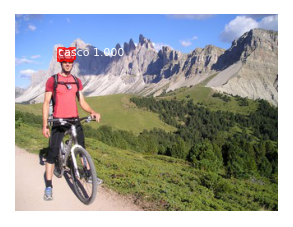

Processing 1 images
image                    shape: (213, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


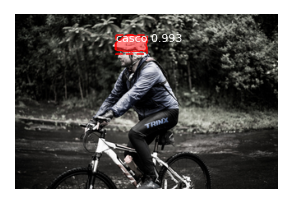

Processing 1 images
image                    shape: (240, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


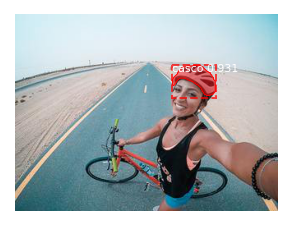

Processing 1 images
image                    shape: (480, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


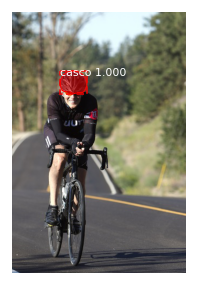

Processing 1 images
image                    shape: (213, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


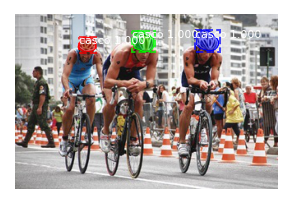

Processing 1 images
image                    shape: (273, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


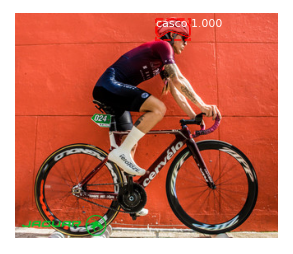

Processing 1 images
image                    shape: (540, 360, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  540.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


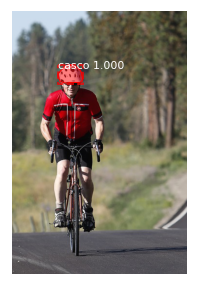

Processing 1 images
image                    shape: (213, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


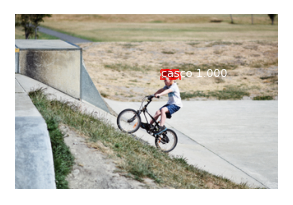

Processing 1 images
image                    shape: (480, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


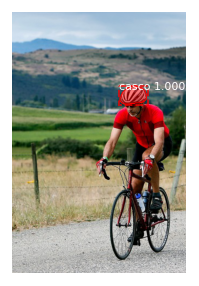

Processing 1 images
image                    shape: (480, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


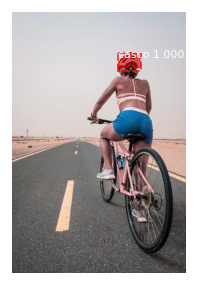

Processing 1 images
image                    shape: (480, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


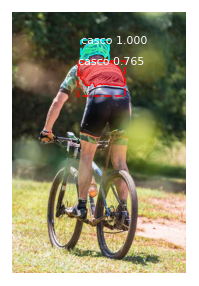

Processing 1 images
image                    shape: (229, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


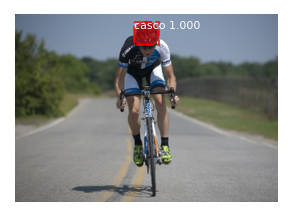

Processing 1 images
image                    shape: (221, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


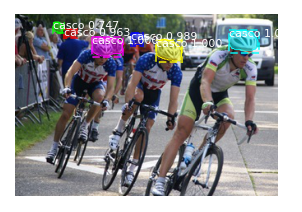

Processing 1 images
image                    shape: (240, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


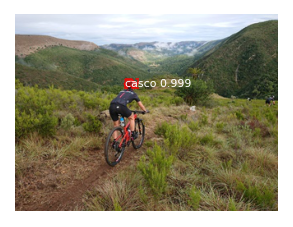

Processing 1 images
image                    shape: (480, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


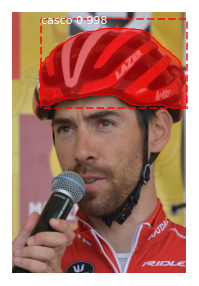

In [18]:
import skimage
real_test_dir = '/content/MaskRCNN_Video/cascoim/val/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))
